# OU jump 12

In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) 
    
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, 
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3])
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3']
    
    return stats_data



def loss_function(params):
    """n_real_stats is a global amount calculated outside the function"""
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=params[12], 
        beta1=beta1, beta2=beta2, 
        delta0=params[13], 
        mu1=params[14], mu2=params[15], 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    moment_loss = (n_real_stats - n_sim_stats)**2
    mse = np.sum(moment_loss)
    
#    mse[0] = mse[0]*100 # return_mean1
#    mse[1] = mse[1]*100 # return_mean2
#    mse[2] = mse[2]/10 # return_sd1
#    mse[3] = mse[3]/10 # return_sd2
#    mse[4] = mse[4]/10 # return_skew1
#    mse[5] = mse[5]/10 # return_skew2    
    mse[6] = mse[6]/50 # return_kurtosis1
    mse[7] = mse[7]/50 # return_kurtosis2 
    
    mse[8] = mse[8]*100 # return_autocorrelation_ts1_lag1
#    mse[9] = mse[9]*10000
#    mse[10] = mse[10]*10000
    mse[11] = mse[11]*100 # return_autocorrelation_ts2_lag1
#    mse[12] = mse[12]*10000
#    mse[13] = mse[13]*10000
    
#    mse[14] = mse[14]*100 # cross_corr
    mse[15] = mse[15]*100 # cross_corr_ts1_lag1
#    mse[16] = mse[16]*10000
#    mse[17] = mse[17]*10000
    mse[18] = mse[18]*100 # cross_corr_ts2_lag1
#    mse[19] = mse[19]*10000
#    mse[20] = mse[20]*10000
    
    mse[21] = mse[21]*100 # sq_return_autocorrelation_ts1_lag1
#    mse[22] = mse[22]*10000
#    mse[23] = mse[23]*10000
    mse[24] = mse[24]*100 # sq_return_autocorrelation_ts2_lag1
#    mse[25] = mse[25]*10000
#    mse[26] = mse[26]*10000
    
    sum_mse = np.sum(mse)

    print(mse)
    print(sum_mse)
    print('----------')

    return sum_mse



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats


#alpha
beta1 = 0
beta2 = 0
#delta0
#mu1
#mu2
lambda11 = 1
lambda12 = 0
lambda21 = 0
lambda22 = 1


initial0 = [1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1,
            1, 1,
            1, 1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (0, None), (0, None), 
                       (None, None), (None, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1]  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1  1.0  1.0  1.0
[16]  1.0

return_mean1                          242.420179
return_mean2                          222.586302
return_sd1                            850.787675
return_sd2                            793.446697
return_skew1                          312.250234
return_skew2                          312.250234
return_kurtosis1                      523.862522
return_kurtosis2                     1040.305074
return_autocorrelation_ts1_lag1       204.007603
return_autocorrelation_ts1_lag2         2.084855
return_autocorrelation_ts1_lag3         2.105772
return_autocorrelation_ts2_lag1       201.393107
return_autocorrelation_ts2_lag2         1.899905
return_autocorrelation_ts2_lag3         1.882938
return_correlation_ts1_lag_0          121.279839
return_correlation_ts1_lag_1          205.762089
return_correlation_ts1_lag_2            1.825107
return_correlation_ts1_lag_3            2.269112
return_correlation_ts2_lag_

return_mean1                          201.328013
return_mean2                          217.956016
return_sd1                            861.591190
return_sd2                            808.592753
return_skew1                          352.625989
return_skew2                          352.625989
return_kurtosis1                      524.134476
return_kurtosis2                     1075.927890
return_autocorrelation_ts1_lag1       207.912514
return_autocorrelation_ts1_lag2         2.529117
return_autocorrelation_ts1_lag3         1.869813
return_autocorrelation_ts2_lag1       199.936861
return_autocorrelation_ts2_lag2         2.347352
return_autocorrelation_ts2_lag3         2.257791
return_correlation_ts1_lag_0          121.240762
return_correlation_ts1_lag_1          181.915203
return_correlation_ts1_lag_2            2.148984
return_correlation_ts1_lag_3            2.497222
return_correlation_ts2_lag_1          202.313876
return_correlation_ts2_lag_2            2.356328
return_correlation_t

return_mean1                          196.151376
return_mean2                          212.675134
return_sd1                            877.122340
return_sd2                            824.826854
return_skew1                          456.279765
return_skew2                          456.279765
return_kurtosis1                      835.176049
return_kurtosis2                     1413.801006
return_autocorrelation_ts1_lag1       251.139552
return_autocorrelation_ts1_lag2         2.253879
return_autocorrelation_ts1_lag3         2.169411
return_autocorrelation_ts2_lag1       212.916870
return_autocorrelation_ts2_lag2         2.132369
return_autocorrelation_ts2_lag3         2.138657
return_correlation_ts1_lag_0          121.241422
return_correlation_ts1_lag_1          196.910797
return_correlation_ts1_lag_2            2.013153
return_correlation_ts1_lag_3            2.124979
return_correlation_ts2_lag_1          255.164699
return_correlation_ts2_lag_2            2.474141
return_correlation_t

return_mean1                          203.751471
return_mean2                          222.679550
return_sd1                            856.444440
return_sd2                            805.300747
return_skew1                          347.852447
return_skew2                          347.852447
return_kurtosis1                      571.668351
return_kurtosis2                     1079.594926
return_autocorrelation_ts1_lag1       261.881113
return_autocorrelation_ts1_lag2         2.166996
return_autocorrelation_ts1_lag3         2.116197
return_autocorrelation_ts2_lag1       223.057944
return_autocorrelation_ts2_lag2         2.098821
return_autocorrelation_ts2_lag3         2.117525
return_correlation_ts1_lag_0          121.236445
return_correlation_ts1_lag_1          198.945508
return_correlation_ts1_lag_2            1.878827
return_correlation_ts1_lag_3            2.020658
return_correlation_ts2_lag_1          251.140892
return_correlation_ts2_lag_2            2.029712
return_correlation_t

return_mean1                          973.536274
return_mean2                          217.000564
return_sd1                            863.214838
return_sd2                            798.200365
return_skew1                          374.854955
return_skew2                          374.854955
return_kurtosis1                      677.988458
return_kurtosis2                     1221.484687
return_autocorrelation_ts1_lag1       253.794008
return_autocorrelation_ts1_lag2         2.996927
return_autocorrelation_ts1_lag3         2.060609
return_autocorrelation_ts2_lag1       219.119416
return_autocorrelation_ts2_lag2         2.375580
return_autocorrelation_ts2_lag3         1.983112
return_correlation_ts1_lag_0          120.456689
return_correlation_ts1_lag_1          215.546948
return_correlation_ts1_lag_2            2.694929
return_correlation_ts1_lag_3            2.388036
return_correlation_ts2_lag_1          230.623076
return_correlation_ts2_lag_2            2.361194
return_correlation_t

return_mean1                           23.550938
return_mean2                          224.949463
return_sd1                            855.305083
return_sd2                            820.824804
return_skew1                          362.968886
return_skew2                          362.968886
return_kurtosis1                      571.920780
return_kurtosis2                     1096.665539
return_autocorrelation_ts1_lag1       216.281225
return_autocorrelation_ts1_lag2         2.160607
return_autocorrelation_ts1_lag3         2.042470
return_autocorrelation_ts2_lag1       218.798142
return_autocorrelation_ts2_lag2         1.888458
return_autocorrelation_ts2_lag3         2.234698
return_correlation_ts1_lag_0          120.884489
return_correlation_ts1_lag_1          215.618952
return_correlation_ts1_lag_2            2.014780
return_correlation_ts1_lag_3            2.344492
return_correlation_ts2_lag_1          222.891845
return_correlation_ts2_lag_2            2.042914
return_correlation_t

return_mean1                           28.954379
return_mean2                          214.984722
return_sd1                            870.180958
return_sd2                            845.539928
return_skew1                          433.786977
return_skew2                          433.786977
return_kurtosis1                      866.275187
return_kurtosis2                     1439.933392
return_autocorrelation_ts1_lag1       219.832813
return_autocorrelation_ts1_lag2         2.020246
return_autocorrelation_ts1_lag3         1.994487
return_autocorrelation_ts2_lag1       217.133968
return_autocorrelation_ts2_lag2         2.295820
return_autocorrelation_ts2_lag3         2.121054
return_correlation_ts1_lag_0          120.967735
return_correlation_ts1_lag_1          217.745951
return_correlation_ts1_lag_2            2.216423
return_correlation_ts1_lag_3            2.105767
return_correlation_ts2_lag_1          213.574515
return_correlation_ts2_lag_2            2.239449
return_correlation_t

return_mean1                           31.266499
return_mean2                          160.170723
return_sd1                            869.647593
return_sd2                            840.960063
return_skew1                          364.157661
return_skew2                          364.157661
return_kurtosis1                      599.255953
return_kurtosis2                     1139.745111
return_autocorrelation_ts1_lag1       227.201766
return_autocorrelation_ts1_lag2         1.938264
return_autocorrelation_ts1_lag3         2.264741
return_autocorrelation_ts2_lag1       230.248095
return_autocorrelation_ts2_lag2         2.100159
return_autocorrelation_ts2_lag3         2.279535
return_correlation_ts1_lag_0          120.575114
return_correlation_ts1_lag_1          219.751052
return_correlation_ts1_lag_2            1.916158
return_correlation_ts1_lag_3            2.111505
return_correlation_ts2_lag_1          216.595062
return_correlation_ts2_lag_2            2.006363
return_correlation_t

return_mean1                           30.678401
return_mean2                          274.338406
return_sd1                            878.921594
return_sd2                            850.557974
return_skew1                          493.863547
return_skew2                          493.863547
return_kurtosis1                      846.287927
return_kurtosis2                     1407.095097
return_autocorrelation_ts1_lag1       230.275823
return_autocorrelation_ts1_lag2         1.870166
return_autocorrelation_ts1_lag3         1.801287
return_autocorrelation_ts2_lag1       217.162334
return_autocorrelation_ts2_lag2         1.790694
return_autocorrelation_ts2_lag3         1.966951
return_correlation_ts1_lag_0          121.158301
return_correlation_ts1_lag_1          224.799412
return_correlation_ts1_lag_2            1.668553
return_correlation_ts1_lag_3            2.114045
return_correlation_ts2_lag_1          246.068446
return_correlation_ts2_lag_2            1.936130
return_correlation_t

return_mean1                           33.080783
return_mean2                          266.088122
return_sd1                            852.474938
return_sd2                            813.673109
return_skew1                          321.625709
return_skew2                          321.625709
return_kurtosis1                      544.133038
return_kurtosis2                     1053.610058
return_autocorrelation_ts1_lag1       209.889944
return_autocorrelation_ts1_lag2         2.022731
return_autocorrelation_ts1_lag3         2.172100
return_autocorrelation_ts2_lag1       211.019613
return_autocorrelation_ts2_lag2         2.042638
return_autocorrelation_ts2_lag3         2.176543
return_correlation_ts1_lag_0          121.134586
return_correlation_ts1_lag_1          186.296230
return_correlation_ts1_lag_2            1.994534
return_correlation_ts1_lag_3            2.427728
return_correlation_ts2_lag_1          228.371072
return_correlation_ts2_lag_2            1.791420
return_correlation_t

return_mean1                           25.635874
return_mean2                          256.550084
return_sd1                            848.206793
return_sd2                            811.542252
return_skew1                          332.702097
return_skew2                          332.702097
return_kurtosis1                      507.684256
return_kurtosis2                     1042.938857
return_autocorrelation_ts1_lag1       189.030870
return_autocorrelation_ts1_lag2         2.128709
return_autocorrelation_ts1_lag3         2.126902
return_autocorrelation_ts2_lag1       189.027501
return_autocorrelation_ts2_lag2         2.057890
return_autocorrelation_ts2_lag3         1.972243
return_correlation_ts1_lag_0          121.139342
return_correlation_ts1_lag_1          196.768820
return_correlation_ts1_lag_2            2.001997
return_correlation_ts1_lag_3            2.292916
return_correlation_ts2_lag_1          198.503537
return_correlation_ts2_lag_2            1.945524
return_correlation_t

return_mean1                           31.104403
return_mean2                           62.180605
return_sd1                            843.751812
return_sd2                            795.169177
return_skew1                          309.534216
return_skew2                          309.534216
return_kurtosis1                      497.865015
return_kurtosis2                     1038.604533
return_autocorrelation_ts1_lag1       220.538173
return_autocorrelation_ts1_lag2         2.243096
return_autocorrelation_ts1_lag3         2.134716
return_autocorrelation_ts2_lag1       207.173948
return_autocorrelation_ts2_lag2         2.297192
return_autocorrelation_ts2_lag3         1.783818
return_correlation_ts1_lag_0          121.138662
return_correlation_ts1_lag_1          219.697508
return_correlation_ts1_lag_2            2.064809
return_correlation_ts1_lag_3            2.224386
return_correlation_ts2_lag_1          213.159126
return_correlation_ts2_lag_2            2.209221
return_correlation_t

return_mean1                           27.675789
return_mean2                           93.483672
return_sd1                            858.081584
return_sd2                            805.394478
return_skew1                          336.091423
return_skew2                          336.091423
return_kurtosis1                      567.859316
return_kurtosis2                     1154.609934
return_autocorrelation_ts1_lag1       242.001365
return_autocorrelation_ts1_lag2         2.166215
return_autocorrelation_ts1_lag3         2.024913
return_autocorrelation_ts2_lag1       231.387402
return_autocorrelation_ts2_lag2         1.834041
return_autocorrelation_ts2_lag3         1.863754
return_correlation_ts1_lag_0          121.242773
return_correlation_ts1_lag_1          205.096952
return_correlation_ts1_lag_2            1.765346
return_correlation_ts1_lag_3            2.101991
return_correlation_ts2_lag_1          221.199208
return_correlation_ts2_lag_2            1.941195
return_correlation_t

return_mean1                           30.092431
return_mean2                           94.722045
return_sd1                            836.780210
return_sd2                            788.722641
return_skew1                          316.525142
return_skew2                          316.525142
return_kurtosis1                      514.890377
return_kurtosis2                     1076.431840
return_autocorrelation_ts1_lag1       248.405092
return_autocorrelation_ts1_lag2         2.186213
return_autocorrelation_ts1_lag3         2.067130
return_autocorrelation_ts2_lag1       185.187622
return_autocorrelation_ts2_lag2         2.039362
return_autocorrelation_ts2_lag3         2.190624
return_correlation_ts1_lag_0          121.248666
return_correlation_ts1_lag_1          180.801754
return_correlation_ts1_lag_2            1.992614
return_correlation_ts1_lag_3            2.329202
return_correlation_ts2_lag_1          200.987531
return_correlation_ts2_lag_2            2.240538
return_correlation_t

return_mean1                           57.554410
return_mean2                          101.753557
return_sd1                           6698.262681
return_sd2                            827.651450
return_skew1                          308.665140
return_skew2                          308.665140
return_kurtosis1                      521.461798
return_kurtosis2                     1485.561541
return_autocorrelation_ts1_lag1       206.360976
return_autocorrelation_ts1_lag2         2.235118
return_autocorrelation_ts1_lag3         2.256272
return_autocorrelation_ts2_lag1       184.491106
return_autocorrelation_ts2_lag2         2.329882
return_autocorrelation_ts2_lag3         2.032594
return_correlation_ts1_lag_0           91.004785
return_correlation_ts1_lag_1          213.613105
return_correlation_ts1_lag_2            2.211532
return_correlation_ts1_lag_3            2.178059
return_correlation_ts2_lag_1          202.334645
return_correlation_ts2_lag_2            2.268791
return_correlation_t

return_mean1                           31.959785
return_mean2                           97.803765
return_sd1                            879.518209
return_sd2                            787.823547
return_skew1                          315.918502
return_skew2                          315.918502
return_kurtosis1                      512.664586
return_kurtosis2                     1052.126857
return_autocorrelation_ts1_lag1       246.467477
return_autocorrelation_ts1_lag2         2.128324
return_autocorrelation_ts1_lag3         2.286941
return_autocorrelation_ts2_lag1       225.789302
return_autocorrelation_ts2_lag2         2.052156
return_autocorrelation_ts2_lag3         2.115927
return_correlation_ts1_lag_0          121.217832
return_correlation_ts1_lag_1          215.937888
return_correlation_ts1_lag_2            1.959270
return_correlation_ts1_lag_3            2.532311
return_correlation_ts2_lag_1          244.428974
return_correlation_ts2_lag_2            1.871330
return_correlation_t

return_mean1                           29.318223
return_mean2                           95.022769
return_sd1                            883.900521
return_sd2                            798.415662
return_skew1                          328.613138
return_skew2                          328.613138
return_kurtosis1                      551.969097
return_kurtosis2                     1086.882145
return_autocorrelation_ts1_lag1       193.887611
return_autocorrelation_ts1_lag2         2.110405
return_autocorrelation_ts1_lag3         2.219134
return_autocorrelation_ts2_lag1       225.133786
return_autocorrelation_ts2_lag2         1.953962
return_autocorrelation_ts2_lag3         1.851607
return_correlation_ts1_lag_0          121.222156
return_correlation_ts1_lag_1          190.718843
return_correlation_ts1_lag_2            1.835638
return_correlation_ts1_lag_3            2.391138
return_correlation_ts2_lag_1          214.883309
return_correlation_ts2_lag_2            1.967625
return_correlation_t

return_mean1                           30.647923
return_mean2                           98.993130
return_sd1                            873.810909
return_sd2                            781.470054
return_skew1                          316.378846
return_skew2                          316.378846
return_kurtosis1                      528.322399
return_kurtosis2                     1054.832513
return_autocorrelation_ts1_lag1       180.593848
return_autocorrelation_ts1_lag2         2.145314
return_autocorrelation_ts1_lag3         1.965286
return_autocorrelation_ts2_lag1       187.223412
return_autocorrelation_ts2_lag2         2.032701
return_autocorrelation_ts2_lag3         2.402001
return_correlation_ts1_lag_0          121.212855
return_correlation_ts1_lag_1          193.220928
return_correlation_ts1_lag_2            2.098944
return_correlation_ts1_lag_3            2.226268
return_correlation_ts2_lag_1          196.922616
return_correlation_ts2_lag_2            1.703802
return_correlation_t

return_mean1                           29.785485
return_mean2                           93.539163
return_sd1                            903.940759
return_sd2                            812.124363
return_skew1                          407.811364
return_skew2                          407.811364
return_kurtosis1                      636.966297
return_kurtosis2                     1103.634023
return_autocorrelation_ts1_lag1       212.909214
return_autocorrelation_ts1_lag2         2.325925
return_autocorrelation_ts1_lag3         2.244596
return_autocorrelation_ts2_lag1       223.956520
return_autocorrelation_ts2_lag2         1.958373
return_autocorrelation_ts2_lag3         2.007525
return_correlation_ts1_lag_0          121.214252
return_correlation_ts1_lag_1          216.099540
return_correlation_ts1_lag_2            2.046667
return_correlation_ts1_lag_3            2.483665
return_correlation_ts2_lag_1          236.568220
return_correlation_ts2_lag_2            2.086937
return_correlation_t

return_mean1                           29.068500
return_mean2                           99.902329
return_sd1                            285.738765
return_sd2                            791.843831
return_skew1                          369.093316
return_skew2                          369.093316
return_kurtosis1                      570.829142
return_kurtosis2                     1063.255617
return_autocorrelation_ts1_lag1       196.592106
return_autocorrelation_ts1_lag2         2.109588
return_autocorrelation_ts1_lag3         2.331401
return_autocorrelation_ts2_lag1       208.994359
return_autocorrelation_ts2_lag2         2.319759
return_autocorrelation_ts2_lag3         1.802765
return_correlation_ts1_lag_0           73.171751
return_correlation_ts1_lag_1          186.070368
return_correlation_ts1_lag_2            2.075401
return_correlation_ts1_lag_3            2.407269
return_correlation_ts2_lag_1          208.152493
return_correlation_ts2_lag_2            2.235255
return_correlation_t

return_mean1                           29.008856
return_mean2                          100.586673
return_sd1                            445.530087
return_sd2                            812.070405
return_skew1                          411.697983
return_skew2                          411.697983
return_kurtosis1                      635.598746
return_kurtosis2                     1048.729701
return_autocorrelation_ts1_lag1       230.243781
return_autocorrelation_ts1_lag2         2.086542
return_autocorrelation_ts1_lag3         2.056511
return_autocorrelation_ts2_lag1       215.398192
return_autocorrelation_ts2_lag2         2.230132
return_autocorrelation_ts2_lag3         2.205198
return_correlation_ts1_lag_0          106.928457
return_correlation_ts1_lag_1          187.102599
return_correlation_ts1_lag_2            2.142209
return_correlation_ts1_lag_3            2.376491
return_correlation_ts2_lag_1          234.341383
return_correlation_ts2_lag_2            2.094816
return_correlation_t

return_mean1                           26.745587
return_mean2                           97.399803
return_sd1                            315.595738
return_sd2                            791.165358
return_skew1                          522.293869
return_skew2                          522.293869
return_kurtosis1                      810.284104
return_kurtosis2                     1126.937647
return_autocorrelation_ts1_lag1       204.240407
return_autocorrelation_ts1_lag2         2.215688
return_autocorrelation_ts1_lag3         1.896333
return_autocorrelation_ts2_lag1       222.096318
return_autocorrelation_ts2_lag2         2.331584
return_autocorrelation_ts2_lag3         1.823714
return_correlation_ts1_lag_0           82.862125
return_correlation_ts1_lag_1          236.552828
return_correlation_ts1_lag_2            1.953171
return_correlation_ts1_lag_3            2.129493
return_correlation_ts2_lag_1          221.883918
return_correlation_ts2_lag_2            2.099654
return_correlation_t

return_mean1                           27.263179
return_mean2                           98.096493
return_sd1                            324.396097
return_sd2                            790.971573
return_skew1                          410.235148
return_skew2                          410.235148
return_kurtosis1                      791.011115
return_kurtosis2                     1065.769622
return_autocorrelation_ts1_lag1       218.600057
return_autocorrelation_ts1_lag2         2.176040
return_autocorrelation_ts1_lag3         2.030323
return_autocorrelation_ts2_lag1       197.904977
return_autocorrelation_ts2_lag2         2.056928
return_autocorrelation_ts2_lag3         1.936195
return_correlation_ts1_lag_0           84.047818
return_correlation_ts1_lag_1          207.989396
return_correlation_ts1_lag_2            2.188794
return_correlation_ts1_lag_3            2.175940
return_correlation_ts2_lag_1          227.310689
return_correlation_ts2_lag_2            2.006848
return_correlation_t

return_mean1                           29.204133
return_mean2                          102.285579
return_sd1                            339.129368
return_sd2                            815.470448
return_skew1                          649.415386
return_skew2                          649.415386
return_kurtosis1                     1344.345588
return_kurtosis2                     1245.373741
return_autocorrelation_ts1_lag1       201.761102
return_autocorrelation_ts1_lag2         2.090439
return_autocorrelation_ts1_lag3         2.229144
return_autocorrelation_ts2_lag1       190.761425
return_autocorrelation_ts2_lag2         2.100944
return_autocorrelation_ts2_lag3         2.247624
return_correlation_ts1_lag_0           84.360945
return_correlation_ts1_lag_1          182.164703
return_correlation_ts1_lag_2            1.843598
return_correlation_ts1_lag_3            2.359437
return_correlation_ts2_lag_1          234.751602
return_correlation_ts2_lag_2            2.185632
return_correlation_t

return_mean1                           25.354749
return_mean2                           93.938134
return_sd1                            328.477718
return_sd2                           1669.943609
return_skew1                          492.352858
return_skew2                          492.352858
return_kurtosis1                      865.010590
return_kurtosis2                     1079.045592
return_autocorrelation_ts1_lag1       222.852671
return_autocorrelation_ts1_lag2         2.371638
return_autocorrelation_ts1_lag3         2.238153
return_autocorrelation_ts2_lag1       191.313533
return_autocorrelation_ts2_lag2         2.140179
return_autocorrelation_ts2_lag3         2.171121
return_correlation_ts1_lag_0          103.266638
return_correlation_ts1_lag_1          191.354946
return_correlation_ts1_lag_2            2.217215
return_correlation_ts1_lag_3            2.370386
return_correlation_ts2_lag_1          181.404741
return_correlation_ts2_lag_2            2.262766
return_correlation_t

return_mean1                           27.237195
return_mean2                           96.792190
return_sd1                            328.609437
return_sd2                            591.229406
return_skew1                          585.675330
return_skew2                          585.675330
return_kurtosis1                     1120.689356
return_kurtosis2                     1302.682134
return_autocorrelation_ts1_lag1       214.370376
return_autocorrelation_ts1_lag2         2.209896
return_autocorrelation_ts1_lag3         2.255318
return_autocorrelation_ts2_lag1       235.339130
return_autocorrelation_ts2_lag2         2.147777
return_autocorrelation_ts2_lag3         1.873791
return_correlation_ts1_lag_0           72.897317
return_correlation_ts1_lag_1          210.445219
return_correlation_ts1_lag_2            2.003419
return_correlation_ts1_lag_3            2.150594
return_correlation_ts2_lag_1          223.267680
return_correlation_ts2_lag_2            1.841539
return_correlation_t

return_mean1                           27.990007
return_mean2                          102.903585
return_sd1                            310.686834
return_sd2                            596.243766
return_skew1                          345.193254
return_skew2                          345.193254
return_kurtosis1                      589.391234
return_kurtosis2                     1084.594834
return_autocorrelation_ts1_lag1       203.266953
return_autocorrelation_ts1_lag2         2.466000
return_autocorrelation_ts1_lag3         2.193459
return_autocorrelation_ts2_lag1       174.659808
return_autocorrelation_ts2_lag2         1.880515
return_autocorrelation_ts2_lag3         2.180878
return_correlation_ts1_lag_0           73.348365
return_correlation_ts1_lag_1          182.737078
return_correlation_ts1_lag_2            2.087026
return_correlation_ts1_lag_3            2.373087
return_correlation_ts2_lag_1          216.194983
return_correlation_ts2_lag_2            2.082769
return_correlation_t

return_mean1                           28.194301
return_mean2                           94.008662
return_sd1                            336.667274
return_sd2                            153.309192
return_skew1                          486.160443
return_skew2                          486.160443
return_kurtosis1                      871.821073
return_kurtosis2                     2070.107247
return_autocorrelation_ts1_lag1       225.354963
return_autocorrelation_ts1_lag2         2.401171
return_autocorrelation_ts1_lag3         2.246645
return_autocorrelation_ts2_lag1       200.124170
return_autocorrelation_ts2_lag2         2.044252
return_autocorrelation_ts2_lag3         1.798186
return_correlation_ts1_lag_0          120.265297
return_correlation_ts1_lag_1          224.668999
return_correlation_ts1_lag_2            2.127197
return_correlation_ts1_lag_3            2.019498
return_correlation_ts2_lag_1          221.494049
return_correlation_ts2_lag_2            2.045427
return_correlation_t

return_mean1                           28.030460
return_mean2                           96.703222
return_sd1                            311.814876
return_sd2                            518.273402
return_skew1                          462.551129
return_skew2                          462.551129
return_kurtosis1                      661.934329
return_kurtosis2                     1120.731484
return_autocorrelation_ts1_lag1       207.028150
return_autocorrelation_ts1_lag2         2.286926
return_autocorrelation_ts1_lag3         2.286425
return_autocorrelation_ts2_lag1       201.580479
return_autocorrelation_ts2_lag2         1.894753
return_autocorrelation_ts2_lag3         1.872530
return_correlation_ts1_lag_0           78.458164
return_correlation_ts1_lag_1          197.956452
return_correlation_ts1_lag_2            1.999888
return_correlation_ts1_lag_3            1.997339
return_correlation_ts2_lag_1          224.586316
return_correlation_ts2_lag_2            2.055032
return_correlation_t

return_mean1                           28.584329
return_mean2                          103.089338
return_sd1                            319.099978
return_sd2                            515.032200
return_skew1                          530.406991
return_skew2                          530.406991
return_kurtosis1                      984.055398
return_kurtosis2                     1300.119732
return_autocorrelation_ts1_lag1       183.779464
return_autocorrelation_ts1_lag2         2.159132
return_autocorrelation_ts1_lag3         2.227486
return_autocorrelation_ts2_lag1       218.957208
return_autocorrelation_ts2_lag2         2.066915
return_autocorrelation_ts2_lag3         2.187575
return_correlation_ts1_lag_0           78.522356
return_correlation_ts1_lag_1          194.725704
return_correlation_ts1_lag_2            1.922475
return_correlation_ts1_lag_3            2.545814
return_correlation_ts2_lag_1          217.819497
return_correlation_ts2_lag_2            2.289063
return_correlation_t

return_mean1                           30.981149
return_mean2                          105.257591
return_sd1                            342.901037
return_sd2                            540.708548
return_skew1                          685.150619
return_skew2                          685.150619
return_kurtosis1                     1174.604246
return_kurtosis2                     1645.906315
return_autocorrelation_ts1_lag1       182.059245
return_autocorrelation_ts1_lag2         2.086711
return_autocorrelation_ts1_lag3         2.309068
return_autocorrelation_ts2_lag1       181.956903
return_autocorrelation_ts2_lag2         2.080709
return_autocorrelation_ts2_lag3         2.109142
return_correlation_ts1_lag_0           79.045693
return_correlation_ts1_lag_1          193.590796
return_correlation_ts1_lag_2            2.057272
return_correlation_ts1_lag_3            2.521319
return_correlation_ts2_lag_1          196.561514
return_correlation_ts2_lag_2            2.284313
return_correlation_t

return_mean1                           27.343996
return_mean2                           99.199674
return_sd1                            325.848450
return_sd2                            515.545779
return_skew1                          472.517962
return_skew2                          472.517962
return_kurtosis1                      730.835248
return_kurtosis2                     1132.363386
return_autocorrelation_ts1_lag1       225.172600
return_autocorrelation_ts1_lag2         2.250442
return_autocorrelation_ts1_lag3         2.130637
return_autocorrelation_ts2_lag1       191.396689
return_autocorrelation_ts2_lag2         1.841857
return_autocorrelation_ts2_lag3         2.203470
return_correlation_ts1_lag_0           79.313227
return_correlation_ts1_lag_1          188.761659
return_correlation_ts1_lag_2            2.178870
return_correlation_ts1_lag_3            2.320626
return_correlation_ts2_lag_1          234.695598
return_correlation_ts2_lag_2            1.943173
return_correlation_t

return_mean1                           30.935628
return_mean2                           92.613361
return_sd1                            291.417428
return_sd2                            523.664092
return_skew1                          498.367850
return_skew2                          498.367850
return_kurtosis1                      841.822688
return_kurtosis2                     1358.689294
return_autocorrelation_ts1_lag1       210.580001
return_autocorrelation_ts1_lag2         2.275254
return_autocorrelation_ts1_lag3         1.992163
return_autocorrelation_ts2_lag1       215.433755
return_autocorrelation_ts2_lag2         2.032412
return_autocorrelation_ts2_lag3         2.012715
return_correlation_ts1_lag_0           73.466989
return_correlation_ts1_lag_1          202.760767
return_correlation_ts1_lag_2            2.066086
return_correlation_ts1_lag_3            2.112322
return_correlation_ts2_lag_1          223.513852
return_correlation_ts2_lag_2            1.972521
return_correlation_t

return_mean1                           31.947423
return_mean2                           95.795197
return_sd1                            299.253573
return_sd2                            525.033502
return_skew1                          418.731283
return_skew2                          418.731283
return_kurtosis1                      799.937173
return_kurtosis2                     1485.641619
return_autocorrelation_ts1_lag1       176.513545
return_autocorrelation_ts1_lag2         2.355898
return_autocorrelation_ts1_lag3         1.740589
return_autocorrelation_ts2_lag1       212.560348
return_autocorrelation_ts2_lag2         2.408508
return_autocorrelation_ts2_lag3         2.124543
return_correlation_ts1_lag_0           67.889936
return_correlation_ts1_lag_1          190.414927
return_correlation_ts1_lag_2            2.270986
return_correlation_ts1_lag_3            2.309198
return_correlation_ts2_lag_1          205.571789
return_correlation_ts2_lag_2            2.153647
return_correlation_t

return_mean1                           31.796431
return_mean2                           94.374077
return_sd1                            281.430911
return_sd2                            515.207178
return_skew1                          347.081790
return_skew2                          347.081790
return_kurtosis1                      569.539519
return_kurtosis2                     1197.264778
return_autocorrelation_ts1_lag1       173.135476
return_autocorrelation_ts1_lag2         2.180969
return_autocorrelation_ts1_lag3         1.777049
return_autocorrelation_ts2_lag1       184.846910
return_autocorrelation_ts2_lag2         2.090809
return_autocorrelation_ts2_lag3         1.979807
return_correlation_ts1_lag_0           67.753136
return_correlation_ts1_lag_1          165.695258
return_correlation_ts1_lag_2            1.950134
return_correlation_ts1_lag_3            2.097613
return_correlation_ts2_lag_1          205.264861
return_correlation_ts2_lag_2            2.061446
return_correlation_t

return_mean1                            86.481487
return_mean2                            98.558694
return_sd1                            1586.518063
return_sd2                             510.430678
return_skew1                          3881.483500
return_skew2                          3881.483500
return_kurtosis1                     10232.014352
return_kurtosis2                      1120.422035
return_autocorrelation_ts1_lag1        219.121622
return_autocorrelation_ts1_lag2          2.101333
return_autocorrelation_ts1_lag3          1.771944
return_autocorrelation_ts2_lag1        232.684348
return_autocorrelation_ts2_lag2          2.264892
return_autocorrelation_ts2_lag3          2.104832
return_correlation_ts1_lag_0            26.989673
return_correlation_ts1_lag_1           206.855748
return_correlation_ts1_lag_2             2.266125
return_correlation_ts1_lag_3             2.372389
return_correlation_ts2_lag_1           205.978704
return_correlation_ts2_lag_2             2.112920


return_mean1                           43.601326
return_mean2                           95.749402
return_sd1                            275.587479
return_sd2                            540.699678
return_skew1                          315.870733
return_skew2                          315.870733
return_kurtosis1                      541.183649
return_kurtosis2                     1173.369946
return_autocorrelation_ts1_lag1       205.377356
return_autocorrelation_ts1_lag2         2.070484
return_autocorrelation_ts1_lag3         2.079278
return_autocorrelation_ts2_lag1       192.719360
return_autocorrelation_ts2_lag2         1.744937
return_autocorrelation_ts2_lag3         2.131028
return_correlation_ts1_lag_0           55.232730
return_correlation_ts1_lag_1          185.566152
return_correlation_ts1_lag_2            1.787371
return_correlation_ts1_lag_3            2.327292
return_correlation_ts2_lag_1          225.612137
return_correlation_ts2_lag_2            2.020293
return_correlation_t

return_mean1                           38.478668
return_mean2                           93.373450
return_sd1                            253.205619
return_sd2                            499.655149
return_skew1                          275.255395
return_skew2                          275.255395
return_kurtosis1                      516.557420
return_kurtosis2                     1198.563738
return_autocorrelation_ts1_lag1       205.013551
return_autocorrelation_ts1_lag2         2.068065
return_autocorrelation_ts1_lag3         2.035318
return_autocorrelation_ts2_lag1       203.496268
return_autocorrelation_ts2_lag2         2.144065
return_autocorrelation_ts2_lag3         2.066431
return_correlation_ts1_lag_0           58.894263
return_correlation_ts1_lag_1          178.634902
return_correlation_ts1_lag_2            1.696488
return_correlation_ts1_lag_3            2.480410
return_correlation_ts2_lag_1          214.409246
return_correlation_ts2_lag_2            2.131302
return_correlation_t

return_mean1                           42.444228
return_mean2                           97.627843
return_sd1                            267.481240
return_sd2                            496.148749
return_skew1                          287.253519
return_skew2                          287.253519
return_kurtosis1                      510.863947
return_kurtosis2                     1052.382292
return_autocorrelation_ts1_lag1       220.903351
return_autocorrelation_ts1_lag2         2.274126
return_autocorrelation_ts1_lag3         2.186589
return_autocorrelation_ts2_lag1       211.144454
return_autocorrelation_ts2_lag2         2.328395
return_autocorrelation_ts2_lag3         2.108720
return_correlation_ts1_lag_0           58.326127
return_correlation_ts1_lag_1          211.961565
return_correlation_ts1_lag_2            2.377416
return_correlation_ts1_lag_3            2.230841
return_correlation_ts2_lag_1          253.282926
return_correlation_ts2_lag_2            1.878040
return_correlation_t

return_mean1                            40.813915
return_mean2                           354.158284
return_sd1                             269.097141
return_sd2                           15707.604380
return_skew1                           310.849336
return_skew2                           310.849336
return_kurtosis1                       551.779318
return_kurtosis2                     29178.029580
return_autocorrelation_ts1_lag1        200.832601
return_autocorrelation_ts1_lag2          2.158926
return_autocorrelation_ts1_lag3          2.078570
return_autocorrelation_ts2_lag1        210.093658
return_autocorrelation_ts2_lag2          2.028473
return_autocorrelation_ts2_lag3          1.881449
return_correlation_ts1_lag_0            15.272932
return_correlation_ts1_lag_1           203.757920
return_correlation_ts1_lag_2             1.930696
return_correlation_ts1_lag_3             1.930293
return_correlation_ts2_lag_1           228.122438
return_correlation_ts2_lag_2             2.044141


return_mean1                           42.482791
return_mean2                           88.076540
return_sd1                            267.774157
return_sd2                            743.306062
return_skew1                          279.347245
return_skew2                          279.347245
return_kurtosis1                      500.833992
return_kurtosis2                     2650.056010
return_autocorrelation_ts1_lag1       198.345830
return_autocorrelation_ts1_lag2         2.188892
return_autocorrelation_ts1_lag3         2.197792
return_autocorrelation_ts2_lag1       231.720214
return_autocorrelation_ts2_lag2         2.008591
return_autocorrelation_ts2_lag3         2.135566
return_correlation_ts1_lag_0           47.407540
return_correlation_ts1_lag_1          185.125263
return_correlation_ts1_lag_2            2.029660
return_correlation_ts1_lag_3            2.515820
return_correlation_ts2_lag_1          241.937268
return_correlation_ts2_lag_2            1.919319
return_correlation_t

return_mean1                           39.388879
return_mean2                           94.806014
return_sd1                            265.561631
return_sd2                            534.187080
return_skew1                          296.164135
return_skew2                          296.164135
return_kurtosis1                      528.844378
return_kurtosis2                     1419.789912
return_autocorrelation_ts1_lag1       191.438341
return_autocorrelation_ts1_lag2         2.414070
return_autocorrelation_ts1_lag3         2.349064
return_autocorrelation_ts2_lag1       191.305467
return_autocorrelation_ts2_lag2         2.261541
return_autocorrelation_ts2_lag3         2.156156
return_correlation_ts1_lag_0           57.864285
return_correlation_ts1_lag_1          208.781322
return_correlation_ts1_lag_2            2.085021
return_correlation_ts1_lag_3            2.663533
return_correlation_ts2_lag_1          243.078415
return_correlation_ts2_lag_2            2.265561
return_correlation_t

return_mean1                           39.147454
return_mean2                           91.787598
return_sd1                            255.896734
return_sd2                            488.923231
return_skew1                          291.909666
return_skew2                          291.909666
return_kurtosis1                      511.496116
return_kurtosis2                     1015.866010
return_autocorrelation_ts1_lag1       217.241690
return_autocorrelation_ts1_lag2         2.220726
return_autocorrelation_ts1_lag3         2.129820
return_autocorrelation_ts2_lag1       194.853454
return_autocorrelation_ts2_lag2         1.884737
return_autocorrelation_ts2_lag3         1.971539
return_correlation_ts1_lag_0           60.126256
return_correlation_ts1_lag_1          207.874870
return_correlation_ts1_lag_2            1.848323
return_correlation_ts1_lag_3            2.354484
return_correlation_ts2_lag_1          211.039567
return_correlation_ts2_lag_2            1.991549
return_correlation_t

return_mean1                           44.536181
return_mean2                          103.646458
return_sd1                            268.868616
return_sd2                            518.440139
return_skew1                          291.044341
return_skew2                          291.044341
return_kurtosis1                      518.873751
return_kurtosis2                     1114.467139
return_autocorrelation_ts1_lag1       214.779639
return_autocorrelation_ts1_lag2         2.527616
return_autocorrelation_ts1_lag3         2.158522
return_autocorrelation_ts2_lag1       202.308461
return_autocorrelation_ts2_lag2         1.927937
return_autocorrelation_ts2_lag3         2.107942
return_correlation_ts1_lag_0           58.536495
return_correlation_ts1_lag_1          176.887237
return_correlation_ts1_lag_2            2.191686
return_correlation_ts1_lag_3            2.560501
return_correlation_ts2_lag_1          247.338542
return_correlation_ts2_lag_2            1.995069
return_correlation_t

return_mean1                           40.079856
return_mean2                           91.092307
return_sd1                            259.163045
return_sd2                            513.554819
return_skew1                          294.518403
return_skew2                          294.518403
return_kurtosis1                      503.895398
return_kurtosis2                     1141.093114
return_autocorrelation_ts1_lag1       216.007954
return_autocorrelation_ts1_lag2         2.362261
return_autocorrelation_ts1_lag3         2.253531
return_autocorrelation_ts2_lag1       230.276500
return_autocorrelation_ts2_lag2         2.100803
return_autocorrelation_ts2_lag3         2.150185
return_correlation_ts1_lag_0           57.399807
return_correlation_ts1_lag_1          220.384748
return_correlation_ts1_lag_2            2.105574
return_correlation_ts1_lag_3            2.222989
return_correlation_ts2_lag_1          218.684603
return_correlation_ts2_lag_2            2.219441
return_correlation_t

return_mean1                           42.497640
return_mean2                          102.044089
return_sd1                            261.468619
return_sd2                            467.041948
return_skew1                          289.271707
return_skew2                          289.271707
return_kurtosis1                      510.928999
return_kurtosis2                     1069.263853
return_autocorrelation_ts1_lag1       209.153095
return_autocorrelation_ts1_lag2         2.171121
return_autocorrelation_ts1_lag3         2.031565
return_autocorrelation_ts2_lag1       193.870923
return_autocorrelation_ts2_lag2         2.220640
return_autocorrelation_ts2_lag3         2.164640
return_correlation_ts1_lag_0           64.423324
return_correlation_ts1_lag_1          199.176844
return_correlation_ts1_lag_2            2.031832
return_correlation_ts1_lag_3            2.378468
return_correlation_ts2_lag_1          229.885091
return_correlation_ts2_lag_2            2.095514
return_correlation_t

return_mean1                           39.760895
return_mean2                          101.925368
return_sd1                            263.353995
return_sd2                            474.459007
return_skew1                          284.902662
return_skew2                          284.902662
return_kurtosis1                      513.801065
return_kurtosis2                     1013.535576
return_autocorrelation_ts1_lag1       218.129869
return_autocorrelation_ts1_lag2         2.059941
return_autocorrelation_ts1_lag3         2.183175
return_autocorrelation_ts2_lag1       184.433163
return_autocorrelation_ts2_lag2         1.923669
return_autocorrelation_ts2_lag3         2.164987
return_correlation_ts1_lag_0           63.205303
return_correlation_ts1_lag_1          198.640078
return_correlation_ts1_lag_2            1.816444
return_correlation_ts1_lag_3            2.380448
return_correlation_ts2_lag_1          224.458480
return_correlation_ts2_lag_2            2.036387
return_correlation_t

return_mean1                           41.984736
return_mean2                          102.261897
return_sd1                            269.065643
return_sd2                            470.902242
return_skew1                          311.931381
return_skew2                          311.931381
return_kurtosis1                      532.520103
return_kurtosis2                     1334.545309
return_autocorrelation_ts1_lag1       216.043722
return_autocorrelation_ts1_lag2         2.148058
return_autocorrelation_ts1_lag3         1.874581
return_autocorrelation_ts2_lag1       220.646406
return_autocorrelation_ts2_lag2         1.899510
return_autocorrelation_ts2_lag3         2.094141
return_correlation_ts1_lag_0           63.708659
return_correlation_ts1_lag_1          206.690121
return_correlation_ts1_lag_2            2.014819
return_correlation_ts1_lag_3            2.250514
return_correlation_ts2_lag_1          251.301806
return_correlation_ts2_lag_2            2.006366
return_correlation_t

return_mean1                           42.764256
return_mean2                          102.623800
return_sd1                            258.984215
return_sd2                            462.833649
return_skew1                          275.807172
return_skew2                          275.807172
return_kurtosis1                      526.518466
return_kurtosis2                     1097.506611
return_autocorrelation_ts1_lag1       233.381514
return_autocorrelation_ts1_lag2         2.022239
return_autocorrelation_ts1_lag3         2.172245
return_autocorrelation_ts2_lag1       185.466160
return_autocorrelation_ts2_lag2         2.170572
return_autocorrelation_ts2_lag3         1.881435
return_correlation_ts1_lag_0           67.080282
return_correlation_ts1_lag_1          182.791663
return_correlation_ts1_lag_2            1.875724
return_correlation_ts1_lag_3            2.269617
return_correlation_ts2_lag_1          225.421335
return_correlation_ts2_lag_2            2.060079
return_correlation_t

return_mean1                           41.958592
return_mean2                           99.706744
return_sd1                            254.496430
return_sd2                            449.395918
return_skew1                          271.652281
return_skew2                          271.652281
return_kurtosis1                      510.454883
return_kurtosis2                     1071.100703
return_autocorrelation_ts1_lag1       223.233426
return_autocorrelation_ts1_lag2         2.326926
return_autocorrelation_ts1_lag3         2.063135
return_autocorrelation_ts2_lag1       192.507026
return_autocorrelation_ts2_lag2         2.056576
return_autocorrelation_ts2_lag3         2.507414
return_correlation_ts1_lag_0           67.592610
return_correlation_ts1_lag_1          218.676458
return_correlation_ts1_lag_2            1.963353
return_correlation_ts1_lag_3            2.290938
return_correlation_ts2_lag_1          231.659472
return_correlation_ts2_lag_2            1.900596
return_correlation_t

return_mean1                           41.058261
return_mean2                          100.246147
return_sd1                            259.241542
return_sd2                            454.921773
return_skew1                          271.188184
return_skew2                          271.188184
return_kurtosis1                      513.095841
return_kurtosis2                     1057.930776
return_autocorrelation_ts1_lag1       269.930845
return_autocorrelation_ts1_lag2         2.495064
return_autocorrelation_ts1_lag3         2.091311
return_autocorrelation_ts2_lag1       216.757858
return_autocorrelation_ts2_lag2         2.395411
return_autocorrelation_ts2_lag3         2.397524
return_correlation_ts1_lag_0           67.218069
return_correlation_ts1_lag_1          215.160933
return_correlation_ts1_lag_2            2.456080
return_correlation_ts1_lag_3            2.451734
return_correlation_ts2_lag_1          271.256654
return_correlation_ts2_lag_2            2.650088
return_correlation_t

return_mean1                           43.392914
return_mean2                          106.421056
return_sd1                            259.142982
return_sd2                            452.626861
return_skew1                          275.307746
return_skew2                          275.307746
return_kurtosis1                      516.026893
return_kurtosis2                     1074.444049
return_autocorrelation_ts1_lag1       213.122015
return_autocorrelation_ts1_lag2         2.137303
return_autocorrelation_ts1_lag3         2.047991
return_autocorrelation_ts2_lag1       222.710242
return_autocorrelation_ts2_lag2         2.275787
return_autocorrelation_ts2_lag3         1.780875
return_correlation_ts1_lag_0           66.432233
return_correlation_ts1_lag_1          247.497618
return_correlation_ts1_lag_2            2.065842
return_correlation_ts1_lag_3            2.107741
return_correlation_ts2_lag_1          227.413765
return_correlation_ts2_lag_2            2.033531
return_correlation_t

return_mean1                           39.016397
return_mean2                          100.036338
return_sd1                            253.406714
return_sd2                            457.893560
return_skew1                          273.731377
return_skew2                          273.731377
return_kurtosis1                      513.935405
return_kurtosis2                     1116.114836
return_autocorrelation_ts1_lag1       205.194280
return_autocorrelation_ts1_lag2         2.164218
return_autocorrelation_ts1_lag3         2.313658
return_autocorrelation_ts2_lag1       205.685354
return_autocorrelation_ts2_lag2         1.942779
return_autocorrelation_ts2_lag3         2.298286
return_correlation_ts1_lag_0           66.700069
return_correlation_ts1_lag_1          189.896546
return_correlation_ts1_lag_2            1.787509
return_correlation_ts1_lag_3            2.439703
return_correlation_ts2_lag_1          197.605510
return_correlation_ts2_lag_2            1.742902
return_correlation_t

return_mean1                           42.782920
return_mean2                          106.022790
return_sd1                            249.339303
return_sd2                            438.233778
return_skew1                          268.725384
return_skew2                          268.725384
return_kurtosis1                      516.838814
return_kurtosis2                     1071.970595
return_autocorrelation_ts1_lag1       197.430007
return_autocorrelation_ts1_lag2         2.403127
return_autocorrelation_ts1_lag3         2.177328
return_autocorrelation_ts2_lag1       218.743448
return_autocorrelation_ts2_lag2         2.093332
return_autocorrelation_ts2_lag3         2.135591
return_correlation_ts1_lag_0           68.840521
return_correlation_ts1_lag_1          197.553192
return_correlation_ts1_lag_2            2.002712
return_correlation_ts1_lag_3            2.065984
return_correlation_ts2_lag_1          211.417646
return_correlation_ts2_lag_2            2.037205
return_correlation_t

return_mean1                           42.700636
return_mean2                          102.726117
return_sd1                            256.472303
return_sd2                            457.553393
return_skew1                          282.127260
return_skew2                          282.127260
return_kurtosis1                      509.953180
return_kurtosis2                     1069.179410
return_autocorrelation_ts1_lag1       204.693788
return_autocorrelation_ts1_lag2         2.104117
return_autocorrelation_ts1_lag3         2.096946
return_autocorrelation_ts2_lag1       193.236554
return_autocorrelation_ts2_lag2         2.339114
return_autocorrelation_ts2_lag3         2.170675
return_correlation_ts1_lag_0           66.678676
return_correlation_ts1_lag_1          180.414220
return_correlation_ts1_lag_2            1.982048
return_correlation_ts1_lag_3            2.482311
return_correlation_ts2_lag_1          217.012408
return_correlation_ts2_lag_2            2.250671
return_correlation_t

return_mean1                           39.634349
return_mean2                           98.854747
return_sd1                            264.558161
return_sd2                            464.132176
return_skew1                          281.793607
return_skew2                          281.793607
return_kurtosis1                      513.077697
return_kurtosis2                     1071.103394
return_autocorrelation_ts1_lag1       207.211551
return_autocorrelation_ts1_lag2         2.271985
return_autocorrelation_ts1_lag3         2.114208
return_autocorrelation_ts2_lag1       204.848433
return_autocorrelation_ts2_lag2         2.208641
return_autocorrelation_ts2_lag3         2.237694
return_correlation_ts1_lag_0           65.984523
return_correlation_ts1_lag_1          192.462502
return_correlation_ts1_lag_2            2.093182
return_correlation_ts1_lag_3            2.478050
return_correlation_ts2_lag_1          210.984184
return_correlation_ts2_lag_2            2.152193
return_correlation_t

return_mean1                           42.672029
return_mean2                           99.562353
return_sd1                            254.946569
return_sd2                            454.203305
return_skew1                          269.751145
return_skew2                          269.751145
return_kurtosis1                      515.523336
return_kurtosis2                     1066.909611
return_autocorrelation_ts1_lag1       224.276119
return_autocorrelation_ts1_lag2         2.286742
return_autocorrelation_ts1_lag3         2.267891
return_autocorrelation_ts2_lag1       217.255375
return_autocorrelation_ts2_lag2         1.998990
return_autocorrelation_ts2_lag3         2.083910
return_correlation_ts1_lag_0           66.011293
return_correlation_ts1_lag_1          214.314308
return_correlation_ts1_lag_2            2.104023
return_correlation_ts1_lag_3            2.416928
return_correlation_ts2_lag_1          221.908880
return_correlation_ts2_lag_2            2.033083
return_correlation_t

return_mean1                           44.938353
return_mean2                           98.397193
return_sd1                            256.948418
return_sd2                            452.368967
return_skew1                          273.311131
return_skew2                          273.311131
return_kurtosis1                      515.047379
return_kurtosis2                     1060.209832
return_autocorrelation_ts1_lag1       191.269890
return_autocorrelation_ts1_lag2         2.010590
return_autocorrelation_ts1_lag3         2.413143
return_autocorrelation_ts2_lag1       186.579508
return_autocorrelation_ts2_lag2         1.803882
return_autocorrelation_ts2_lag3         2.413945
return_correlation_ts1_lag_0           66.886992
return_correlation_ts1_lag_1          168.601175
return_correlation_ts1_lag_2            1.673600
return_correlation_ts1_lag_3            2.449064
return_correlation_ts2_lag_1          204.331443
return_correlation_ts2_lag_2            2.070075
return_correlation_t

return_mean1                           43.325448
return_mean2                          102.235922
return_sd1                            260.662788
return_sd2                            471.970254
return_skew1                          279.350619
return_skew2                          279.350619
return_kurtosis1                      512.909025
return_kurtosis2                     1068.152224
return_autocorrelation_ts1_lag1       209.294062
return_autocorrelation_ts1_lag2         2.148309
return_autocorrelation_ts1_lag3         1.741904
return_autocorrelation_ts2_lag1       199.222497
return_autocorrelation_ts2_lag2         2.181912
return_autocorrelation_ts2_lag3         1.959115
return_correlation_ts1_lag_0           67.077641
return_correlation_ts1_lag_1          196.265114
return_correlation_ts1_lag_2            1.963583
return_correlation_ts1_lag_3            1.951165
return_correlation_ts2_lag_1          215.370799
return_correlation_ts2_lag_2            1.832188
return_correlation_t

return_mean1                           41.099811
return_mean2                           95.741627
return_sd1                            256.054442
return_sd2                            446.315535
return_skew1                          279.621664
return_skew2                          279.621664
return_kurtosis1                      511.516154
return_kurtosis2                     1059.140560
return_autocorrelation_ts1_lag1       227.731927
return_autocorrelation_ts1_lag2         2.195215
return_autocorrelation_ts1_lag3         2.226424
return_autocorrelation_ts2_lag1       202.150532
return_autocorrelation_ts2_lag2         2.017285
return_autocorrelation_ts2_lag3         2.362874
return_correlation_ts1_lag_0           66.420443
return_correlation_ts1_lag_1          190.997348
return_correlation_ts1_lag_2            2.045945
return_correlation_ts1_lag_3            2.511631
return_correlation_ts2_lag_1          235.098819
return_correlation_ts2_lag_2            1.900102
return_correlation_t

return_mean1                           39.954945
return_mean2                           97.943317
return_sd1                            261.888012
return_sd2                            464.129459
return_skew1                          276.561626
return_skew2                          276.561626
return_kurtosis1                      517.690692
return_kurtosis2                     1057.221715
return_autocorrelation_ts1_lag1       215.595883
return_autocorrelation_ts1_lag2         2.511656
return_autocorrelation_ts1_lag3         2.280877
return_autocorrelation_ts2_lag1       218.769830
return_autocorrelation_ts2_lag2         2.169487
return_autocorrelation_ts2_lag3         2.409655
return_correlation_ts1_lag_0           66.644550
return_correlation_ts1_lag_1          236.183570
return_correlation_ts1_lag_2            2.379752
return_correlation_ts1_lag_3            2.571767
return_correlation_ts2_lag_1          208.067934
return_correlation_ts2_lag_2            2.197324
return_correlation_t

return_mean1                           49.635687
return_mean2                           95.734245
return_sd1                            260.869267
return_sd2                            456.502520
return_skew1                          264.648179
return_skew2                          264.648179
return_kurtosis1                      515.686104
return_kurtosis2                     1072.606863
return_autocorrelation_ts1_lag1       227.958578
return_autocorrelation_ts1_lag2         2.178276
return_autocorrelation_ts1_lag3         2.065745
return_autocorrelation_ts2_lag1       186.115910
return_autocorrelation_ts2_lag2         1.968474
return_autocorrelation_ts2_lag3         2.080514
return_correlation_ts1_lag_0           67.683361
return_correlation_ts1_lag_1          192.403318
return_correlation_ts1_lag_2            1.794453
return_correlation_ts1_lag_3            2.118849
return_correlation_ts2_lag_1          247.991775
return_correlation_ts2_lag_2            1.814977
return_correlation_t

return_mean1                           45.278758
return_mean2                           96.618739
return_sd1                            256.539274
return_sd2                            456.288442
return_skew1                          275.587826
return_skew2                          275.587826
return_kurtosis1                      510.344502
return_kurtosis2                     1068.160295
return_autocorrelation_ts1_lag1       231.407023
return_autocorrelation_ts1_lag2         1.748617
return_autocorrelation_ts1_lag3         2.055776
return_autocorrelation_ts2_lag1       209.716520
return_autocorrelation_ts2_lag2         2.095696
return_autocorrelation_ts2_lag3         2.145832
return_correlation_ts1_lag_0           65.509058
return_correlation_ts1_lag_1          194.771196
return_correlation_ts1_lag_2            1.792435
return_correlation_ts1_lag_3            2.558747
return_correlation_ts2_lag_1          198.681139
return_correlation_ts2_lag_2            2.063725
return_correlation_t

return_mean1                           46.342088
return_mean2                           94.529893
return_sd1                            264.761297
return_sd2                            461.780945
return_skew1                          273.101066
return_skew2                          273.101066
return_kurtosis1                      514.705297
return_kurtosis2                     1062.360494
return_autocorrelation_ts1_lag1       248.782928
return_autocorrelation_ts1_lag2         2.289694
return_autocorrelation_ts1_lag3         2.493079
return_autocorrelation_ts2_lag1       203.808658
return_autocorrelation_ts2_lag2         2.061218
return_autocorrelation_ts2_lag3         2.259221
return_correlation_ts1_lag_0           66.360895
return_correlation_ts1_lag_1          219.390604
return_correlation_ts1_lag_2            1.976655
return_correlation_ts1_lag_3            2.733824
return_correlation_ts2_lag_1          231.452434
return_correlation_ts2_lag_2            2.076289
return_correlation_t

return_mean1                           45.435386
return_mean2                           94.369622
return_sd1                            254.729939
return_sd2                            455.049022
return_skew1                          282.893302
return_skew2                          282.893302
return_kurtosis1                      515.678589
return_kurtosis2                     1071.187974
return_autocorrelation_ts1_lag1       199.755249
return_autocorrelation_ts1_lag2         1.800112
return_autocorrelation_ts1_lag3         1.889066
return_autocorrelation_ts2_lag1       188.396587
return_autocorrelation_ts2_lag2         2.167544
return_autocorrelation_ts2_lag3         2.232111
return_correlation_ts1_lag_0           66.573615
return_correlation_ts1_lag_1          191.154398
return_correlation_ts1_lag_2            1.712149
return_correlation_ts1_lag_3            2.288287
return_correlation_ts2_lag_1          236.291493
return_correlation_ts2_lag_2            1.873562
return_correlation_t

return_mean1                           65.023737
return_mean2                           89.090904
return_sd1                            256.535667
return_sd2                            453.037118
return_skew1                          278.724207
return_skew2                          278.724207
return_kurtosis1                      516.513981
return_kurtosis2                     1058.623962
return_autocorrelation_ts1_lag1       193.512280
return_autocorrelation_ts1_lag2         2.470585
return_autocorrelation_ts1_lag3         2.251854
return_autocorrelation_ts2_lag1       228.095073
return_autocorrelation_ts2_lag2         2.278239
return_autocorrelation_ts2_lag3         2.308230
return_correlation_ts1_lag_0           66.313461
return_correlation_ts1_lag_1          236.605426
return_correlation_ts1_lag_2            2.141909
return_correlation_ts1_lag_3            2.415684
return_correlation_ts2_lag_1          213.397150
return_correlation_ts2_lag_2            1.948398
return_correlation_t

return_mean1                           33.844174
return_mean2                           95.248870
return_sd1                            266.311374
return_sd2                            457.506991
return_skew1                          278.637517
return_skew2                          278.637517
return_kurtosis1                      514.479072
return_kurtosis2                     1062.783648
return_autocorrelation_ts1_lag1       229.825682
return_autocorrelation_ts1_lag2         2.592353
return_autocorrelation_ts1_lag3         2.144969
return_autocorrelation_ts2_lag1       192.212923
return_autocorrelation_ts2_lag2         2.456289
return_autocorrelation_ts2_lag3         2.385427
return_correlation_ts1_lag_0           66.215780
return_correlation_ts1_lag_1          220.611386
return_correlation_ts1_lag_2            2.237430
return_correlation_ts1_lag_3            2.583619
return_correlation_ts2_lag_1          210.659820
return_correlation_ts2_lag_2            2.687589
return_correlation_t

return_mean1                           32.642280
return_mean2                           94.120146
return_sd1                            257.682214
return_sd2                            454.100396
return_skew1                          273.319636
return_skew2                          273.319636
return_kurtosis1                      516.482007
return_kurtosis2                     1058.904647
return_autocorrelation_ts1_lag1       229.841646
return_autocorrelation_ts1_lag2         2.484876
return_autocorrelation_ts1_lag3         1.981118
return_autocorrelation_ts2_lag1       209.740974
return_autocorrelation_ts2_lag2         1.755994
return_autocorrelation_ts2_lag3         2.151040
return_correlation_ts1_lag_0           65.395792
return_correlation_ts1_lag_1          209.212741
return_correlation_ts1_lag_2            2.007713
return_correlation_ts1_lag_3            2.440078
return_correlation_ts2_lag_1          238.669358
return_correlation_ts2_lag_2            2.124306
return_correlation_t

return_mean1                         5440.625827
return_mean2                           96.260164
return_sd1                            622.927762
return_sd2                            460.820599
return_skew1                          296.579389
return_skew2                          296.579389
return_kurtosis1                      524.063389
return_kurtosis2                     1069.553735
return_autocorrelation_ts1_lag1      3397.992103
return_autocorrelation_ts1_lag2        36.539654
return_autocorrelation_ts1_lag3        27.719382
return_autocorrelation_ts2_lag1       218.366967
return_autocorrelation_ts2_lag2         2.507264
return_autocorrelation_ts2_lag3         2.066381
return_correlation_ts1_lag_0           40.179056
return_correlation_ts1_lag_1          219.807446
return_correlation_ts1_lag_2            2.514002
return_correlation_ts1_lag_3            2.077261
return_correlation_ts2_lag_1          218.433278
return_correlation_ts2_lag_2            2.921910
return_correlation_t

return_mean1                           26.367273
return_mean2                           94.558322
return_sd1                            255.131765
return_sd2                            456.894971
return_skew1                          264.900640
return_skew2                          264.900640
return_kurtosis1                      508.700883
return_kurtosis2                     1078.064432
return_autocorrelation_ts1_lag1       217.926720
return_autocorrelation_ts1_lag2         2.251279
return_autocorrelation_ts1_lag3         2.028716
return_autocorrelation_ts2_lag1       222.339257
return_autocorrelation_ts2_lag2         2.177796
return_autocorrelation_ts2_lag3         2.640887
return_correlation_ts1_lag_0           65.918734
return_correlation_ts1_lag_1          222.197860
return_correlation_ts1_lag_2            2.292993
return_correlation_ts1_lag_3            2.365036
return_correlation_ts2_lag_1          248.065458
return_correlation_ts2_lag_2            1.977587
return_correlation_t

return_mean1                           10.462498
return_mean2                           95.703568
return_sd1                            255.349730
return_sd2                            449.023995
return_skew1                          282.230756
return_skew2                          282.230756
return_kurtosis1                      513.006087
return_kurtosis2                     1070.287302
return_autocorrelation_ts1_lag1       246.340647
return_autocorrelation_ts1_lag2         2.480168
return_autocorrelation_ts1_lag3         1.896166
return_autocorrelation_ts2_lag1       230.538111
return_autocorrelation_ts2_lag2         2.346122
return_autocorrelation_ts2_lag3         2.254831
return_correlation_ts1_lag_0           66.954261
return_correlation_ts1_lag_1          221.657740
return_correlation_ts1_lag_2            2.358415
return_correlation_ts1_lag_3            2.161862
return_correlation_ts2_lag_1          224.359089
return_correlation_ts2_lag_2            2.091808
return_correlation_t

return_mean1                            8.053305
return_mean2                           97.396118
return_sd1                            261.991283
return_sd2                            469.127996
return_skew1                          276.624214
return_skew2                          276.624214
return_kurtosis1                      514.530788
return_kurtosis2                     1064.322676
return_autocorrelation_ts1_lag1       221.665073
return_autocorrelation_ts1_lag2         2.084256
return_autocorrelation_ts1_lag3         2.358747
return_autocorrelation_ts2_lag1       191.488488
return_autocorrelation_ts2_lag2         2.114900
return_autocorrelation_ts2_lag3         2.169326
return_correlation_ts1_lag_0           66.610313
return_correlation_ts1_lag_1          185.870886
return_correlation_ts1_lag_2            2.143719
return_correlation_ts1_lag_3            2.326329
return_correlation_ts2_lag_1          201.599022
return_correlation_ts2_lag_2            2.124040
return_correlation_t

return_mean1                            8.063640
return_mean2                           97.788386
return_sd1                            254.907144
return_sd2                            461.825280
return_skew1                          271.915772
return_skew2                          271.915772
return_kurtosis1                      513.574647
return_kurtosis2                     1062.999673
return_autocorrelation_ts1_lag1       226.698554
return_autocorrelation_ts1_lag2         2.151964
return_autocorrelation_ts1_lag3         2.147868
return_autocorrelation_ts2_lag1       192.148145
return_autocorrelation_ts2_lag2         2.092459
return_autocorrelation_ts2_lag3         2.217376
return_correlation_ts1_lag_0           64.558195
return_correlation_ts1_lag_1          206.534360
return_correlation_ts1_lag_2            2.071349
return_correlation_ts1_lag_3            2.389544
return_correlation_ts2_lag_1          212.163391
return_correlation_ts2_lag_2            2.162673
return_correlation_t

return_mean1                            9.775841
return_mean2                          147.290763
return_sd1                            264.565446
return_sd2                            456.889382
return_skew1                          271.725135
return_skew2                          271.725135
return_kurtosis1                      516.574745
return_kurtosis2                     1081.126007
return_autocorrelation_ts1_lag1       187.015610
return_autocorrelation_ts1_lag2         2.183716
return_autocorrelation_ts1_lag3         2.137573
return_autocorrelation_ts2_lag1       215.198033
return_autocorrelation_ts2_lag2         1.927401
return_autocorrelation_ts2_lag3         2.052690
return_correlation_ts1_lag_0           66.617053
return_correlation_ts1_lag_1          193.616800
return_correlation_ts1_lag_2            1.931536
return_correlation_ts1_lag_3            2.192166
return_correlation_ts2_lag_1          199.646974
return_correlation_ts2_lag_2            1.963628
return_correlation_t

return_mean1                            9.661059
return_mean2                          158.834780
return_sd1                            258.930732
return_sd2                            459.923658
return_skew1                          269.966053
return_skew2                          269.966053
return_kurtosis1                      517.679728
return_kurtosis2                     1072.583916
return_autocorrelation_ts1_lag1       224.863117
return_autocorrelation_ts1_lag2         2.244711
return_autocorrelation_ts1_lag3         2.192874
return_autocorrelation_ts2_lag1       224.394735
return_autocorrelation_ts2_lag2         1.918855
return_autocorrelation_ts2_lag3         2.176315
return_correlation_ts1_lag_0           66.680483
return_correlation_ts1_lag_1          204.009917
return_correlation_ts1_lag_2            2.196394
return_correlation_ts1_lag_3            2.150313
return_correlation_ts2_lag_1          236.694003
return_correlation_ts2_lag_2            2.189011
return_correlation_t

return_mean1                            9.337122
return_mean2                          151.118645
return_sd1                            259.454578
return_sd2                            446.325726
return_skew1                          277.953596
return_skew2                          277.953596
return_kurtosis1                      512.072330
return_kurtosis2                     1066.700725
return_autocorrelation_ts1_lag1       226.713915
return_autocorrelation_ts1_lag2         2.503824
return_autocorrelation_ts1_lag3         1.918934
return_autocorrelation_ts2_lag1       217.649265
return_autocorrelation_ts2_lag2         1.938438
return_autocorrelation_ts2_lag3         2.005831
return_correlation_ts1_lag_0           66.463906
return_correlation_ts1_lag_1          216.204108
return_correlation_ts1_lag_2            2.080359
return_correlation_ts1_lag_3            2.307080
return_correlation_ts2_lag_1          215.341118
return_correlation_ts2_lag_2            1.887885
return_correlation_t

return_mean1                            8.254712
return_mean2                          153.985858
return_sd1                            261.317538
return_sd2                            456.384349
return_skew1                          279.456066
return_skew2                          279.456066
return_kurtosis1                      512.090975
return_kurtosis2                     1065.807631
return_autocorrelation_ts1_lag1       223.776926
return_autocorrelation_ts1_lag2         2.500797
return_autocorrelation_ts1_lag3         2.159629
return_autocorrelation_ts2_lag1       181.472556
return_autocorrelation_ts2_lag2         1.964256
return_autocorrelation_ts2_lag3         2.102632
return_correlation_ts1_lag_0           65.530157
return_correlation_ts1_lag_1          192.709713
return_correlation_ts1_lag_2            2.034826
return_correlation_ts1_lag_3            2.453613
return_correlation_ts2_lag_1          201.357611
return_correlation_ts2_lag_2            1.893368
return_correlation_t

return_mean1                            8.585243
return_mean2                           12.154153
return_sd1                            254.712006
return_sd2                            448.443444
return_skew1                          277.211380
return_skew2                          277.211380
return_kurtosis1                      517.118471
return_kurtosis2                     1083.404580
return_autocorrelation_ts1_lag1       204.109483
return_autocorrelation_ts1_lag2         2.476729
return_autocorrelation_ts1_lag3         2.208609
return_autocorrelation_ts2_lag1       219.762827
return_autocorrelation_ts2_lag2         2.068143
return_autocorrelation_ts2_lag3         2.185043
return_correlation_ts1_lag_0           65.463961
return_correlation_ts1_lag_1          197.344761
return_correlation_ts1_lag_2            2.238930
return_correlation_ts1_lag_3            2.323529
return_correlation_ts2_lag_1          204.389335
return_correlation_ts2_lag_2            1.931314
return_correlation_t

return_mean1                            9.908595
return_mean2                           12.665037
return_sd1                            256.805962
return_sd2                            444.512891
return_skew1                          273.447857
return_skew2                          273.447857
return_kurtosis1                      513.431667
return_kurtosis2                     1058.628242
return_autocorrelation_ts1_lag1       244.867588
return_autocorrelation_ts1_lag2         2.106594
return_autocorrelation_ts1_lag3         2.139247
return_autocorrelation_ts2_lag1       221.119983
return_autocorrelation_ts2_lag2         2.009662
return_autocorrelation_ts2_lag3         2.132149
return_correlation_ts1_lag_0           65.456158
return_correlation_ts1_lag_1          218.820896
return_correlation_ts1_lag_2            1.841458
return_correlation_ts1_lag_3            2.295309
return_correlation_ts2_lag_1          203.673336
return_correlation_ts2_lag_2            1.858397
return_correlation_t

return_mean1                            8.995888
return_mean2                           12.127055
return_sd1                            254.778471
return_sd2                            439.524997
return_skew1                          279.810198
return_skew2                          279.810198
return_kurtosis1                      516.509723
return_kurtosis2                     1075.317062
return_autocorrelation_ts1_lag1       215.115454
return_autocorrelation_ts1_lag2         2.510883
return_autocorrelation_ts1_lag3         1.796356
return_autocorrelation_ts2_lag1       182.732668
return_autocorrelation_ts2_lag2         1.998036
return_autocorrelation_ts2_lag3         1.824614
return_correlation_ts1_lag_0           65.700957
return_correlation_ts1_lag_1          221.494652
return_correlation_ts1_lag_2            2.148662
return_correlation_ts1_lag_3            2.054864
return_correlation_ts2_lag_1          189.669643
return_correlation_ts2_lag_2            2.011016
return_correlation_t

return_mean1                            4.259330
return_mean2                           10.841616
return_sd1                            191.229210
return_sd2                            463.298752
return_skew1                          456.037515
return_skew2                          456.037515
return_kurtosis1                      746.424671
return_kurtosis2                     1074.751890
return_autocorrelation_ts1_lag1       354.531020
return_autocorrelation_ts1_lag2         4.115996
return_autocorrelation_ts1_lag3         2.765675
return_autocorrelation_ts2_lag1       209.119237
return_autocorrelation_ts2_lag2         2.221467
return_autocorrelation_ts2_lag3         2.470470
return_correlation_ts1_lag_0           74.153153
return_correlation_ts1_lag_1          190.446601
return_correlation_ts1_lag_2            1.954713
return_correlation_ts1_lag_3            2.588980
return_correlation_ts2_lag_1          244.850780
return_correlation_ts2_lag_2            1.940890
return_correlation_t

return_mean1                            5.867714
return_mean2                           11.725366
return_sd1                             59.293048
return_sd2                            447.118639
return_skew1                          298.188777
return_skew2                          298.188777
return_kurtosis1                      539.044344
return_kurtosis2                     1074.897217
return_autocorrelation_ts1_lag1       255.540230
return_autocorrelation_ts1_lag2         2.602992
return_autocorrelation_ts1_lag3         2.027175
return_autocorrelation_ts2_lag1       235.654808
return_autocorrelation_ts2_lag2         2.025670
return_autocorrelation_ts2_lag3         1.981660
return_correlation_ts1_lag_0           76.088553
return_correlation_ts1_lag_1          226.846244
return_correlation_ts1_lag_2            2.159386
return_correlation_ts1_lag_3            2.414942
return_correlation_ts2_lag_1          244.497819
return_correlation_ts2_lag_2            2.060397
return_correlation_t

return_mean1                            6.491014
return_mean2                           11.410159
return_sd1                             64.492265
return_sd2                            456.732393
return_skew1                          275.696870
return_skew2                          275.696870
return_kurtosis1                      508.389309
return_kurtosis2                     1075.434999
return_autocorrelation_ts1_lag1       243.570524
return_autocorrelation_ts1_lag2         2.200488
return_autocorrelation_ts1_lag3         1.934077
return_autocorrelation_ts2_lag1       206.460080
return_autocorrelation_ts2_lag2         1.973501
return_autocorrelation_ts2_lag3         1.945474
return_correlation_ts1_lag_0           75.420919
return_correlation_ts1_lag_1          164.663827
return_correlation_ts1_lag_2            1.950917
return_correlation_ts1_lag_3            2.255865
return_correlation_ts2_lag_1          252.263493
return_correlation_ts2_lag_2            1.817472
return_correlation_t

return_mean1                            6.130233
return_mean2                           10.702990
return_sd1                             65.866166
return_sd2                            448.730357
return_skew1                          298.007479
return_skew2                          298.007479
return_kurtosis1                      513.045515
return_kurtosis2                     1075.171914
return_autocorrelation_ts1_lag1       225.166795
return_autocorrelation_ts1_lag2         2.395560
return_autocorrelation_ts1_lag3         2.061323
return_autocorrelation_ts2_lag1       194.575700
return_autocorrelation_ts2_lag2         2.142965
return_autocorrelation_ts2_lag3         2.254969
return_correlation_ts1_lag_0           74.984901
return_correlation_ts1_lag_1          199.735893
return_correlation_ts1_lag_2            1.924337
return_correlation_ts1_lag_3            2.264359
return_correlation_ts2_lag_1          218.737857
return_correlation_ts2_lag_2            2.134038
return_correlation_t

return_mean1                            6.320063
return_mean2                           12.941716
return_sd1                             61.664258
return_sd2                            457.241359
return_skew1                          295.577538
return_skew2                          295.577538
return_kurtosis1                      577.116650
return_kurtosis2                     1068.846530
return_autocorrelation_ts1_lag1       213.464185
return_autocorrelation_ts1_lag2         2.413855
return_autocorrelation_ts1_lag3         2.020751
return_autocorrelation_ts2_lag1       216.720811
return_autocorrelation_ts2_lag2         2.107055
return_autocorrelation_ts2_lag3         2.143336
return_correlation_ts1_lag_0           60.959279
return_correlation_ts1_lag_1          210.629167
return_correlation_ts1_lag_2            2.034428
return_correlation_ts1_lag_3            2.360117
return_correlation_ts2_lag_1          211.390024
return_correlation_ts2_lag_2            1.824021
return_correlation_t

return_mean1                            6.101970
return_mean2                           12.989433
return_sd1                             61.128267
return_sd2                            444.656956
return_skew1                          274.734739
return_skew2                          274.734739
return_kurtosis1                      509.999561
return_kurtosis2                     1074.281592
return_autocorrelation_ts1_lag1       226.612869
return_autocorrelation_ts1_lag2         2.307970
return_autocorrelation_ts1_lag3         1.943495
return_autocorrelation_ts2_lag1       191.641069
return_autocorrelation_ts2_lag2         2.126803
return_autocorrelation_ts2_lag3         2.092901
return_correlation_ts1_lag_0           57.484072
return_correlation_ts1_lag_1          212.320528
return_correlation_ts1_lag_2            2.055761
return_correlation_ts1_lag_3            2.336591
return_correlation_ts2_lag_1          229.896819
return_correlation_ts2_lag_2            2.239391
return_correlation_t

return_mean1                            6.696982
return_mean2                           14.549048
return_sd1                             58.801048
return_sd2                            450.342344
return_skew1                          290.437989
return_skew2                          290.437989
return_kurtosis1                      511.389244
return_kurtosis2                     1068.511973
return_autocorrelation_ts1_lag1       217.940995
return_autocorrelation_ts1_lag2         2.359076
return_autocorrelation_ts1_lag3         1.901123
return_autocorrelation_ts2_lag1       211.357965
return_autocorrelation_ts2_lag2         1.871383
return_autocorrelation_ts2_lag3         2.245560
return_correlation_ts1_lag_0           56.524163
return_correlation_ts1_lag_1          203.019690
return_correlation_ts1_lag_2            1.948489
return_correlation_ts1_lag_3            2.234365
return_correlation_ts2_lag_1          202.901335
return_correlation_ts2_lag_2            2.139658
return_correlation_t

return_mean1                            5.185873
return_mean2                            7.945550
return_sd1                             62.738157
return_sd2                            146.205647
return_skew1                          286.014617
return_skew2                          286.014617
return_kurtosis1                      512.770963
return_kurtosis2                     1069.104135
return_autocorrelation_ts1_lag1       235.900802
return_autocorrelation_ts1_lag2         2.590601
return_autocorrelation_ts1_lag3         1.935190
return_autocorrelation_ts2_lag1       210.555418
return_autocorrelation_ts2_lag2         2.035440
return_autocorrelation_ts2_lag3         2.097203
return_correlation_ts1_lag_0            8.703850
return_correlation_ts1_lag_1          190.466227
return_correlation_ts1_lag_2            2.231087
return_correlation_ts1_lag_3            2.526617
return_correlation_ts2_lag_1          227.425735
return_correlation_ts2_lag_2            2.280055
return_correlation_t

return_mean1                            5.462659
return_mean2                            9.958015
return_sd1                             61.499291
return_sd2                            237.794828
return_skew1                          271.450623
return_skew2                          271.450623
return_kurtosis1                      505.281557
return_kurtosis2                     1074.917340
return_autocorrelation_ts1_lag1       218.064352
return_autocorrelation_ts1_lag2         2.513592
return_autocorrelation_ts1_lag3         2.157455
return_autocorrelation_ts2_lag1       222.224717
return_autocorrelation_ts2_lag2         1.982458
return_autocorrelation_ts2_lag3         2.104900
return_correlation_ts1_lag_0           29.345257
return_correlation_ts1_lag_1          209.547261
return_correlation_ts1_lag_2            1.951809
return_correlation_ts1_lag_3            2.354740
return_correlation_ts2_lag_1          234.453282
return_correlation_ts2_lag_2            2.165084
return_correlation_t

return_mean1                            6.034340
return_mean2                            8.752969
return_sd1                             58.868983
return_sd2                            224.639474
return_skew1                          270.563995
return_skew2                          270.563995
return_kurtosis1                      495.727973
return_kurtosis2                     1065.797906
return_autocorrelation_ts1_lag1       236.497021
return_autocorrelation_ts1_lag2         2.588362
return_autocorrelation_ts1_lag3         2.033483
return_autocorrelation_ts2_lag1       210.449585
return_autocorrelation_ts2_lag2         2.410128
return_autocorrelation_ts2_lag3         2.404124
return_correlation_ts1_lag_0           28.320222
return_correlation_ts1_lag_1          183.349817
return_correlation_ts1_lag_2            1.964404
return_correlation_ts1_lag_3            2.346404
return_correlation_ts2_lag_1          211.810220
return_correlation_ts2_lag_2            2.058303
return_correlation_t

return_mean1                            5.962295
return_mean2                            9.793955
return_sd1                             61.544631
return_sd2                            225.614540
return_skew1                          299.951845
return_skew2                          299.951845
return_kurtosis1                      528.718751
return_kurtosis2                     1133.345988
return_autocorrelation_ts1_lag1       230.119280
return_autocorrelation_ts1_lag2         2.658790
return_autocorrelation_ts1_lag3         1.819988
return_autocorrelation_ts2_lag1       226.087414
return_autocorrelation_ts2_lag2         2.053133
return_autocorrelation_ts2_lag3         2.047213
return_correlation_ts1_lag_0           26.908710
return_correlation_ts1_lag_1          215.101733
return_correlation_ts1_lag_2            2.044523
return_correlation_ts1_lag_3            2.113934
return_correlation_ts2_lag_1          223.195622
return_correlation_ts2_lag_2            2.259230
return_correlation_t

return_mean1                            5.696814
return_mean2                            6.206700
return_sd1                             62.980511
return_sd2                             77.605544
return_skew1                          288.740090
return_skew2                          288.740090
return_kurtosis1                      518.932998
return_kurtosis2                     1049.679642
return_autocorrelation_ts1_lag1       233.031313
return_autocorrelation_ts1_lag2         2.728608
return_autocorrelation_ts1_lag3         2.132543
return_autocorrelation_ts2_lag1       215.037717
return_autocorrelation_ts2_lag2         2.004580
return_autocorrelation_ts2_lag3         2.141396
return_correlation_ts1_lag_0           52.279059
return_correlation_ts1_lag_1          198.306197
return_correlation_ts1_lag_2            2.110376
return_correlation_ts1_lag_3            2.602684
return_correlation_ts2_lag_1          213.357756
return_correlation_ts2_lag_2            2.081093
return_correlation_t

return_mean1                            6.120863
return_mean2                            5.324815
return_sd1                             61.394906
return_sd2                             81.569297
return_skew1                          287.476449
return_skew2                          287.476449
return_kurtosis1                      511.990998
return_kurtosis2                     1011.602591
return_autocorrelation_ts1_lag1       217.384529
return_autocorrelation_ts1_lag2         2.367689
return_autocorrelation_ts1_lag3         1.937610
return_autocorrelation_ts2_lag1       197.838020
return_autocorrelation_ts2_lag2         2.226653
return_autocorrelation_ts2_lag3         2.098004
return_correlation_ts1_lag_0           59.814705
return_correlation_ts1_lag_1          192.512539
return_correlation_ts1_lag_2            2.108089
return_correlation_ts1_lag_3            2.612345
return_correlation_ts2_lag_1          212.799422
return_correlation_ts2_lag_2            2.404162
return_correlation_t

return_mean1                            5.665237
return_mean2                            5.894131
return_sd1                             60.674714
return_sd2                             85.723620
return_skew1                          284.967195
return_skew2                          284.967195
return_kurtosis1                      512.476312
return_kurtosis2                     1209.923055
return_autocorrelation_ts1_lag1       229.708202
return_autocorrelation_ts1_lag2         2.383173
return_autocorrelation_ts1_lag3         2.289643
return_autocorrelation_ts2_lag1       249.434796
return_autocorrelation_ts2_lag2         2.412550
return_autocorrelation_ts2_lag3         2.040910
return_correlation_ts1_lag_0           58.080075
return_correlation_ts1_lag_1          226.686539
return_correlation_ts1_lag_2            2.335628
return_correlation_ts1_lag_3            2.550810
return_correlation_ts2_lag_1          234.556868
return_correlation_ts2_lag_2            2.087869
return_correlation_t

return_mean1                            6.012022
return_mean2                            5.599505
return_sd1                             61.537819
return_sd2                             85.041496
return_skew1                          330.459749
return_skew2                          330.459749
return_kurtosis1                      473.026427
return_kurtosis2                     1182.580327
return_autocorrelation_ts1_lag1       244.920096
return_autocorrelation_ts1_lag2         2.683874
return_autocorrelation_ts1_lag3         1.960072
return_autocorrelation_ts2_lag1       199.120179
return_autocorrelation_ts2_lag2         2.317991
return_autocorrelation_ts2_lag3         1.760664
return_correlation_ts1_lag_0           57.497646
return_correlation_ts1_lag_1          202.129545
return_correlation_ts1_lag_2            2.450182
return_correlation_ts1_lag_3            1.935367
return_correlation_ts2_lag_1          238.752053
return_correlation_ts2_lag_2            2.160116
return_correlation_t

return_mean1                            39.687709
return_mean2                             5.548070
return_sd1                            1509.500852
return_sd2                              82.543495
return_skew1                          6409.791157
return_skew2                          6409.791157
return_kurtosis1                     18890.673244
return_kurtosis2                      1469.905035
return_autocorrelation_ts1_lag1        194.014523
return_autocorrelation_ts1_lag2          1.896544
return_autocorrelation_ts1_lag3          2.062886
return_autocorrelation_ts2_lag1        212.518033
return_autocorrelation_ts2_lag2          2.258495
return_autocorrelation_ts2_lag3          2.154933
return_correlation_ts1_lag_0            31.768113
return_correlation_ts1_lag_1           189.748061
return_correlation_ts1_lag_2             1.761239
return_correlation_ts1_lag_3             2.316362
return_correlation_ts2_lag_1           173.665051
return_correlation_ts2_lag_2             2.091447


return_mean1                            6.275762
return_mean2                            5.872983
return_sd1                             59.027992
return_sd2                             84.880731
return_skew1                          273.609129
return_skew2                          273.609129
return_kurtosis1                      512.290531
return_kurtosis2                     1397.338307
return_autocorrelation_ts1_lag1       239.426613
return_autocorrelation_ts1_lag2         2.503588
return_autocorrelation_ts1_lag3         1.806658
return_autocorrelation_ts2_lag1       218.958447
return_autocorrelation_ts2_lag2         1.942074
return_autocorrelation_ts2_lag3         2.022054
return_correlation_ts1_lag_0           64.212862
return_correlation_ts1_lag_1          210.404091
return_correlation_ts1_lag_2            1.965930
return_correlation_ts1_lag_3            2.013750
return_correlation_ts2_lag_1          221.482185
return_correlation_ts2_lag_2            1.892469
return_correlation_t

return_mean1                            5.649459
return_mean2                            5.154414
return_sd1                             57.512948
return_sd2                             80.342236
return_skew1                          278.862507
return_skew2                          278.862507
return_kurtosis1                      515.451642
return_kurtosis2                     1227.237184
return_autocorrelation_ts1_lag1       241.683664
return_autocorrelation_ts1_lag2         2.445185
return_autocorrelation_ts1_lag3         2.070714
return_autocorrelation_ts2_lag1       201.861628
return_autocorrelation_ts2_lag2         1.937211
return_autocorrelation_ts2_lag3         2.233698
return_correlation_ts1_lag_0           64.362808
return_correlation_ts1_lag_1          218.299047
return_correlation_ts1_lag_2            2.076031
return_correlation_ts1_lag_3            2.562722
return_correlation_ts2_lag_1          197.165489
return_correlation_ts2_lag_2            1.924498
return_correlation_t

return_mean1                            5.343500
return_mean2                            5.454710
return_sd1                             59.755814
return_sd2                             83.388827
return_skew1                          273.205056
return_skew2                          273.205056
return_kurtosis1                      513.622720
return_kurtosis2                     1140.927716
return_autocorrelation_ts1_lag1       247.244190
return_autocorrelation_ts1_lag2         2.425821
return_autocorrelation_ts1_lag3         2.070492
return_autocorrelation_ts2_lag1       201.946054
return_autocorrelation_ts2_lag2         2.202018
return_autocorrelation_ts2_lag3         2.188042
return_correlation_ts1_lag_0           65.137923
return_correlation_ts1_lag_1          206.340741
return_correlation_ts1_lag_2            1.867039
return_correlation_ts1_lag_3            2.525550
return_correlation_ts2_lag_1          226.619918
return_correlation_ts2_lag_2            2.397511
return_correlation_t

return_mean1                           383.203536
return_mean2                             5.162452
return_sd1                           12495.416988
return_sd2                              79.786164
return_skew1                          8462.832817
return_skew2                          8462.832817
return_kurtosis1                     27503.535532
return_kurtosis2                      1082.556004
return_autocorrelation_ts1_lag1        181.010236
return_autocorrelation_ts1_lag2          2.327155
return_autocorrelation_ts1_lag3          2.223790
return_autocorrelation_ts2_lag1        200.762592
return_autocorrelation_ts2_lag2          1.921706
return_autocorrelation_ts2_lag3          1.917089
return_correlation_ts1_lag_0            26.939103
return_correlation_ts1_lag_1           203.025081
return_correlation_ts1_lag_2             1.625895
return_correlation_ts1_lag_3             2.275001
return_correlation_ts2_lag_1           245.758060
return_correlation_ts2_lag_2             2.246317


return_mean1                           13.587510
return_mean2                            5.065561
return_sd1                             71.616403
return_sd2                             79.695469
return_skew1                          549.669654
return_skew2                          549.669654
return_kurtosis1                     1013.671538
return_kurtosis2                     1208.490555
return_autocorrelation_ts1_lag1       223.554995
return_autocorrelation_ts1_lag2         2.461902
return_autocorrelation_ts1_lag3         2.069301
return_autocorrelation_ts2_lag1       223.100499
return_autocorrelation_ts2_lag2         2.306067
return_autocorrelation_ts2_lag3         2.323907
return_correlation_ts1_lag_0           66.589148
return_correlation_ts1_lag_1          176.228922
return_correlation_ts1_lag_2            2.055009
return_correlation_ts1_lag_3            2.307348
return_correlation_ts2_lag_1          270.616326
return_correlation_ts2_lag_2            2.018685
return_correlation_t

return_mean1                            6.216601
return_mean2                            5.055920
return_sd1                             58.986466
return_sd2                             80.029856
return_skew1                          278.417341
return_skew2                          278.417341
return_kurtosis1                      515.871014
return_kurtosis2                     1177.900553
return_autocorrelation_ts1_lag1       236.803479
return_autocorrelation_ts1_lag2         2.666523
return_autocorrelation_ts1_lag3         2.128216
return_autocorrelation_ts2_lag1       177.570270
return_autocorrelation_ts2_lag2         2.261197
return_autocorrelation_ts2_lag3         1.942086
return_correlation_ts1_lag_0           65.979655
return_correlation_ts1_lag_1          201.786657
return_correlation_ts1_lag_2            2.074964
return_correlation_ts1_lag_3            2.259455
return_correlation_ts2_lag_1          233.357331
return_correlation_ts2_lag_2            2.095528
return_correlation_t

return_mean1                            7.025214
return_mean2                            6.700826
return_sd1                             59.983715
return_sd2                             84.323738
return_skew1                          271.824446
return_skew2                          271.824446
return_kurtosis1                      513.080886
return_kurtosis2                     1217.325516
return_autocorrelation_ts1_lag1       244.361864
return_autocorrelation_ts1_lag2         2.552502
return_autocorrelation_ts1_lag3         2.172111
return_autocorrelation_ts2_lag1       260.757429
return_autocorrelation_ts2_lag2         1.983427
return_autocorrelation_ts2_lag3         2.070832
return_correlation_ts1_lag_0           66.476802
return_correlation_ts1_lag_1          212.368035
return_correlation_ts1_lag_2            1.790737
return_correlation_ts1_lag_3            2.403327
return_correlation_ts2_lag_1          223.788496
return_correlation_ts2_lag_2            1.898178
return_correlation_t

return_mean1                            6.765663
return_mean2                            6.166690
return_sd1                             60.233487
return_sd2                             85.205728
return_skew1                          275.810876
return_skew2                          275.810876
return_kurtosis1                      515.245884
return_kurtosis2                     1265.000018
return_autocorrelation_ts1_lag1       232.599274
return_autocorrelation_ts1_lag2         2.320063
return_autocorrelation_ts1_lag3         2.144290
return_autocorrelation_ts2_lag1       193.507494
return_autocorrelation_ts2_lag2         1.841178
return_autocorrelation_ts2_lag3         2.205726
return_correlation_ts1_lag_0           65.159453
return_correlation_ts1_lag_1          196.362718
return_correlation_ts1_lag_2            1.910271
return_correlation_ts1_lag_3            2.227447
return_correlation_ts2_lag_1          225.539628
return_correlation_ts2_lag_2            1.914001
return_correlation_t

return_mean1                            7.146299
return_mean2                            6.399122
return_sd1                             60.183899
return_sd2                             84.949106
return_skew1                          280.139916
return_skew2                          280.139916
return_kurtosis1                      519.535032
return_kurtosis2                     1067.388002
return_autocorrelation_ts1_lag1       212.554769
return_autocorrelation_ts1_lag2         2.661175
return_autocorrelation_ts1_lag3         2.326990
return_autocorrelation_ts2_lag1       188.922594
return_autocorrelation_ts2_lag2         2.250514
return_autocorrelation_ts2_lag3         2.014629
return_correlation_ts1_lag_0           77.615240
return_correlation_ts1_lag_1          175.332325
return_correlation_ts1_lag_2            2.215575
return_correlation_ts1_lag_3            2.281490
return_correlation_ts2_lag_1          232.778586
return_correlation_ts2_lag_2            2.182768
return_correlation_t

return_mean1                            6.138568
return_mean2                            6.122762
return_sd1                             59.898812
return_sd2                             88.628085
return_skew1                          279.466593
return_skew2                          279.466593
return_kurtosis1                      518.895374
return_kurtosis2                     1068.027743
return_autocorrelation_ts1_lag1       225.440567
return_autocorrelation_ts1_lag2         2.292429
return_autocorrelation_ts1_lag3         2.342443
return_autocorrelation_ts2_lag1       184.467551
return_autocorrelation_ts2_lag2         2.195287
return_autocorrelation_ts2_lag3         1.880276
return_correlation_ts1_lag_0           78.141321
return_correlation_ts1_lag_1          183.289540
return_correlation_ts1_lag_2            1.876946
return_correlation_ts1_lag_3            2.514188
return_correlation_ts2_lag_1          235.523371
return_correlation_ts2_lag_2            2.207821
return_correlation_t

return_mean1                            6.991018
return_mean2                            5.967935
return_sd1                             58.808800
return_sd2                             86.538276
return_skew1                          279.991555
return_skew2                          279.991555
return_kurtosis1                      513.884412
return_kurtosis2                     1054.980753
return_autocorrelation_ts1_lag1       251.315617
return_autocorrelation_ts1_lag2         2.177492
return_autocorrelation_ts1_lag3         2.274424
return_autocorrelation_ts2_lag1       218.140819
return_autocorrelation_ts2_lag2         1.823026
return_autocorrelation_ts2_lag3         1.987779
return_correlation_ts1_lag_0           77.671472
return_correlation_ts1_lag_1          187.902313
return_correlation_ts1_lag_2            1.672671
return_correlation_ts1_lag_3            2.378412
return_correlation_ts2_lag_1          233.470129
return_correlation_ts2_lag_2            1.882691
return_correlation_t

return_mean1                            7.187349
return_mean2                           26.021625
return_sd1                             60.414568
return_sd2                            382.561334
return_skew1                          270.562158
return_skew2                          270.562158
return_kurtosis1                      515.412559
return_kurtosis2                     9816.097765
return_autocorrelation_ts1_lag1       246.966348
return_autocorrelation_ts1_lag2         2.385718
return_autocorrelation_ts1_lag3         2.162600
return_autocorrelation_ts2_lag1       202.014022
return_autocorrelation_ts2_lag2         1.996804
return_autocorrelation_ts2_lag3         2.166092
return_correlation_ts1_lag_0           22.864598
return_correlation_ts1_lag_1          206.560916
return_correlation_ts1_lag_2            1.797126
return_correlation_ts1_lag_3            2.371206
return_correlation_ts2_lag_1          216.716386
return_correlation_ts2_lag_2            1.924263
return_correlation_t

return_mean1                            7.133403
return_mean2                            6.976833
return_sd1                             58.799465
return_sd2                             86.801930
return_skew1                          271.882514
return_skew2                          271.882514
return_kurtosis1                      519.793947
return_kurtosis2                     1073.457749
return_autocorrelation_ts1_lag1       229.224326
return_autocorrelation_ts1_lag2         2.473278
return_autocorrelation_ts1_lag3         2.400988
return_autocorrelation_ts2_lag1       202.845735
return_autocorrelation_ts2_lag2         2.222985
return_autocorrelation_ts2_lag3         2.296936
return_correlation_ts1_lag_0           79.704855
return_correlation_ts1_lag_1          194.540786
return_correlation_ts1_lag_2            2.080950
return_correlation_ts1_lag_3            2.517242
return_correlation_ts2_lag_1          233.604182
return_correlation_ts2_lag_2            1.947316
return_correlation_t

return_mean1                            6.241304
return_mean2                            5.511039
return_sd1                             59.643120
return_sd2                             85.247144
return_skew1                          275.993772
return_skew2                          275.993772
return_kurtosis1                      516.593957
return_kurtosis2                     1053.362474
return_autocorrelation_ts1_lag1       237.246574
return_autocorrelation_ts1_lag2         2.497966
return_autocorrelation_ts1_lag3         2.024112
return_autocorrelation_ts2_lag1       212.359201
return_autocorrelation_ts2_lag2         2.184092
return_autocorrelation_ts2_lag3         1.869842
return_correlation_ts1_lag_0           77.653754
return_correlation_ts1_lag_1          201.811675
return_correlation_ts1_lag_2            2.350602
return_correlation_ts1_lag_3            2.164171
return_correlation_ts2_lag_1          208.911084
return_correlation_ts2_lag_2            1.987125
return_correlation_t

return_mean1                            6.143794
return_mean2                            6.512743
return_sd1                             60.677484
return_sd2                             87.865378
return_skew1                          274.444035
return_skew2                          274.444035
return_kurtosis1                      517.069147
return_kurtosis2                     1075.674190
return_autocorrelation_ts1_lag1       228.788714
return_autocorrelation_ts1_lag2         2.320972
return_autocorrelation_ts1_lag3         2.063667
return_autocorrelation_ts2_lag1       240.060676
return_autocorrelation_ts2_lag2         2.119202
return_autocorrelation_ts2_lag3         2.191271
return_correlation_ts1_lag_0           77.669599
return_correlation_ts1_lag_1          199.755403
return_correlation_ts1_lag_2            2.112608
return_correlation_ts1_lag_3            2.262629
return_correlation_ts2_lag_1          228.860887
return_correlation_ts2_lag_2            1.843492
return_correlation_t

return_mean1                            6.053191
return_mean2                            6.536861
return_sd1                             61.649561
return_sd2                             84.987342
return_skew1                          279.482272
return_skew2                          279.482272
return_kurtosis1                      514.618792
return_kurtosis2                     1065.431194
return_autocorrelation_ts1_lag1       195.420628
return_autocorrelation_ts1_lag2         2.342344
return_autocorrelation_ts1_lag3         1.920603
return_autocorrelation_ts2_lag1       189.471752
return_autocorrelation_ts2_lag2         1.977121
return_autocorrelation_ts2_lag3         2.199453
return_correlation_ts1_lag_0           77.381905
return_correlation_ts1_lag_1          176.563852
return_correlation_ts1_lag_2            1.975055
return_correlation_ts1_lag_3            2.295176
return_correlation_ts2_lag_1          206.235889
return_correlation_ts2_lag_2            2.067619
return_correlation_t

return_mean1                            7.069163
return_mean2                            6.280208
return_sd1                             60.292013
return_sd2                             86.302337
return_skew1                          280.154737
return_skew2                          280.154737
return_kurtosis1                      514.347280
return_kurtosis2                     1069.982474
return_autocorrelation_ts1_lag1       245.752451
return_autocorrelation_ts1_lag2         2.703610
return_autocorrelation_ts1_lag3         2.034561
return_autocorrelation_ts2_lag1       214.442309
return_autocorrelation_ts2_lag2         2.069178
return_autocorrelation_ts2_lag3         2.226425
return_correlation_ts1_lag_0           77.580793
return_correlation_ts1_lag_1          207.428196
return_correlation_ts1_lag_2            1.873788
return_correlation_ts1_lag_3            2.265102
return_correlation_ts2_lag_1          222.084711
return_correlation_ts2_lag_2            2.086162
return_correlation_t

return_mean1                            6.155327
return_mean2                            6.172432
return_sd1                             61.678411
return_sd2                             84.975837
return_skew1                          271.164189
return_skew2                          271.164189
return_kurtosis1                      515.790382
return_kurtosis2                     1064.562497
return_autocorrelation_ts1_lag1       216.453522
return_autocorrelation_ts1_lag2         2.182531
return_autocorrelation_ts1_lag3         2.188435
return_autocorrelation_ts2_lag1       190.089249
return_autocorrelation_ts2_lag2         2.043918
return_autocorrelation_ts2_lag3         2.194347
return_correlation_ts1_lag_0           76.710210
return_correlation_ts1_lag_1          179.099426
return_correlation_ts1_lag_2            1.965026
return_correlation_ts1_lag_3            2.660773
return_correlation_ts2_lag_1          213.919897
return_correlation_ts2_lag_2            1.773922
return_correlation_t

return_mean1                            6.577385
return_mean2                            6.417428
return_sd1                             60.704278
return_sd2                             87.998264
return_skew1                          276.540905
return_skew2                          276.540905
return_kurtosis1                      515.917474
return_kurtosis2                     1069.028774
return_autocorrelation_ts1_lag1       258.453555
return_autocorrelation_ts1_lag2         2.387183
return_autocorrelation_ts1_lag3         1.980715
return_autocorrelation_ts2_lag1       207.590452
return_autocorrelation_ts2_lag2         1.907693
return_autocorrelation_ts2_lag3         2.041692
return_correlation_ts1_lag_0           76.507883
return_correlation_ts1_lag_1          208.544463
return_correlation_ts1_lag_2            1.954793
return_correlation_ts1_lag_3            2.312716
return_correlation_ts2_lag_1          233.954412
return_correlation_ts2_lag_2            1.947704
return_correlation_t

return_mean1                            6.454407
return_mean2                            5.663742
return_sd1                             60.351217
return_sd2                             86.726056
return_skew1                          276.141474
return_skew2                          276.141474
return_kurtosis1                      516.606428
return_kurtosis2                     1078.145711
return_autocorrelation_ts1_lag1       224.671493
return_autocorrelation_ts1_lag2         2.420820
return_autocorrelation_ts1_lag3         2.170184
return_autocorrelation_ts2_lag1       228.991208
return_autocorrelation_ts2_lag2         1.938059
return_autocorrelation_ts2_lag3         2.000353
return_correlation_ts1_lag_0           77.332204
return_correlation_ts1_lag_1          221.579104
return_correlation_ts1_lag_2            2.063057
return_correlation_ts1_lag_3            2.235237
return_correlation_ts2_lag_1          229.438299
return_correlation_ts2_lag_2            2.162542
return_correlation_t

return_mean1                            6.424710
return_mean2                            5.797856
return_sd1                             59.658404
return_sd2                             87.286836
return_skew1                          264.564557
return_skew2                          264.564557
return_kurtosis1                      519.188384
return_kurtosis2                     1053.700525
return_autocorrelation_ts1_lag1       232.087180
return_autocorrelation_ts1_lag2         2.368180
return_autocorrelation_ts1_lag3         1.929816
return_autocorrelation_ts2_lag1       190.653160
return_autocorrelation_ts2_lag2         1.973393
return_autocorrelation_ts2_lag3         2.203092
return_correlation_ts1_lag_0           76.608033
return_correlation_ts1_lag_1          186.869412
return_correlation_ts1_lag_2            2.179518
return_correlation_ts1_lag_3            2.068320
return_correlation_ts2_lag_1          216.722173
return_correlation_ts2_lag_2            1.838150
return_correlation_t

return_mean1                            6.455610
return_mean2                            6.019666
return_sd1                             58.687173
return_sd2                             86.243248
return_skew1                          274.618421
return_skew2                          274.618421
return_kurtosis1                      516.773650
return_kurtosis2                     1074.294097
return_autocorrelation_ts1_lag1       245.298593
return_autocorrelation_ts1_lag2         2.558255
return_autocorrelation_ts1_lag3         1.881068
return_autocorrelation_ts2_lag1       217.820556
return_autocorrelation_ts2_lag2         1.957584
return_autocorrelation_ts2_lag3         2.241505
return_correlation_ts1_lag_0           76.134227
return_correlation_ts1_lag_1          201.607435
return_correlation_ts1_lag_2            2.078380
return_correlation_ts1_lag_3            2.368357
return_correlation_ts2_lag_1          232.782565
return_correlation_ts2_lag_2            2.131125
return_correlation_t

return_mean1                            6.533786
return_mean2                            5.915340
return_sd1                             60.155370
return_sd2                             85.858126
return_skew1                          279.818277
return_skew2                          279.818277
return_kurtosis1                      516.746028
return_kurtosis2                     1072.572025
return_autocorrelation_ts1_lag1       247.656078
return_autocorrelation_ts1_lag2         2.233050
return_autocorrelation_ts1_lag3         2.236783
return_autocorrelation_ts2_lag1       186.230234
return_autocorrelation_ts2_lag2         2.670408
return_autocorrelation_ts2_lag3         1.991537
return_correlation_ts1_lag_0           79.708243
return_correlation_ts1_lag_1          217.987259
return_correlation_ts1_lag_2            2.063070
return_correlation_ts1_lag_3            2.514890
return_correlation_ts2_lag_1          199.199743
return_correlation_ts2_lag_2            2.101315
return_correlation_t

return_mean1                            7.301511
return_mean2                            6.771365
return_sd1                             61.940830
return_sd2                             87.997579
return_skew1                          281.101684
return_skew2                          281.101684
return_kurtosis1                      516.760799
return_kurtosis2                     1077.770349
return_autocorrelation_ts1_lag1       232.276342
return_autocorrelation_ts1_lag2         2.645733
return_autocorrelation_ts1_lag3         2.155706
return_autocorrelation_ts2_lag1       227.914157
return_autocorrelation_ts2_lag2         2.057067
return_autocorrelation_ts2_lag3         2.033170
return_correlation_ts1_lag_0           80.177378
return_correlation_ts1_lag_1          225.025865
return_correlation_ts1_lag_2            2.108840
return_correlation_ts1_lag_3            2.316407
return_correlation_ts2_lag_1          250.462327
return_correlation_ts2_lag_2            2.121306
return_correlation_t

return_mean1                            7.261665
return_mean2                            5.832649
return_sd1                             56.766323
return_sd2                             87.536435
return_skew1                          284.063580
return_skew2                          284.063580
return_kurtosis1                      514.751767
return_kurtosis2                     1072.322246
return_autocorrelation_ts1_lag1       202.999115
return_autocorrelation_ts1_lag2         2.548966
return_autocorrelation_ts1_lag3         2.401042
return_autocorrelation_ts2_lag1       204.530697
return_autocorrelation_ts2_lag2         2.010715
return_autocorrelation_ts2_lag3         1.988558
return_correlation_ts1_lag_0           80.054076
return_correlation_ts1_lag_1          179.149410
return_correlation_ts1_lag_2            2.059103
return_correlation_ts1_lag_3            2.298445
return_correlation_ts2_lag_1          216.255447
return_correlation_ts2_lag_2            2.068756
return_correlation_t

return_mean1                            5.819055
return_mean2                            6.119541
return_sd1                             57.879653
return_sd2                             87.651683
return_skew1                          274.784160
return_skew2                          274.784160
return_kurtosis1                      517.208358
return_kurtosis2                     1077.911137
return_autocorrelation_ts1_lag1       204.361920
return_autocorrelation_ts1_lag2         2.551458
return_autocorrelation_ts1_lag3         2.189633
return_autocorrelation_ts2_lag1       194.435896
return_autocorrelation_ts2_lag2         2.322238
return_autocorrelation_ts2_lag3         1.850936
return_correlation_ts1_lag_0           79.590511
return_correlation_ts1_lag_1          211.027873
return_correlation_ts1_lag_2            2.068959
return_correlation_ts1_lag_3            2.246413
return_correlation_ts2_lag_1          195.229279
return_correlation_ts2_lag_2            2.526659
return_correlation_t

return_mean1                            6.953132
return_mean2                            5.946165
return_sd1                             59.499847
return_sd2                             85.850547
return_skew1                          275.464169
return_skew2                          275.464169
return_kurtosis1                      517.796090
return_kurtosis2                     1067.256176
return_autocorrelation_ts1_lag1       217.968567
return_autocorrelation_ts1_lag2         2.162038
return_autocorrelation_ts1_lag3         1.942659
return_autocorrelation_ts2_lag1       209.905758
return_autocorrelation_ts2_lag2         2.448667
return_autocorrelation_ts2_lag3         2.397413
return_correlation_ts1_lag_0           79.514278
return_correlation_ts1_lag_1          216.607106
return_correlation_ts1_lag_2            2.123341
return_correlation_ts1_lag_3            2.153264
return_correlation_ts2_lag_1          225.447861
return_correlation_ts2_lag_2            2.107755
return_correlation_t

return_mean1                            6.291207
return_mean2                            6.711688
return_sd1                             60.440231
return_sd2                             86.094452
return_skew1                          279.485083
return_skew2                          279.485083
return_kurtosis1                      517.895317
return_kurtosis2                     1074.923207
return_autocorrelation_ts1_lag1       240.555125
return_autocorrelation_ts1_lag2         2.574001
return_autocorrelation_ts1_lag3         1.743464
return_autocorrelation_ts2_lag1       199.519352
return_autocorrelation_ts2_lag2         2.024197
return_autocorrelation_ts2_lag3         1.940374
return_correlation_ts1_lag_0           80.187491
return_correlation_ts1_lag_1          204.416186
return_correlation_ts1_lag_2            2.043779
return_correlation_ts1_lag_3            2.216137
return_correlation_ts2_lag_1          204.884716
return_correlation_ts2_lag_2            2.236508
return_correlation_t

return_mean1                            7.426520
return_mean2                            6.890460
return_sd1                             60.733080
return_sd2                             86.713846
return_skew1                          268.534007
return_skew2                          268.534007
return_kurtosis1                      518.077001
return_kurtosis2                     1074.848636
return_autocorrelation_ts1_lag1       214.324146
return_autocorrelation_ts1_lag2         2.658933
return_autocorrelation_ts1_lag3         2.117811
return_autocorrelation_ts2_lag1       225.676010
return_autocorrelation_ts2_lag2         2.087799
return_autocorrelation_ts2_lag3         2.163178
return_correlation_ts1_lag_0           79.625818
return_correlation_ts1_lag_1          196.229873
return_correlation_ts1_lag_2            2.126950
return_correlation_ts1_lag_3            2.395778
return_correlation_ts2_lag_1          235.658726
return_correlation_ts2_lag_2            2.249555
return_correlation_t

return_mean1                            7.027882
return_mean2                            6.620739
return_sd1                             61.805847
return_sd2                             85.207408
return_skew1                          277.052048
return_skew2                          277.052048
return_kurtosis1                      517.474445
return_kurtosis2                     1074.583433
return_autocorrelation_ts1_lag1       250.371553
return_autocorrelation_ts1_lag2         2.456744
return_autocorrelation_ts1_lag3         1.901561
return_autocorrelation_ts2_lag1       214.638910
return_autocorrelation_ts2_lag2         2.129966
return_autocorrelation_ts2_lag3         2.018594
return_correlation_ts1_lag_0           80.352491
return_correlation_ts1_lag_1          187.522531
return_correlation_ts1_lag_2            1.939471
return_correlation_ts1_lag_3            2.142747
return_correlation_ts2_lag_1          236.511842
return_correlation_ts2_lag_2            2.336163
return_correlation_t

return_mean1                            6.435126
return_mean2                            5.345942
return_sd1                             61.251211
return_sd2                             87.613483
return_skew1                          284.133153
return_skew2                          284.133153
return_kurtosis1                      517.633747
return_kurtosis2                     1070.336793
return_autocorrelation_ts1_lag1       238.735321
return_autocorrelation_ts1_lag2         2.605626
return_autocorrelation_ts1_lag3         1.953116
return_autocorrelation_ts2_lag1       204.011828
return_autocorrelation_ts2_lag2         2.104130
return_autocorrelation_ts2_lag3         2.397759
return_correlation_ts1_lag_0           80.012216
return_correlation_ts1_lag_1          213.556053
return_correlation_ts1_lag_2            2.190407
return_correlation_ts1_lag_3            2.391573
return_correlation_ts2_lag_1          239.865617
return_correlation_ts2_lag_2            1.986056
return_correlation_t

return_mean1                            6.511840
return_mean2                            5.427138
return_sd1                             60.012218
return_sd2                             87.076853
return_skew1                          275.797664
return_skew2                          275.797664
return_kurtosis1                      514.227146
return_kurtosis2                     1076.084993
return_autocorrelation_ts1_lag1       208.517624
return_autocorrelation_ts1_lag2         2.429742
return_autocorrelation_ts1_lag3         2.044745
return_autocorrelation_ts2_lag1       208.352297
return_autocorrelation_ts2_lag2         2.155579
return_autocorrelation_ts2_lag3         1.880723
return_correlation_ts1_lag_0           80.373927
return_correlation_ts1_lag_1          199.630266
return_correlation_ts1_lag_2            2.097528
return_correlation_ts1_lag_3            2.261423
return_correlation_ts2_lag_1          197.011878
return_correlation_ts2_lag_2            2.104060
return_correlation_t

return_mean1                            5.985513
return_mean2                            5.267563
return_sd1                             60.015277
return_sd2                             84.885603
return_skew1                          261.469688
return_skew2                          261.469688
return_kurtosis1                      514.982634
return_kurtosis2                     1070.241312
return_autocorrelation_ts1_lag1       240.418807
return_autocorrelation_ts1_lag2         2.546564
return_autocorrelation_ts1_lag3         2.130113
return_autocorrelation_ts2_lag1       200.578684
return_autocorrelation_ts2_lag2         2.518536
return_autocorrelation_ts2_lag3         2.215194
return_correlation_ts1_lag_0           80.327042
return_correlation_ts1_lag_1          204.161565
return_correlation_ts1_lag_2            2.230336
return_correlation_ts1_lag_3            2.334554
return_correlation_ts2_lag_1          271.129980
return_correlation_ts2_lag_2            1.934703
return_correlation_t

return_mean1                           35.887432
return_mean2                            5.726419
return_sd1                             60.969872
return_sd2                             85.284813
return_skew1                          279.493221
return_skew2                          279.493221
return_kurtosis1                      516.930061
return_kurtosis2                     1071.541930
return_autocorrelation_ts1_lag1       331.405442
return_autocorrelation_ts1_lag2         3.558706
return_autocorrelation_ts1_lag3         2.115639
return_autocorrelation_ts2_lag1       178.931472
return_autocorrelation_ts2_lag2         2.287019
return_autocorrelation_ts2_lag3         1.953297
return_correlation_ts1_lag_0           73.595345
return_correlation_ts1_lag_1          216.952232
return_correlation_ts1_lag_2            2.509416
return_correlation_ts1_lag_3            2.465893
return_correlation_ts2_lag_1          196.929981
return_correlation_ts2_lag_2            2.586317
return_correlation_t

return_mean1                           13.127412
return_mean2                            5.336063
return_sd1                             60.379593
return_sd2                             86.726998
return_skew1                          284.721316
return_skew2                          284.721316
return_kurtosis1                      516.145076
return_kurtosis2                     1075.717615
return_autocorrelation_ts1_lag1       252.874990
return_autocorrelation_ts1_lag2         2.831207
return_autocorrelation_ts1_lag3         2.014913
return_autocorrelation_ts2_lag1       221.543318
return_autocorrelation_ts2_lag2         2.271568
return_autocorrelation_ts2_lag3         1.833520
return_correlation_ts1_lag_0           77.958644
return_correlation_ts1_lag_1          220.710197
return_correlation_ts1_lag_2            2.195768
return_correlation_ts1_lag_3            2.295410
return_correlation_ts2_lag_1          221.374121
return_correlation_ts2_lag_2            2.017034
return_correlation_t

return_mean1                           12.956921
return_mean2                            5.747284
return_sd1                             58.726433
return_sd2                             85.089302
return_skew1                          274.997186
return_skew2                          274.997186
return_kurtosis1                      516.654336
return_kurtosis2                     1064.572555
return_autocorrelation_ts1_lag1       267.301625
return_autocorrelation_ts1_lag2         3.046773
return_autocorrelation_ts1_lag3         2.587045
return_autocorrelation_ts2_lag1       237.189818
return_autocorrelation_ts2_lag2         2.170021
return_autocorrelation_ts2_lag3         1.980483
return_correlation_ts1_lag_0           77.751298
return_correlation_ts1_lag_1          217.377843
return_correlation_ts1_lag_2            2.094750
return_correlation_ts1_lag_3            2.516587
return_correlation_ts2_lag_1          252.370139
return_correlation_ts2_lag_2            2.219527
return_correlation_t

return_mean1                           13.059074
return_mean2                            6.016205
return_sd1                             60.764124
return_sd2                             85.764949
return_skew1                          275.279606
return_skew2                          275.279606
return_kurtosis1                      517.190205
return_kurtosis2                     1073.003869
return_autocorrelation_ts1_lag1       257.424666
return_autocorrelation_ts1_lag2         2.857652
return_autocorrelation_ts1_lag3         2.097217
return_autocorrelation_ts2_lag1       195.363511
return_autocorrelation_ts2_lag2         1.840859
return_autocorrelation_ts2_lag3         2.257518
return_correlation_ts1_lag_0           78.029409
return_correlation_ts1_lag_1          194.473449
return_correlation_ts1_lag_2            1.871598
return_correlation_ts1_lag_3            2.473489
return_correlation_ts2_lag_1          211.659484
return_correlation_ts2_lag_2            1.986053
return_correlation_t

return_mean1                           37.395710
return_mean2                            5.073352
return_sd1                             59.911637
return_sd2                             85.753951
return_skew1                          274.081323
return_skew2                          274.081323
return_kurtosis1                      515.071436
return_kurtosis2                     1077.955577
return_autocorrelation_ts1_lag1       303.411283
return_autocorrelation_ts1_lag2         3.401708
return_autocorrelation_ts1_lag3         2.135481
return_autocorrelation_ts2_lag1       228.568901
return_autocorrelation_ts2_lag2         2.197267
return_autocorrelation_ts2_lag3         2.282448
return_correlation_ts1_lag_0           75.539926
return_correlation_ts1_lag_1          217.904430
return_correlation_ts1_lag_2            2.139716
return_correlation_ts1_lag_3            2.545641
return_correlation_ts2_lag_1          242.748692
return_correlation_ts2_lag_2            1.916178
return_correlation_t

return_mean1                           12.626431
return_mean2                            5.426730
return_sd1                             60.338896
return_sd2                             87.425466
return_skew1                          269.881381
return_skew2                          269.881381
return_kurtosis1                      516.294280
return_kurtosis2                     1076.081601
return_autocorrelation_ts1_lag1       215.500754
return_autocorrelation_ts1_lag2         2.737884
return_autocorrelation_ts1_lag3         2.199941
return_autocorrelation_ts2_lag1       191.105533
return_autocorrelation_ts2_lag2         2.222169
return_autocorrelation_ts2_lag3         2.287460
return_correlation_ts1_lag_0           76.528706
return_correlation_ts1_lag_1          177.563043
return_correlation_ts1_lag_2            2.104092
return_correlation_ts1_lag_3            2.637234
return_correlation_ts2_lag_1          209.943963
return_correlation_ts2_lag_2            2.020228
return_correlation_t

return_mean1                           12.391121
return_mean2                            5.002852
return_sd1                             61.013802
return_sd2                             87.015425
return_skew1                          271.179168
return_skew2                          271.179168
return_kurtosis1                      514.380314
return_kurtosis2                     1072.745862
return_autocorrelation_ts1_lag1       215.602562
return_autocorrelation_ts1_lag2         2.717435
return_autocorrelation_ts1_lag3         2.249522
return_autocorrelation_ts2_lag1       208.295502
return_autocorrelation_ts2_lag2         2.147282
return_autocorrelation_ts2_lag3         2.599259
return_correlation_ts1_lag_0           78.043921
return_correlation_ts1_lag_1          206.852502
return_correlation_ts1_lag_2            2.041425
return_correlation_ts1_lag_3            2.301423
return_correlation_ts2_lag_1          228.986901
return_correlation_ts2_lag_2            1.638640
return_correlation_t

return_mean1                           12.332735
return_mean2                            5.968347
return_sd1                             58.029739
return_sd2                             85.781202
return_skew1                          274.451732
return_skew2                          274.451732
return_kurtosis1                      513.508154
return_kurtosis2                     1062.765834
return_autocorrelation_ts1_lag1       273.277016
return_autocorrelation_ts1_lag2         2.879391
return_autocorrelation_ts1_lag3         2.077408
return_autocorrelation_ts2_lag1       209.958039
return_autocorrelation_ts2_lag2         2.406642
return_autocorrelation_ts2_lag3         2.176382
return_correlation_ts1_lag_0           76.470656
return_correlation_ts1_lag_1          196.147130
return_correlation_ts1_lag_2            2.092696
return_correlation_ts1_lag_3            2.181743
return_correlation_ts2_lag_1          243.273610
return_correlation_ts2_lag_2            2.240279
return_correlation_t

return_mean1                           12.457993
return_mean2                            5.336136
return_sd1                             60.623107
return_sd2                             84.938448
return_skew1                          264.802913
return_skew2                          264.802913
return_kurtosis1                      515.786383
return_kurtosis2                     1073.011871
return_autocorrelation_ts1_lag1       259.865678
return_autocorrelation_ts1_lag2         3.528824
return_autocorrelation_ts1_lag3         2.754874
return_autocorrelation_ts2_lag1       222.100790
return_autocorrelation_ts2_lag2         2.081144
return_autocorrelation_ts2_lag3         2.107327
return_correlation_ts1_lag_0           77.383371
return_correlation_ts1_lag_1          210.198782
return_correlation_ts1_lag_2            2.321340
return_correlation_ts1_lag_3            2.310751
return_correlation_ts2_lag_1          240.604466
return_correlation_ts2_lag_2            2.178923
return_correlation_t

return_mean1                           12.493155
return_mean2                           68.302432
return_sd1                             59.599240
return_sd2                             84.645357
return_skew1                          279.990024
return_skew2                          279.990024
return_kurtosis1                      515.541448
return_kurtosis2                     1067.391069
return_autocorrelation_ts1_lag1       273.713418
return_autocorrelation_ts1_lag2         2.670209
return_autocorrelation_ts1_lag3         2.141836
return_autocorrelation_ts2_lag1       219.737408
return_autocorrelation_ts2_lag2         2.340802
return_autocorrelation_ts2_lag3         2.329301
return_correlation_ts1_lag_0           85.073930
return_correlation_ts1_lag_1          227.678614
return_correlation_ts1_lag_2            2.136397
return_correlation_ts1_lag_3            2.420649
return_correlation_ts2_lag_1          259.451552
return_correlation_ts2_lag_2            2.384778
return_correlation_t

return_mean1                           12.414641
return_mean2                           78.520436
return_sd1                             59.598148
return_sd2                             82.725566
return_skew1                          261.759826
return_skew2                          261.759826
return_kurtosis1                      519.061964
return_kurtosis2                     1068.483142
return_autocorrelation_ts1_lag1       238.130550
return_autocorrelation_ts1_lag2         2.692904
return_autocorrelation_ts1_lag3         2.115307
return_autocorrelation_ts2_lag1       217.085161
return_autocorrelation_ts2_lag2         2.540198
return_autocorrelation_ts2_lag3         2.368728
return_correlation_ts1_lag_0           86.251078
return_correlation_ts1_lag_1          224.544992
return_correlation_ts1_lag_2            2.169320
return_correlation_ts1_lag_3            2.465151
return_correlation_ts2_lag_1          236.063971
return_correlation_ts2_lag_2            2.463174
return_correlation_t

return_mean1                           12.839783
return_mean2                           74.777668
return_sd1                             59.919877
return_sd2                             85.543087
return_skew1                          263.345074
return_skew2                          263.345074
return_kurtosis1                      515.380698
return_kurtosis2                     1074.485293
return_autocorrelation_ts1_lag1       251.213443
return_autocorrelation_ts1_lag2         3.030002
return_autocorrelation_ts1_lag3         2.221607
return_autocorrelation_ts2_lag1       230.093152
return_autocorrelation_ts2_lag2         2.379775
return_autocorrelation_ts2_lag3         2.184669
return_correlation_ts1_lag_0           85.719026
return_correlation_ts1_lag_1          202.235025
return_correlation_ts1_lag_2            2.532078
return_correlation_ts1_lag_3            2.130978
return_correlation_ts2_lag_1          248.725409
return_correlation_ts2_lag_2            2.672916
return_correlation_t

return_mean1                           12.184969
return_mean2                           71.630105
return_sd1                             59.775373
return_sd2                             84.599073
return_skew1                          278.838963
return_skew2                          278.838963
return_kurtosis1                      516.635631
return_kurtosis2                     1073.031541
return_autocorrelation_ts1_lag1       239.786057
return_autocorrelation_ts1_lag2         2.882484
return_autocorrelation_ts1_lag3         2.342991
return_autocorrelation_ts2_lag1       216.109841
return_autocorrelation_ts2_lag2         2.101397
return_autocorrelation_ts2_lag3         2.597624
return_correlation_ts1_lag_0           86.303047
return_correlation_ts1_lag_1          215.231197
return_correlation_ts1_lag_2            2.133289
return_correlation_ts1_lag_3            2.621713
return_correlation_ts2_lag_1          247.190185
return_correlation_ts2_lag_2            2.295271
return_correlation_t

return_mean1                           13.146041
return_mean2                           11.231690
return_sd1                             60.449390
return_sd2                             85.857922
return_skew1                          276.262286
return_skew2                          276.262286
return_kurtosis1                      517.647971
return_kurtosis2                     1076.905612
return_autocorrelation_ts1_lag1       261.515933
return_autocorrelation_ts1_lag2         2.874695
return_autocorrelation_ts1_lag3         2.217929
return_autocorrelation_ts2_lag1       225.322412
return_autocorrelation_ts2_lag2         2.095895
return_autocorrelation_ts2_lag3         2.120748
return_correlation_ts1_lag_0           84.603062
return_correlation_ts1_lag_1          180.649590
return_correlation_ts1_lag_2            2.203643
return_correlation_ts1_lag_3            2.354559
return_correlation_ts2_lag_1          227.287764
return_correlation_ts2_lag_2            2.398411
return_correlation_t

return_mean1                           11.875852
return_mean2                            7.521282
return_sd1                             59.759049
return_sd2                             84.209255
return_skew1                          275.585036
return_skew2                          275.585036
return_kurtosis1                      516.112760
return_kurtosis2                     1074.951597
return_autocorrelation_ts1_lag1       226.704217
return_autocorrelation_ts1_lag2         2.451333
return_autocorrelation_ts1_lag3         2.339737
return_autocorrelation_ts2_lag1       219.139939
return_autocorrelation_ts2_lag2         2.039481
return_autocorrelation_ts2_lag3         2.123590
return_correlation_ts1_lag_0           85.302888
return_correlation_ts1_lag_1          225.892788
return_correlation_ts1_lag_2            1.833259
return_correlation_ts1_lag_3            2.441006
return_correlation_ts2_lag_1          212.563840
return_correlation_ts2_lag_2            2.281571
return_correlation_t

return_mean1                          12.036843
return_mean2                           7.396453
return_sd1                            60.332318
return_sd2                            83.313919
return_skew1                         280.056661
return_skew2                         280.056661
return_kurtosis1                     518.354883
return_kurtosis2                     931.955041
return_autocorrelation_ts1_lag1      257.413680
return_autocorrelation_ts1_lag2        2.967985
return_autocorrelation_ts1_lag3        2.096627
return_autocorrelation_ts2_lag1      240.557695
return_autocorrelation_ts2_lag2        2.510509
return_autocorrelation_ts2_lag3        2.348980
return_correlation_ts1_lag_0          84.863414
return_correlation_ts1_lag_1         223.078442
return_correlation_ts1_lag_2           2.450444
return_correlation_ts1_lag_3           2.444430
return_correlation_ts2_lag_1         262.071207
return_correlation_ts2_lag_2           2.630653
return_correlation_ts2_lag_3           2

return_mean1                           11.199927
return_mean2                            6.954639
return_sd1                             59.253575
return_sd2                             83.278343
return_skew1                          275.061409
return_skew2                          275.061409
return_kurtosis1                      516.626623
return_kurtosis2                     1078.360759
return_autocorrelation_ts1_lag1       256.792860
return_autocorrelation_ts1_lag2         3.267199
return_autocorrelation_ts1_lag3         2.304510
return_autocorrelation_ts2_lag1       201.205825
return_autocorrelation_ts2_lag2         2.023167
return_autocorrelation_ts2_lag3         2.252072
return_correlation_ts1_lag_0           85.112064
return_correlation_ts1_lag_1          242.483554
return_correlation_ts1_lag_2            2.477996
return_correlation_ts1_lag_3            2.396975
return_correlation_ts2_lag_1          232.695964
return_correlation_ts2_lag_2            2.258736
return_correlation_t

return_mean1                           11.968438
return_mean2                            6.878972
return_sd1                             59.984358
return_sd2                             83.567626
return_skew1                          268.940968
return_skew2                          268.940968
return_kurtosis1                      515.145935
return_kurtosis2                     1079.036327
return_autocorrelation_ts1_lag1       280.990241
return_autocorrelation_ts1_lag2         3.216112
return_autocorrelation_ts1_lag3         2.104758
return_autocorrelation_ts2_lag1       213.803141
return_autocorrelation_ts2_lag2         2.401339
return_autocorrelation_ts2_lag3         2.339279
return_correlation_ts1_lag_0           85.227601
return_correlation_ts1_lag_1          219.891652
return_correlation_ts1_lag_2            2.605685
return_correlation_ts1_lag_3            2.382694
return_correlation_ts2_lag_1          235.725835
return_correlation_ts2_lag_2            2.664999
return_correlation_t

return_mean1                           11.959980
return_mean2                            7.228114
return_sd1                             61.368732
return_sd2                             84.576648
return_skew1                          273.285364
return_skew2                          273.285364
return_kurtosis1                      517.683993
return_kurtosis2                     1072.438129
return_autocorrelation_ts1_lag1       249.247025
return_autocorrelation_ts1_lag2         3.226218
return_autocorrelation_ts1_lag3         1.951278
return_autocorrelation_ts2_lag1       236.192362
return_autocorrelation_ts2_lag2         2.433922
return_autocorrelation_ts2_lag3         2.147360
return_correlation_ts1_lag_0           87.894916
return_correlation_ts1_lag_1          216.510279
return_correlation_ts1_lag_2            2.270789
return_correlation_ts1_lag_3            2.086116
return_correlation_ts2_lag_1          226.072896
return_correlation_ts2_lag_2            2.491007
return_correlation_t

return_mean1                           12.160230
return_mean2                            7.281738
return_sd1                             66.839982
return_sd2                             84.020472
return_skew1                          278.691384
return_skew2                          278.691384
return_kurtosis1                      513.873813
return_kurtosis2                     1067.549089
return_autocorrelation_ts1_lag1       235.814708
return_autocorrelation_ts1_lag2         3.219786
return_autocorrelation_ts1_lag3         2.232175
return_autocorrelation_ts2_lag1       223.810649
return_autocorrelation_ts2_lag2         2.629630
return_autocorrelation_ts2_lag3         2.022010
return_correlation_ts1_lag_0           88.924184
return_correlation_ts1_lag_1          188.884929
return_correlation_ts1_lag_2            2.565665
return_correlation_ts1_lag_3            2.018577
return_correlation_ts2_lag_1          220.653315
return_correlation_ts2_lag_2            2.440078
return_correlation_t

return_mean1                           12.910419
return_mean2                            7.848079
return_sd1                             66.323638
return_sd2                             83.579604
return_skew1                          271.600233
return_skew2                          271.600233
return_kurtosis1                      514.400546
return_kurtosis2                     1065.399387
return_autocorrelation_ts1_lag1       244.528627
return_autocorrelation_ts1_lag2         2.772872
return_autocorrelation_ts1_lag3         2.145683
return_autocorrelation_ts2_lag1       212.047330
return_autocorrelation_ts2_lag2         2.108083
return_autocorrelation_ts2_lag3         2.138460
return_correlation_ts1_lag_0           88.334820
return_correlation_ts1_lag_1          186.360359
return_correlation_ts1_lag_2            2.018811
return_correlation_ts1_lag_3            2.219106
return_correlation_ts2_lag_1          240.596510
return_correlation_ts2_lag_2            2.059053
return_correlation_t

return_mean1                           37.390429
return_mean2                            7.203451
return_sd1                           3893.325177
return_sd2                             84.972709
return_skew1                          268.788586
return_skew2                          268.788586
return_kurtosis1                      516.427404
return_kurtosis2                     1068.470578
return_autocorrelation_ts1_lag1       213.733991
return_autocorrelation_ts1_lag2         2.423572
return_autocorrelation_ts1_lag3         2.419338
return_autocorrelation_ts2_lag1       258.980167
return_autocorrelation_ts2_lag2         2.318216
return_autocorrelation_ts2_lag3         2.368934
return_correlation_ts1_lag_0           66.259694
return_correlation_ts1_lag_1          235.209300
return_correlation_ts1_lag_2            2.158037
return_correlation_ts1_lag_3            2.203803
return_correlation_ts2_lag_1          239.687417
return_correlation_ts2_lag_2            2.121278
return_correlation_t

return_mean1                           12.486262
return_mean2                            7.061821
return_sd1                             67.285248
return_sd2                             86.745097
return_skew1                          273.429406
return_skew2                          273.429406
return_kurtosis1                      519.929697
return_kurtosis2                     1066.619357
return_autocorrelation_ts1_lag1       285.423875
return_autocorrelation_ts1_lag2         2.947910
return_autocorrelation_ts1_lag3         2.097587
return_autocorrelation_ts2_lag1       233.720645
return_autocorrelation_ts2_lag2         2.492644
return_autocorrelation_ts2_lag3         1.964510
return_correlation_ts1_lag_0          116.796911
return_correlation_ts1_lag_1          244.514815
return_correlation_ts1_lag_2            2.461933
return_correlation_ts1_lag_3            2.030599
return_correlation_ts2_lag_1          284.828419
return_correlation_ts2_lag_2            2.459317
return_correlation_t

return_mean1                           13.519546
return_mean2                            7.441469
return_sd1                             65.829299
return_sd2                             84.952953
return_skew1                          277.532800
return_skew2                          277.532800
return_kurtosis1                      516.171628
return_kurtosis2                     1069.024709
return_autocorrelation_ts1_lag1       267.733990
return_autocorrelation_ts1_lag2         3.084615
return_autocorrelation_ts1_lag3         2.286463
return_autocorrelation_ts2_lag1       246.514703
return_autocorrelation_ts2_lag2         2.511681
return_autocorrelation_ts2_lag3         2.449013
return_correlation_ts1_lag_0          115.973571
return_correlation_ts1_lag_1          236.644574
return_correlation_ts1_lag_2            2.457929
return_correlation_ts1_lag_3            2.106405
return_correlation_ts2_lag_1          253.811026
return_correlation_ts2_lag_2            2.814059
return_correlation_t

return_mean1                           12.455731
return_mean2                           13.981609
return_sd1                             62.089625
return_sd2                            666.251306
return_skew1                          281.192014
return_skew2                          281.192014
return_kurtosis1                      516.645493
return_kurtosis2                     1079.788797
return_autocorrelation_ts1_lag1       227.940412
return_autocorrelation_ts1_lag2         2.900480
return_autocorrelation_ts1_lag3         1.998435
return_autocorrelation_ts2_lag1       206.059644
return_autocorrelation_ts2_lag2         2.331078
return_autocorrelation_ts2_lag3         2.183566
return_correlation_ts1_lag_0           97.167194
return_correlation_ts1_lag_1          231.128269
return_correlation_ts1_lag_2            2.295742
return_correlation_ts1_lag_3            2.139491
return_correlation_ts2_lag_1          192.576608
return_correlation_ts2_lag_2            2.151041
return_correlation_t

return_mean1                           12.892095
return_mean2                            8.372654
return_sd1                             66.253092
return_sd2                             76.102578
return_skew1                          282.892892
return_skew2                          282.892892
return_kurtosis1                      517.976543
return_kurtosis2                     1071.976141
return_autocorrelation_ts1_lag1       234.337627
return_autocorrelation_ts1_lag2         2.900628
return_autocorrelation_ts1_lag3         2.174724
return_autocorrelation_ts2_lag1       214.590449
return_autocorrelation_ts2_lag2         2.353717
return_autocorrelation_ts2_lag3         2.279988
return_correlation_ts1_lag_0          116.560242
return_correlation_ts1_lag_1          190.897947
return_correlation_ts1_lag_2            2.448219
return_correlation_ts1_lag_3            2.501013
return_correlation_ts2_lag_1          238.451948
return_correlation_ts2_lag_2            2.403073
return_correlation_t

return_mean1                           12.676756
return_mean2                            8.642146
return_sd1                             63.527258
return_sd2                             90.680516
return_skew1                          278.022623
return_skew2                          278.022623
return_kurtosis1                      515.913922
return_kurtosis2                     1076.873652
return_autocorrelation_ts1_lag1       258.012884
return_autocorrelation_ts1_lag2         2.672144
return_autocorrelation_ts1_lag3         2.149310
return_autocorrelation_ts2_lag1       228.234904
return_autocorrelation_ts2_lag2         2.312034
return_autocorrelation_ts2_lag3         2.360727
return_correlation_ts1_lag_0          112.851383
return_correlation_ts1_lag_1          243.651364
return_correlation_ts1_lag_2            2.355635
return_correlation_ts1_lag_3            2.199992
return_correlation_ts2_lag_1          248.545302
return_correlation_ts2_lag_2            2.243517
return_correlation_t

return_mean1                           13.055573
return_mean2                            8.819873
return_sd1                             64.778365
return_sd2                             92.092390
return_skew1                          274.250833
return_skew2                          274.250833
return_kurtosis1                      519.216442
return_kurtosis2                     1075.012426
return_autocorrelation_ts1_lag1       240.242038
return_autocorrelation_ts1_lag2         2.418110
return_autocorrelation_ts1_lag3         2.150044
return_autocorrelation_ts2_lag1       204.025064
return_autocorrelation_ts2_lag2         2.287783
return_autocorrelation_ts2_lag3         1.960006
return_correlation_ts1_lag_0          114.273277
return_correlation_ts1_lag_1          206.292227
return_correlation_ts1_lag_2            2.188847
return_correlation_ts1_lag_3            2.227582
return_correlation_ts2_lag_1          241.272517
return_correlation_ts2_lag_2            1.962091
return_correlation_t

return_mean1                           12.452258
return_mean2                            8.162344
return_sd1                             67.126034
return_sd2                             92.982863
return_skew1                          289.919869
return_skew2                          289.919869
return_kurtosis1                      517.366154
return_kurtosis2                     1075.287199
return_autocorrelation_ts1_lag1       230.727533
return_autocorrelation_ts1_lag2         2.763080
return_autocorrelation_ts1_lag3         2.029242
return_autocorrelation_ts2_lag1       209.685728
return_autocorrelation_ts2_lag2         2.209833
return_autocorrelation_ts2_lag3         2.084615
return_correlation_ts1_lag_0          114.113287
return_correlation_ts1_lag_1          212.655073
return_correlation_ts1_lag_2            1.951076
return_correlation_ts1_lag_3            2.306677
return_correlation_ts2_lag_1          227.893475
return_correlation_ts2_lag_2            2.196279
return_correlation_t

return_mean1                           13.603909
return_mean2                            7.849014
return_sd1                             65.651904
return_sd2                             78.310766
return_skew1                          287.103563
return_skew2                          287.103563
return_kurtosis1                      515.293459
return_kurtosis2                     1122.741866
return_autocorrelation_ts1_lag1       270.318815
return_autocorrelation_ts1_lag2         2.844626
return_autocorrelation_ts1_lag3         2.169621
return_autocorrelation_ts2_lag1       231.073257
return_autocorrelation_ts2_lag2         2.475404
return_autocorrelation_ts2_lag3         2.134607
return_correlation_ts1_lag_0           74.312914
return_correlation_ts1_lag_1          239.171988
return_correlation_ts1_lag_2            2.432553
return_correlation_ts1_lag_3            2.324372
return_correlation_ts2_lag_1          219.783259
return_correlation_ts2_lag_2            2.824542
return_correlation_t

return_mean1                           11.146894
return_mean2                            7.588127
return_sd1                             66.416505
return_sd2                             76.314067
return_skew1                          270.541092
return_skew2                          270.541092
return_kurtosis1                      519.116887
return_kurtosis2                     1066.655873
return_autocorrelation_ts1_lag1       231.762449
return_autocorrelation_ts1_lag2         2.651571
return_autocorrelation_ts1_lag3         2.245229
return_autocorrelation_ts2_lag1       207.087052
return_autocorrelation_ts2_lag2         2.567580
return_autocorrelation_ts2_lag3         2.397587
return_correlation_ts1_lag_0           64.810937
return_correlation_ts1_lag_1          207.812172
return_correlation_ts1_lag_2            2.313339
return_correlation_ts1_lag_3            2.280269
return_correlation_ts2_lag_1          216.842907
return_correlation_ts2_lag_2            2.618774
return_correlation_t

return_mean1                           12.519942
return_mean2                            7.425250
return_sd1                             66.369444
return_sd2                             76.391282
return_skew1                          282.965817
return_skew2                          282.965817
return_kurtosis1                      520.731813
return_kurtosis2                     1070.792986
return_autocorrelation_ts1_lag1       240.403393
return_autocorrelation_ts1_lag2         2.841104
return_autocorrelation_ts1_lag3         2.361980
return_autocorrelation_ts2_lag1       191.051569
return_autocorrelation_ts2_lag2         2.474107
return_autocorrelation_ts2_lag3         2.287511
return_correlation_ts1_lag_0           64.315566
return_correlation_ts1_lag_1          213.751344
return_correlation_ts1_lag_2            2.495518
return_correlation_ts1_lag_3            2.698980
return_correlation_ts2_lag_1          222.692801
return_correlation_ts2_lag_2            2.138712
return_correlation_t

return_mean1                           13.057548
return_mean2                            7.913340
return_sd1                             64.396839
return_sd2                             76.286208
return_skew1                          284.609530
return_skew2                          284.609530
return_kurtosis1                      518.830493
return_kurtosis2                     1084.095659
return_autocorrelation_ts1_lag1       263.786304
return_autocorrelation_ts1_lag2         3.010076
return_autocorrelation_ts1_lag3         2.065362
return_autocorrelation_ts2_lag1       237.211119
return_autocorrelation_ts2_lag2         2.284585
return_autocorrelation_ts2_lag3         2.537325
return_correlation_ts1_lag_0           63.824678
return_correlation_ts1_lag_1          216.505873
return_correlation_ts1_lag_2            2.205777
return_correlation_ts1_lag_3            2.215903
return_correlation_ts2_lag_1          269.080065
return_correlation_ts2_lag_2            2.631456
return_correlation_t

return_mean1                           10.784761
return_mean2                            7.059947
return_sd1                             65.889486
return_sd2                             75.826361
return_skew1                          275.294998
return_skew2                          275.294998
return_kurtosis1                      514.453788
return_kurtosis2                     1081.046538
return_autocorrelation_ts1_lag1       246.716712
return_autocorrelation_ts1_lag2         2.838550
return_autocorrelation_ts1_lag3         2.199261
return_autocorrelation_ts2_lag1       233.262258
return_autocorrelation_ts2_lag2         2.222448
return_autocorrelation_ts2_lag3         2.300402
return_correlation_ts1_lag_0           61.527604
return_correlation_ts1_lag_1          235.120923
return_correlation_ts1_lag_2            2.216663
return_correlation_ts1_lag_3            2.380258
return_correlation_ts2_lag_1          253.463219
return_correlation_ts2_lag_2            2.398836
return_correlation_t

return_mean1                           10.748375
return_mean2                            7.601404
return_sd1                             67.207655
return_sd2                             77.272635
return_skew1                          271.733243
return_skew2                          271.733243
return_kurtosis1                      518.131911
return_kurtosis2                     1074.919465
return_autocorrelation_ts1_lag1       248.249447
return_autocorrelation_ts1_lag2         2.742953
return_autocorrelation_ts1_lag3         2.054968
return_autocorrelation_ts2_lag1       255.071732
return_autocorrelation_ts2_lag2         2.335138
return_autocorrelation_ts2_lag3         1.930734
return_correlation_ts1_lag_0           62.775542
return_correlation_ts1_lag_1          263.385866
return_correlation_ts1_lag_2            2.126934
return_correlation_ts1_lag_3            2.114563
return_correlation_ts2_lag_1          256.125985
return_correlation_ts2_lag_2            2.567172
return_correlation_t

return_mean1                           11.297720
return_mean2                            7.457430
return_sd1                             65.764612
return_sd2                             77.829510
return_skew1                          276.399298
return_skew2                          276.399298
return_kurtosis1                      514.269901
return_kurtosis2                     1078.489414
return_autocorrelation_ts1_lag1       259.571231
return_autocorrelation_ts1_lag2         3.220082
return_autocorrelation_ts1_lag3         2.274012
return_autocorrelation_ts2_lag1       191.257051
return_autocorrelation_ts2_lag2         2.430596
return_autocorrelation_ts2_lag3         2.103684
return_correlation_ts1_lag_0           62.440097
return_correlation_ts1_lag_1          214.850908
return_correlation_ts1_lag_2            2.370678
return_correlation_ts1_lag_3            2.074893
return_correlation_ts2_lag_1          254.007147
return_correlation_ts2_lag_2            2.440621
return_correlation_t

return_mean1                           23.187763
return_mean2                            8.076591
return_sd1                             66.577542
return_sd2                             75.979906
return_skew1                          293.970271
return_skew2                          293.970271
return_kurtosis1                      536.207289
return_kurtosis2                     1071.787663
return_autocorrelation_ts1_lag1       212.622827
return_autocorrelation_ts1_lag2         2.904660
return_autocorrelation_ts1_lag3         2.223700
return_autocorrelation_ts2_lag1       215.206525
return_autocorrelation_ts2_lag2         2.645255
return_autocorrelation_ts2_lag3         2.305526
return_correlation_ts1_lag_0           64.463643
return_correlation_ts1_lag_1          186.722282
return_correlation_ts1_lag_2            2.336822
return_correlation_ts1_lag_3            2.344172
return_correlation_ts2_lag_1          239.329532
return_correlation_ts2_lag_2            2.538208
return_correlation_t

return_mean1                           13.573142
return_mean2                            7.093017
return_sd1                             65.519690
return_sd2                             77.088110
return_skew1                          288.441998
return_skew2                          288.441998
return_kurtosis1                      514.344427
return_kurtosis2                     1069.661782
return_autocorrelation_ts1_lag1       267.541796
return_autocorrelation_ts1_lag2         2.985026
return_autocorrelation_ts1_lag3         2.085719
return_autocorrelation_ts2_lag1       223.977895
return_autocorrelation_ts2_lag2         2.477309
return_autocorrelation_ts2_lag3         2.215491
return_correlation_ts1_lag_0           62.730178
return_correlation_ts1_lag_1          242.841598
return_correlation_ts1_lag_2            2.209958
return_correlation_ts1_lag_3            2.317284
return_correlation_ts2_lag_1          242.419855
return_correlation_ts2_lag_2            2.506327
return_correlation_t

return_mean1                           14.262634
return_mean2                            7.997947
return_sd1                             67.321270
return_sd2                             76.117261
return_skew1                          272.635262
return_skew2                          272.635262
return_kurtosis1                      518.343840
return_kurtosis2                     1072.806766
return_autocorrelation_ts1_lag1       243.013155
return_autocorrelation_ts1_lag2         2.966577
return_autocorrelation_ts1_lag3         2.211300
return_autocorrelation_ts2_lag1       236.682775
return_autocorrelation_ts2_lag2         2.038940
return_autocorrelation_ts2_lag3         2.360005
return_correlation_ts1_lag_0           63.328110
return_correlation_ts1_lag_1          227.971045
return_correlation_ts1_lag_2            2.210613
return_correlation_ts1_lag_3            2.333034
return_correlation_ts2_lag_1          246.332259
return_correlation_ts2_lag_2            2.286241
return_correlation_t

return_mean1                           14.076009
return_mean2                            7.741584
return_sd1                             65.289108
return_sd2                             76.138792
return_skew1                          275.924828
return_skew2                          275.924828
return_kurtosis1                      518.445093
return_kurtosis2                     1071.875749
return_autocorrelation_ts1_lag1       283.977069
return_autocorrelation_ts1_lag2         3.003623
return_autocorrelation_ts1_lag3         2.498644
return_autocorrelation_ts2_lag1       216.818876
return_autocorrelation_ts2_lag2         2.266316
return_autocorrelation_ts2_lag3         2.177594
return_correlation_ts1_lag_0           63.007688
return_correlation_ts1_lag_1          247.260876
return_correlation_ts1_lag_2            2.546756
return_correlation_ts1_lag_3            2.341061
return_correlation_ts2_lag_1          215.466205
return_correlation_ts2_lag_2            2.555049
return_correlation_t

return_mean1                           13.852132
return_mean2                            7.438337
return_sd1                             65.816606
return_sd2                             75.053717
return_skew1                          276.667767
return_skew2                          276.667767
return_kurtosis1                      517.273816
return_kurtosis2                     1079.049149
return_autocorrelation_ts1_lag1       243.509174
return_autocorrelation_ts1_lag2         2.683938
return_autocorrelation_ts1_lag3         1.947033
return_autocorrelation_ts2_lag1       241.631700
return_autocorrelation_ts2_lag2         2.009453
return_autocorrelation_ts2_lag3         2.321870
return_correlation_ts1_lag_0           63.138182
return_correlation_ts1_lag_1          221.123611
return_correlation_ts1_lag_2            2.143048
return_correlation_ts1_lag_3            2.262134
return_correlation_ts2_lag_1          249.775735
return_correlation_ts2_lag_2            2.196472
return_correlation_t

return_mean1                           12.862194
return_mean2                            9.174286
return_sd1                             64.326235
return_sd2                             79.631346
return_skew1                          279.642755
return_skew2                          279.642755
return_kurtosis1                      516.771544
return_kurtosis2                     1119.084352
return_autocorrelation_ts1_lag1       265.441838
return_autocorrelation_ts1_lag2         2.855264
return_autocorrelation_ts1_lag3         2.302601
return_autocorrelation_ts2_lag1       211.281096
return_autocorrelation_ts2_lag2         2.254439
return_autocorrelation_ts2_lag3         2.275561
return_correlation_ts1_lag_0           57.053830
return_correlation_ts1_lag_1          225.704716
return_correlation_ts1_lag_2            2.471903
return_correlation_ts1_lag_3            2.471064
return_correlation_ts2_lag_1          249.119028
return_correlation_ts2_lag_2            2.383621
return_correlation_t

return_mean1                           13.424168
return_mean2                            8.067614
return_sd1                             64.477865
return_sd2                             78.438117
return_skew1                          280.032797
return_skew2                          280.032797
return_kurtosis1                      514.693257
return_kurtosis2                     1063.872384
return_autocorrelation_ts1_lag1       221.800997
return_autocorrelation_ts1_lag2         2.841734
return_autocorrelation_ts1_lag3         2.181295
return_autocorrelation_ts2_lag1       229.834116
return_autocorrelation_ts2_lag2         2.534060
return_autocorrelation_ts2_lag3         2.413576
return_correlation_ts1_lag_0           61.675805
return_correlation_ts1_lag_1          206.622037
return_correlation_ts1_lag_2            2.144586
return_correlation_ts1_lag_3            2.402369
return_correlation_ts2_lag_1          244.808368
return_correlation_ts2_lag_2            2.523108
return_correlation_t

return_mean1                           13.754538
return_mean2                            7.630120
return_sd1                             66.154641
return_sd2                             74.260320
return_skew1                          281.174722
return_skew2                          281.174722
return_kurtosis1                      510.324192
return_kurtosis2                     1078.166867
return_autocorrelation_ts1_lag1       232.060381
return_autocorrelation_ts1_lag2         2.434230
return_autocorrelation_ts1_lag3         2.430097
return_autocorrelation_ts2_lag1       220.548810
return_autocorrelation_ts2_lag2         2.223698
return_autocorrelation_ts2_lag3         2.237303
return_correlation_ts1_lag_0           61.031238
return_correlation_ts1_lag_1          213.029945
return_correlation_ts1_lag_2            2.074262
return_correlation_ts1_lag_3            2.302764
return_correlation_ts2_lag_1          237.028719
return_correlation_ts2_lag_2            2.249436
return_correlation_t

return_mean1                           13.039851
return_mean2                            7.110194
return_sd1                             65.691201
return_sd2                             77.662584
return_skew1                          279.770610
return_skew2                          279.770610
return_kurtosis1                      513.123356
return_kurtosis2                     1092.140610
return_autocorrelation_ts1_lag1       256.139979
return_autocorrelation_ts1_lag2         2.863396
return_autocorrelation_ts1_lag3         2.320076
return_autocorrelation_ts2_lag1       232.213098
return_autocorrelation_ts2_lag2         2.348130
return_autocorrelation_ts2_lag3         2.284132
return_correlation_ts1_lag_0           63.162165
return_correlation_ts1_lag_1          227.793347
return_correlation_ts1_lag_2            2.425956
return_correlation_ts1_lag_3            2.208646
return_correlation_ts2_lag_1          247.800174
return_correlation_ts2_lag_2            2.430664
return_correlation_t

return_mean1                            14.185985
return_mean2                          1690.582160
return_sd1                              64.789629
return_sd2                            5949.981164
return_skew1                           279.276796
return_skew2                           279.276796
return_kurtosis1                       520.554642
return_kurtosis2                     30933.562997
return_autocorrelation_ts1_lag1        265.532246
return_autocorrelation_ts1_lag2          3.035881
return_autocorrelation_ts1_lag3          2.008662
return_autocorrelation_ts2_lag1        159.624893
return_autocorrelation_ts2_lag2          1.871815
return_autocorrelation_ts2_lag3          2.281330
return_correlation_ts1_lag_0            13.362342
return_correlation_ts1_lag_1           191.211043
return_correlation_ts1_lag_2             1.939676
return_correlation_ts1_lag_3             2.069020
return_correlation_ts2_lag_1           232.732367
return_correlation_ts2_lag_2             1.957078


return_mean1                           14.397235
return_mean2                           33.598330
return_sd1                             64.721052
return_sd2                             92.297477
return_skew1                          280.495491
return_skew2                          280.495491
return_kurtosis1                      513.310410
return_kurtosis2                     2157.681523
return_autocorrelation_ts1_lag1       201.930956
return_autocorrelation_ts1_lag2         2.860328
return_autocorrelation_ts1_lag3         2.084095
return_autocorrelation_ts2_lag1       193.713465
return_autocorrelation_ts2_lag2         2.246115
return_autocorrelation_ts2_lag3         2.215846
return_correlation_ts1_lag_0           53.983783
return_correlation_ts1_lag_1          182.803115
return_correlation_ts1_lag_2            2.352223
return_correlation_ts1_lag_3            2.169237
return_correlation_ts2_lag_1          212.029517
return_correlation_ts2_lag_2            2.390564
return_correlation_t

return_mean1                           13.085658
return_mean2                            9.438764
return_sd1                             63.160009
return_sd2                             75.756494
return_skew1                          277.996377
return_skew2                          277.996377
return_kurtosis1                      514.572287
return_kurtosis2                     1098.886497
return_autocorrelation_ts1_lag1       249.806881
return_autocorrelation_ts1_lag2         2.554581
return_autocorrelation_ts1_lag3         2.287828
return_autocorrelation_ts2_lag1       239.609590
return_autocorrelation_ts2_lag2         1.927152
return_autocorrelation_ts2_lag3         2.462636
return_correlation_ts1_lag_0           62.168137
return_correlation_ts1_lag_1          227.081218
return_correlation_ts1_lag_2            2.316643
return_correlation_ts1_lag_3            2.456504
return_correlation_ts2_lag_1          243.546086
return_correlation_ts2_lag_2            2.125762
return_correlation_t

return_mean1                           12.998657
return_mean2                            8.777460
return_sd1                             65.176450
return_sd2                             76.597064
return_skew1                          274.343561
return_skew2                          274.343561
return_kurtosis1                      515.402329
return_kurtosis2                     1066.896401
return_autocorrelation_ts1_lag1       256.530763
return_autocorrelation_ts1_lag2         2.800107
return_autocorrelation_ts1_lag3         1.880901
return_autocorrelation_ts2_lag1       236.002517
return_autocorrelation_ts2_lag2         2.679950
return_autocorrelation_ts2_lag3         1.718790
return_correlation_ts1_lag_0           62.063303
return_correlation_ts1_lag_1          213.089779
return_correlation_ts1_lag_2            2.495448
return_correlation_ts1_lag_3            2.102271
return_correlation_ts2_lag_1          264.021858
return_correlation_ts2_lag_2            2.357796
return_correlation_t

return_mean1                           14.854447
return_mean2                           10.272663
return_sd1                             63.898260
return_sd2                             74.886861
return_skew1                          282.205750
return_skew2                          282.205750
return_kurtosis1                      514.870243
return_kurtosis2                     1072.548611
return_autocorrelation_ts1_lag1       253.944526
return_autocorrelation_ts1_lag2         2.762834
return_autocorrelation_ts1_lag3         2.116358
return_autocorrelation_ts2_lag1       238.170287
return_autocorrelation_ts2_lag2         2.269622
return_autocorrelation_ts2_lag3         2.310871
return_correlation_ts1_lag_0           62.081929
return_correlation_ts1_lag_1          236.430394
return_correlation_ts1_lag_2            2.287354
return_correlation_ts1_lag_3            2.568013
return_correlation_ts2_lag_1          240.300841
return_correlation_ts2_lag_2            2.304908
return_correlation_t

return_mean1                           12.934438
return_mean2                            9.482656
return_sd1                             64.802330
return_sd2                             75.951511
return_skew1                          271.167646
return_skew2                          271.167646
return_kurtosis1                      516.278312
return_kurtosis2                     1074.555885
return_autocorrelation_ts1_lag1       258.863747
return_autocorrelation_ts1_lag2         2.877187
return_autocorrelation_ts1_lag3         2.294401
return_autocorrelation_ts2_lag1       249.127775
return_autocorrelation_ts2_lag2         2.495169
return_autocorrelation_ts2_lag3         2.057767
return_correlation_ts1_lag_0           63.669571
return_correlation_ts1_lag_1          236.832388
return_correlation_ts1_lag_2            2.258604
return_correlation_ts1_lag_3            2.015074
return_correlation_ts2_lag_1          260.836490
return_correlation_ts2_lag_2            2.818574
return_correlation_t

return_mean1                           14.109535
return_mean2                           10.089889
return_sd1                             66.589108
return_sd2                             75.943106
return_skew1                          263.121016
return_skew2                          263.121016
return_kurtosis1                      511.493416
return_kurtosis2                     1076.873502
return_autocorrelation_ts1_lag1       243.240456
return_autocorrelation_ts1_lag2         2.977461
return_autocorrelation_ts1_lag3         1.833805
return_autocorrelation_ts2_lag1       224.540306
return_autocorrelation_ts2_lag2         2.462986
return_autocorrelation_ts2_lag3         2.360785
return_correlation_ts1_lag_0           62.862811
return_correlation_ts1_lag_1          216.305263
return_correlation_ts1_lag_2            2.369375
return_correlation_ts1_lag_3            2.190547
return_correlation_ts2_lag_1          216.462142
return_correlation_ts2_lag_2            2.539135
return_correlation_t

return_mean1                           13.482700
return_mean2                            9.575672
return_sd1                             65.374186
return_sd2                             74.772177
return_skew1                          278.548993
return_skew2                          278.548993
return_kurtosis1                      512.213702
return_kurtosis2                     1076.706930
return_autocorrelation_ts1_lag1       247.364784
return_autocorrelation_ts1_lag2         2.497167
return_autocorrelation_ts1_lag3         2.118696
return_autocorrelation_ts2_lag1       224.785196
return_autocorrelation_ts2_lag2         2.150218
return_autocorrelation_ts2_lag3         1.937730
return_correlation_ts1_lag_0           62.169509
return_correlation_ts1_lag_1          223.437028
return_correlation_ts1_lag_2            2.042688
return_correlation_ts1_lag_3            2.297051
return_correlation_ts2_lag_1          241.457372
return_correlation_ts2_lag_2            2.148498
return_correlation_t

return_mean1                           12.628278
return_mean2                            9.782869
return_sd1                             67.950778
return_sd2                             74.628731
return_skew1                          272.780911
return_skew2                          272.780911
return_kurtosis1                      513.329624
return_kurtosis2                     1070.843019
return_autocorrelation_ts1_lag1       248.267984
return_autocorrelation_ts1_lag2         2.740655
return_autocorrelation_ts1_lag3         2.056079
return_autocorrelation_ts2_lag1       200.710621
return_autocorrelation_ts2_lag2         2.196536
return_autocorrelation_ts2_lag3         1.926156
return_correlation_ts1_lag_0           62.421625
return_correlation_ts1_lag_1          193.152262
return_correlation_ts1_lag_2            2.202178
return_correlation_ts1_lag_3            2.050443
return_correlation_ts2_lag_1          253.133670
return_correlation_ts2_lag_2            2.440706
return_correlation_t

return_mean1                           13.141808
return_mean2                           10.229110
return_sd1                             65.052740
return_sd2                             77.801673
return_skew1                          270.905390
return_skew2                          270.905390
return_kurtosis1                      517.181169
return_kurtosis2                     1068.999061
return_autocorrelation_ts1_lag1       274.816730
return_autocorrelation_ts1_lag2         2.854289
return_autocorrelation_ts1_lag3         2.188386
return_autocorrelation_ts2_lag1       236.061104
return_autocorrelation_ts2_lag2         2.521411
return_autocorrelation_ts2_lag3         2.295412
return_correlation_ts1_lag_0           61.703566
return_correlation_ts1_lag_1          213.745350
return_correlation_ts1_lag_2            2.669182
return_correlation_ts1_lag_3            2.481475
return_correlation_ts2_lag_1          245.498738
return_correlation_ts2_lag_2            2.432042
return_correlation_t

return_mean1                           12.942144
return_mean2                            9.399458
return_sd1                             65.404854
return_sd2                             77.007563
return_skew1                          281.591981
return_skew2                          281.591981
return_kurtosis1                      516.292989
return_kurtosis2                     1067.038856
return_autocorrelation_ts1_lag1       246.354268
return_autocorrelation_ts1_lag2         2.488897
return_autocorrelation_ts1_lag3         2.406188
return_autocorrelation_ts2_lag1       212.961820
return_autocorrelation_ts2_lag2         2.185354
return_autocorrelation_ts2_lag3         2.496733
return_correlation_ts1_lag_0           60.942206
return_correlation_ts1_lag_1          214.436435
return_correlation_ts1_lag_2            1.873873
return_correlation_ts1_lag_3            2.298450
return_correlation_ts2_lag_1          246.052444
return_correlation_ts2_lag_2            2.322929
return_correlation_t

return_mean1                           13.138833
return_mean2                            9.446619
return_sd1                             65.696060
return_sd2                             74.968366
return_skew1                          277.368792
return_skew2                          277.368792
return_kurtosis1                      516.595818
return_kurtosis2                     1070.558781
return_autocorrelation_ts1_lag1       242.241152
return_autocorrelation_ts1_lag2         2.779656
return_autocorrelation_ts1_lag3         2.486619
return_autocorrelation_ts2_lag1       201.802422
return_autocorrelation_ts2_lag2         2.234391
return_autocorrelation_ts2_lag3         2.115399
return_correlation_ts1_lag_0           62.243087
return_correlation_ts1_lag_1          232.070729
return_correlation_ts1_lag_2            2.197946
return_correlation_ts1_lag_3            2.383196
return_correlation_ts2_lag_1          245.274021
return_correlation_ts2_lag_2            2.414660
return_correlation_t

return_mean1                           13.441018
return_mean2                            9.550930
return_sd1                             67.527306
return_sd2                             77.875965
return_skew1                          287.190163
return_skew2                          287.190163
return_kurtosis1                      515.595102
return_kurtosis2                     1074.988711
return_autocorrelation_ts1_lag1       253.076680
return_autocorrelation_ts1_lag2         2.684276
return_autocorrelation_ts1_lag3         2.258093
return_autocorrelation_ts2_lag1       223.907887
return_autocorrelation_ts2_lag2         2.247544
return_autocorrelation_ts2_lag3         2.515015
return_correlation_ts1_lag_0           62.572412
return_correlation_ts1_lag_1          221.936183
return_correlation_ts1_lag_2            2.283938
return_correlation_ts1_lag_3            2.433000
return_correlation_ts2_lag_1          198.765002
return_correlation_ts2_lag_2            2.219992
return_correlation_t

return_mean1                           13.054139
return_mean2                            9.342082
return_sd1                             65.441293
return_sd2                             76.361331
return_skew1                          278.773312
return_skew2                          278.773312
return_kurtosis1                      518.410197
return_kurtosis2                     1068.054209
return_autocorrelation_ts1_lag1       233.838082
return_autocorrelation_ts1_lag2         2.978152
return_autocorrelation_ts1_lag3         2.171421
return_autocorrelation_ts2_lag1       213.079982
return_autocorrelation_ts2_lag2         2.135273
return_autocorrelation_ts2_lag3         2.213268
return_correlation_ts1_lag_0           62.774743
return_correlation_ts1_lag_1          217.033859
return_correlation_ts1_lag_2            2.263811
return_correlation_ts1_lag_3            2.310449
return_correlation_ts2_lag_1          251.381573
return_correlation_ts2_lag_2            2.262845
return_correlation_t

return_mean1                           14.659348
return_mean2                           10.386862
return_sd1                             64.411694
return_sd2                             76.574337
return_skew1                          273.361151
return_skew2                          273.361151
return_kurtosis1                      514.040954
return_kurtosis2                     1069.889213
return_autocorrelation_ts1_lag1       239.728371
return_autocorrelation_ts1_lag2         2.556731
return_autocorrelation_ts1_lag3         2.174576
return_autocorrelation_ts2_lag1       216.721304
return_autocorrelation_ts2_lag2         2.323399
return_autocorrelation_ts2_lag3         2.309743
return_correlation_ts1_lag_0           62.398699
return_correlation_ts1_lag_1          211.088127
return_correlation_ts1_lag_2            2.246864
return_correlation_ts1_lag_3            2.404032
return_correlation_ts2_lag_1          223.077080
return_correlation_ts2_lag_2            2.373560
return_correlation_t

return_mean1                           12.388458
return_mean2                           11.179944
return_sd1                             64.565292
return_sd2                             77.267963
return_skew1                          275.413873
return_skew2                          275.413873
return_kurtosis1                      513.624468
return_kurtosis2                     1069.043420
return_autocorrelation_ts1_lag1       252.033044
return_autocorrelation_ts1_lag2         2.857791
return_autocorrelation_ts1_lag3         2.077472
return_autocorrelation_ts2_lag1       233.616799
return_autocorrelation_ts2_lag2         2.172053
return_autocorrelation_ts2_lag3         2.023562
return_correlation_ts1_lag_0           62.599879
return_correlation_ts1_lag_1          203.970742
return_correlation_ts1_lag_2            2.222745
return_correlation_ts1_lag_3            2.313873
return_correlation_ts2_lag_1          259.391169
return_correlation_ts2_lag_2            2.637009
return_correlation_t

return_mean1                           11.291050
return_mean2                           10.516791
return_sd1                             64.654550
return_sd2                             78.215195
return_skew1                          282.269850
return_skew2                          282.269850
return_kurtosis1                      521.899816
return_kurtosis2                     1065.247460
return_autocorrelation_ts1_lag1       250.408364
return_autocorrelation_ts1_lag2         2.550743
return_autocorrelation_ts1_lag3         2.108894
return_autocorrelation_ts2_lag1       209.857987
return_autocorrelation_ts2_lag2         2.492390
return_autocorrelation_ts2_lag3         2.228765
return_correlation_ts1_lag_0           62.796389
return_correlation_ts1_lag_1          197.485162
return_correlation_ts1_lag_2            2.169983
return_correlation_ts1_lag_3            2.426103
return_correlation_ts2_lag_1          236.932868
return_correlation_ts2_lag_2            2.564343
return_correlation_t

return_mean1                           12.630229
return_mean2                           11.016978
return_sd1                             62.993188
return_sd2                             76.848699
return_skew1                          279.911824
return_skew2                          279.911824
return_kurtosis1                      514.847877
return_kurtosis2                     1072.736289
return_autocorrelation_ts1_lag1       253.791572
return_autocorrelation_ts1_lag2         2.867710
return_autocorrelation_ts1_lag3         2.213681
return_autocorrelation_ts2_lag1       219.265075
return_autocorrelation_ts2_lag2         2.350213
return_autocorrelation_ts2_lag3         2.346330
return_correlation_ts1_lag_0           62.759206
return_correlation_ts1_lag_1          201.755244
return_correlation_ts1_lag_2            2.219692
return_correlation_ts1_lag_3            2.222461
return_correlation_ts2_lag_1          235.626097
return_correlation_ts2_lag_2            2.081842
return_correlation_t

return_mean1                           13.043382
return_mean2                            9.622336
return_sd1                             64.354034
return_sd2                             73.135414
return_skew1                          279.544609
return_skew2                          279.544609
return_kurtosis1                      516.600753
return_kurtosis2                     1066.997366
return_autocorrelation_ts1_lag1       267.487591
return_autocorrelation_ts1_lag2         3.248803
return_autocorrelation_ts1_lag3         1.927493
return_autocorrelation_ts2_lag1       201.580970
return_autocorrelation_ts2_lag2         2.342660
return_autocorrelation_ts2_lag3         1.972912
return_correlation_ts1_lag_0           62.442619
return_correlation_ts1_lag_1          224.743065
return_correlation_ts1_lag_2            2.313678
return_correlation_ts1_lag_3            2.027878
return_correlation_ts2_lag_1          246.082044
return_correlation_ts2_lag_2            2.590937
return_correlation_t

return_mean1                           11.563745
return_mean2                            8.544260
return_sd1                             67.804188
return_sd2                             77.250161
return_skew1                          276.176934
return_skew2                          276.176934
return_kurtosis1                      514.686482
return_kurtosis2                     1096.072818
return_autocorrelation_ts1_lag1       212.179198
return_autocorrelation_ts1_lag2         2.692927
return_autocorrelation_ts1_lag3         2.113694
return_autocorrelation_ts2_lag1       186.482520
return_autocorrelation_ts2_lag2         2.617933
return_autocorrelation_ts2_lag3         1.876664
return_correlation_ts1_lag_0           63.107690
return_correlation_ts1_lag_1          185.806362
return_correlation_ts1_lag_2            2.631291
return_correlation_ts1_lag_3            2.479881
return_correlation_ts2_lag_1          235.420692
return_correlation_ts2_lag_2            2.402308
return_correlation_t

return_mean1                           11.108278
return_mean2                            9.086921
return_sd1                             65.478053
return_sd2                             75.951044
return_skew1                          270.198840
return_skew2                          270.198840
return_kurtosis1                      515.641297
return_kurtosis2                     1072.488682
return_autocorrelation_ts1_lag1       254.706597
return_autocorrelation_ts1_lag2         2.718587
return_autocorrelation_ts1_lag3         2.148453
return_autocorrelation_ts2_lag1       198.384170
return_autocorrelation_ts2_lag2         2.347690
return_autocorrelation_ts2_lag3         2.302159
return_correlation_ts1_lag_0           62.600414
return_correlation_ts1_lag_1          211.215871
return_correlation_ts1_lag_2            2.353722
return_correlation_ts1_lag_3            2.275749
return_correlation_ts2_lag_1          221.441174
return_correlation_ts2_lag_2            2.483638
return_correlation_t

return_mean1                           11.451200
return_mean2                            8.991567
return_sd1                             65.256491
return_sd2                             78.550218
return_skew1                          278.329935
return_skew2                          278.329935
return_kurtosis1                      517.283745
return_kurtosis2                     1074.379037
return_autocorrelation_ts1_lag1       242.532421
return_autocorrelation_ts1_lag2         2.754165
return_autocorrelation_ts1_lag3         2.355608
return_autocorrelation_ts2_lag1       206.350161
return_autocorrelation_ts2_lag2         2.047080
return_autocorrelation_ts2_lag3         1.995036
return_correlation_ts1_lag_0           62.551433
return_correlation_ts1_lag_1          204.433629
return_correlation_ts1_lag_2            2.067177
return_correlation_ts1_lag_3            2.548367
return_correlation_ts2_lag_1          212.347519
return_correlation_ts2_lag_2            2.302657
return_correlation_t

return_mean1                           10.875473
return_mean2                            9.790430
return_sd1                             64.837505
return_sd2                             79.128007
return_skew1                          272.609578
return_skew2                          272.609578
return_kurtosis1                      517.973326
return_kurtosis2                     1075.393998
return_autocorrelation_ts1_lag1       222.015980
return_autocorrelation_ts1_lag2         2.055682
return_autocorrelation_ts1_lag3         1.736531
return_autocorrelation_ts2_lag1       231.992418
return_autocorrelation_ts2_lag2         1.979560
return_autocorrelation_ts2_lag3         2.260442
return_correlation_ts1_lag_0           61.489059
return_correlation_ts1_lag_1          211.013408
return_correlation_ts1_lag_2            1.633381
return_correlation_ts1_lag_3            2.159871
return_correlation_ts2_lag_1          239.136479
return_correlation_ts2_lag_2            1.973444
return_correlation_t

return_mean1                           24.321530
return_mean2                            8.642255
return_sd1                             64.628939
return_sd2                             75.904027
return_skew1                          281.109941
return_skew2                          281.109941
return_kurtosis1                      517.176394
return_kurtosis2                     1062.974157
return_autocorrelation_ts1_lag1       207.881611
return_autocorrelation_ts1_lag2         2.239827
return_autocorrelation_ts1_lag3         2.152163
return_autocorrelation_ts2_lag1       246.365004
return_autocorrelation_ts2_lag2         2.207024
return_autocorrelation_ts2_lag3         2.031725
return_correlation_ts1_lag_0           61.165983
return_correlation_ts1_lag_1          245.818238
return_correlation_ts1_lag_2            2.241916
return_correlation_ts1_lag_3            1.947224
return_correlation_ts2_lag_1          256.888246
return_correlation_ts2_lag_2            2.091441
return_correlation_t

return_mean1                           24.181670
return_mean2                            8.693200
return_sd1                             63.565996
return_sd2                             74.638496
return_skew1                          268.185500
return_skew2                          268.185500
return_kurtosis1                      514.025117
return_kurtosis2                     1072.670773
return_autocorrelation_ts1_lag1       209.575981
return_autocorrelation_ts1_lag2         2.044717
return_autocorrelation_ts1_lag3         2.023995
return_autocorrelation_ts2_lag1       200.319187
return_autocorrelation_ts2_lag2         2.434034
return_autocorrelation_ts2_lag3         2.356318
return_correlation_ts1_lag_0           60.926770
return_correlation_ts1_lag_1          191.400922
return_correlation_ts1_lag_2            2.092741
return_correlation_ts1_lag_3            2.321138
return_correlation_ts2_lag_1          218.589998
return_correlation_ts2_lag_2            2.045670
return_correlation_t

return_mean1                          8121.382623
return_mean2                            10.005388
return_sd1                             529.083629
return_sd2                              75.374478
return_skew1                           335.432929
return_skew2                           335.432929
return_kurtosis1                       535.165488
return_kurtosis2                      1071.416596
return_autocorrelation_ts1_lag1      10730.845889
return_autocorrelation_ts1_lag2        110.897306
return_autocorrelation_ts1_lag3         96.571553
return_autocorrelation_ts2_lag1        227.774327
return_autocorrelation_ts2_lag2          2.377108
return_autocorrelation_ts2_lag3          2.155610
return_correlation_ts1_lag_0            23.874366
return_correlation_ts1_lag_1           500.324591
return_correlation_ts1_lag_2             4.851558
return_correlation_ts1_lag_3             3.981282
return_correlation_ts2_lag_1           502.139443
return_correlation_ts2_lag_2             5.019148


return_mean1                           25.383976
return_mean2                            9.198012
return_sd1                             65.419875
return_sd2                             76.521659
return_skew1                          267.021368
return_skew2                          267.021368
return_kurtosis1                      516.764578
return_kurtosis2                     1074.864198
return_autocorrelation_ts1_lag1       206.434718
return_autocorrelation_ts1_lag2         2.304570
return_autocorrelation_ts1_lag3         1.987252
return_autocorrelation_ts2_lag1       210.566079
return_autocorrelation_ts2_lag2         2.100109
return_autocorrelation_ts2_lag3         1.997646
return_correlation_ts1_lag_0           62.195915
return_correlation_ts1_lag_1          189.008230
return_correlation_ts1_lag_2            2.038192
return_correlation_ts1_lag_3            2.357022
return_correlation_ts2_lag_1          221.425851
return_correlation_ts2_lag_2            2.240583
return_correlation_t

return_mean1                           24.922233
return_mean2                           10.237164
return_sd1                             63.903469
return_sd2                             77.210550
return_skew1                          277.015628
return_skew2                          277.015628
return_kurtosis1                      517.493628
return_kurtosis2                     1075.217914
return_autocorrelation_ts1_lag1       219.934082
return_autocorrelation_ts1_lag2         1.946900
return_autocorrelation_ts1_lag3         2.158949
return_autocorrelation_ts2_lag1       215.305824
return_autocorrelation_ts2_lag2         2.119682
return_autocorrelation_ts2_lag3         1.980503
return_correlation_ts1_lag_0           60.747000
return_correlation_ts1_lag_1          176.150416
return_correlation_ts1_lag_2            1.749526
return_correlation_ts1_lag_3            2.479996
return_correlation_ts2_lag_1          216.252786
return_correlation_ts2_lag_2            2.298623
return_correlation_t

return_mean1                           24.671616
return_mean2                            8.761908
return_sd1                             61.128006
return_sd2                             75.904363
return_skew1                          282.300812
return_skew2                          282.300812
return_kurtosis1                      515.287054
return_kurtosis2                     1066.215460
return_autocorrelation_ts1_lag1       241.357157
return_autocorrelation_ts1_lag2         2.220861
return_autocorrelation_ts1_lag3         1.991746
return_autocorrelation_ts2_lag1       217.173617
return_autocorrelation_ts2_lag2         2.335164
return_autocorrelation_ts2_lag3         1.950296
return_correlation_ts1_lag_0           61.157141
return_correlation_ts1_lag_1          212.959527
return_correlation_ts1_lag_2            2.141247
return_correlation_ts1_lag_3            2.277554
return_correlation_ts2_lag_1          209.862037
return_correlation_ts2_lag_2            2.331626
return_correlation_t

return_mean1                           25.265993
return_mean2                            8.686130
return_sd1                             65.862469
return_sd2                             79.297071
return_skew1                          280.300432
return_skew2                          280.300432
return_kurtosis1                      514.602546
return_kurtosis2                     1070.121067
return_autocorrelation_ts1_lag1       194.201620
return_autocorrelation_ts1_lag2         2.176058
return_autocorrelation_ts1_lag3         2.531895
return_autocorrelation_ts2_lag1       225.212190
return_autocorrelation_ts2_lag2         2.520485
return_autocorrelation_ts2_lag3         2.212414
return_correlation_ts1_lag_0           60.328925
return_correlation_ts1_lag_1          210.841369
return_correlation_ts1_lag_2            2.156712
return_correlation_ts1_lag_3            2.104660
return_correlation_ts2_lag_1          209.564057
return_correlation_ts2_lag_2            2.312691
return_correlation_t

return_mean1                           25.915799
return_mean2                           27.653785
return_sd1                             66.209832
return_sd2                             77.128160
return_skew1                          275.563937
return_skew2                          275.563937
return_kurtosis1                      515.883330
return_kurtosis2                     1078.018996
return_autocorrelation_ts1_lag1       199.612827
return_autocorrelation_ts1_lag2         1.942423
return_autocorrelation_ts1_lag3         2.074391
return_autocorrelation_ts2_lag1       241.471317
return_autocorrelation_ts2_lag2         2.498033
return_autocorrelation_ts2_lag3         2.574221
return_correlation_ts1_lag_0           59.934876
return_correlation_ts1_lag_1          201.733008
return_correlation_ts1_lag_2            1.709717
return_correlation_ts1_lag_3            2.381736
return_correlation_ts2_lag_1          228.787003
return_correlation_ts2_lag_2            2.084910
return_correlation_t

return_mean1                           26.502623
return_mean2                           15.842449
return_sd1                             63.492700
return_sd2                             75.329742
return_skew1                          276.199127
return_skew2                          276.199127
return_kurtosis1                      515.666266
return_kurtosis2                     1094.791884
return_autocorrelation_ts1_lag1       240.847105
return_autocorrelation_ts1_lag2         1.914730
return_autocorrelation_ts1_lag3         2.212899
return_autocorrelation_ts2_lag1       220.357946
return_autocorrelation_ts2_lag2         2.126089
return_autocorrelation_ts2_lag3         2.212222
return_correlation_ts1_lag_0           61.809199
return_correlation_ts1_lag_1          224.200055
return_correlation_ts1_lag_2            1.995537
return_correlation_ts1_lag_3            2.263892
return_correlation_ts2_lag_1          252.669009
return_correlation_ts2_lag_2            1.955753
return_correlation_t

return_mean1                           25.356686
return_mean2                           26.723811
return_sd1                             63.775270
return_sd2                             77.926693
return_skew1                          269.121768
return_skew2                          269.121768
return_kurtosis1                      511.309498
return_kurtosis2                     1063.423573
return_autocorrelation_ts1_lag1       213.003506
return_autocorrelation_ts1_lag2         2.254468
return_autocorrelation_ts1_lag3         2.158656
return_autocorrelation_ts2_lag1       253.793431
return_autocorrelation_ts2_lag2         2.238841
return_autocorrelation_ts2_lag3         1.896315
return_correlation_ts1_lag_0           61.911506
return_correlation_ts1_lag_1          226.544691
return_correlation_ts1_lag_2            2.098122
return_correlation_ts1_lag_3            2.375998
return_correlation_ts2_lag_1          242.466363
return_correlation_ts2_lag_2            1.956617
return_correlation_t

return_mean1                           25.517737
return_mean2                           29.134691
return_sd1                             63.762830
return_sd2                             74.515416
return_skew1                          283.113626
return_skew2                          283.113626
return_kurtosis1                      517.036543
return_kurtosis2                     1072.410969
return_autocorrelation_ts1_lag1       225.008436
return_autocorrelation_ts1_lag2         1.945042
return_autocorrelation_ts1_lag3         2.271145
return_autocorrelation_ts2_lag1       238.875765
return_autocorrelation_ts2_lag2         2.371580
return_autocorrelation_ts2_lag3         2.297428
return_correlation_ts1_lag_0           61.783245
return_correlation_ts1_lag_1          232.261351
return_correlation_ts1_lag_2            2.284401
return_correlation_ts1_lag_3            2.250890
return_correlation_ts2_lag_1          242.595279
return_correlation_ts2_lag_2            2.006434
return_correlation_t

return_mean1                           25.014404
return_mean2                           27.502816
return_sd1                             62.981593
return_sd2                             75.749875
return_skew1                          276.999747
return_skew2                          276.999747
return_kurtosis1                      514.566125
return_kurtosis2                     1075.791964
return_autocorrelation_ts1_lag1       219.534100
return_autocorrelation_ts1_lag2         1.958199
return_autocorrelation_ts1_lag3         2.005465
return_autocorrelation_ts2_lag1       216.410059
return_autocorrelation_ts2_lag2         1.922153
return_autocorrelation_ts2_lag3         2.090267
return_correlation_ts1_lag_0           61.510790
return_correlation_ts1_lag_1          232.409040
return_correlation_ts1_lag_2            2.041812
return_correlation_ts1_lag_3            2.091517
return_correlation_ts2_lag_1          235.605917
return_correlation_ts2_lag_2            2.006538
return_correlation_t

return_mean1                           26.302150
return_mean2                          203.619167
return_sd1                             65.734701
return_sd2                             76.007033
return_skew1                          277.594106
return_skew2                          277.594106
return_kurtosis1                      519.424580
return_kurtosis2                     1068.298275
return_autocorrelation_ts1_lag1       219.571375
return_autocorrelation_ts1_lag2         2.093028
return_autocorrelation_ts1_lag3         2.604666
return_autocorrelation_ts2_lag1       230.918351
return_autocorrelation_ts2_lag2         2.060044
return_autocorrelation_ts2_lag3         1.912788
return_correlation_ts1_lag_0           62.180384
return_correlation_ts1_lag_1          233.175132
return_correlation_ts1_lag_2            1.786583
return_correlation_ts1_lag_3            2.457335
return_correlation_ts2_lag_1          261.276159
return_correlation_ts2_lag_2            1.981861
return_correlation_t

return_mean1                           25.116596
return_mean2                           44.660602
return_sd1                             63.932289
return_sd2                             77.532027
return_skew1                          278.207988
return_skew2                          278.207988
return_kurtosis1                      517.618653
return_kurtosis2                     1069.925989
return_autocorrelation_ts1_lag1       219.069644
return_autocorrelation_ts1_lag2         2.139677
return_autocorrelation_ts1_lag3         2.203402
return_autocorrelation_ts2_lag1       207.622337
return_autocorrelation_ts2_lag2         2.185081
return_autocorrelation_ts2_lag3         2.347337
return_correlation_ts1_lag_0           61.648366
return_correlation_ts1_lag_1          183.963467
return_correlation_ts1_lag_2            1.962645
return_correlation_ts1_lag_3            2.799855
return_correlation_ts2_lag_1          214.311479
return_correlation_ts2_lag_2            2.335663
return_correlation_t

return_mean1                           26.844716
return_mean2                           44.723298
return_sd1                             63.143553
return_sd2                             76.478818
return_skew1                          278.979705
return_skew2                          278.979705
return_kurtosis1                      514.964094
return_kurtosis2                     1064.128225
return_autocorrelation_ts1_lag1       232.783977
return_autocorrelation_ts1_lag2         2.059536
return_autocorrelation_ts1_lag3         2.151159
return_autocorrelation_ts2_lag1       217.880274
return_autocorrelation_ts2_lag2         2.283794
return_autocorrelation_ts2_lag3         2.270492
return_correlation_ts1_lag_0           60.347817
return_correlation_ts1_lag_1          217.451379
return_correlation_ts1_lag_2            2.016490
return_correlation_ts1_lag_3            2.394859
return_correlation_ts2_lag_1          270.041666
return_correlation_ts2_lag_2            2.159627
return_correlation_t

return_mean1                           26.491567
return_mean2                           45.553044
return_sd1                             64.991906
return_sd2                             78.304229
return_skew1                          283.019947
return_skew2                          283.019947
return_kurtosis1                      517.471283
return_kurtosis2                     1077.048109
return_autocorrelation_ts1_lag1       218.224741
return_autocorrelation_ts1_lag2         1.824001
return_autocorrelation_ts1_lag3         2.215514
return_autocorrelation_ts2_lag1       216.624409
return_autocorrelation_ts2_lag2         1.819372
return_autocorrelation_ts2_lag3         1.997192
return_correlation_ts1_lag_0           61.342593
return_correlation_ts1_lag_1          195.039687
return_correlation_ts1_lag_2            1.952700
return_correlation_ts1_lag_3            2.352645
return_correlation_ts2_lag_1          240.589924
return_correlation_ts2_lag_2            1.986771
return_correlation_t

return_mean1                           24.117701
return_mean2                           43.726946
return_sd1                            123.710709
return_sd2                             75.235703
return_skew1                          286.648288
return_skew2                          286.648288
return_kurtosis1                      517.470455
return_kurtosis2                     1075.465911
return_autocorrelation_ts1_lag1       211.451546
return_autocorrelation_ts1_lag2         2.207271
return_autocorrelation_ts1_lag3         1.928439
return_autocorrelation_ts2_lag1       200.150652
return_autocorrelation_ts2_lag2         2.167097
return_autocorrelation_ts2_lag3         2.324879
return_correlation_ts1_lag_0            9.439442
return_correlation_ts1_lag_1          198.078224
return_correlation_ts1_lag_2            2.026714
return_correlation_ts1_lag_3            2.259759
return_correlation_ts2_lag_1          226.820587
return_correlation_ts2_lag_2            2.042653
return_correlation_t

return_mean1                           23.578715
return_mean2                           43.827811
return_sd1                            132.259807
return_sd2                             75.658024
return_skew1                          271.902846
return_skew2                          271.902846
return_kurtosis1                      514.240785
return_kurtosis2                     1071.902538
return_autocorrelation_ts1_lag1       213.680968
return_autocorrelation_ts1_lag2         2.240734
return_autocorrelation_ts1_lag3         2.056012
return_autocorrelation_ts2_lag1       197.654158
return_autocorrelation_ts2_lag2         2.149564
return_autocorrelation_ts2_lag3         2.353966
return_correlation_ts1_lag_0           26.247927
return_correlation_ts1_lag_1          190.162294
return_correlation_ts1_lag_2            1.919862
return_correlation_ts1_lag_3            1.958468
return_correlation_ts2_lag_1          244.366706
return_correlation_ts2_lag_2            2.360972
return_correlation_t

return_mean1                           25.179879
return_mean2                           44.862397
return_sd1                            132.385146
return_sd2                             76.693715
return_skew1                          281.119112
return_skew2                          281.119112
return_kurtosis1                      515.127376
return_kurtosis2                     1060.314233
return_autocorrelation_ts1_lag1       178.537309
return_autocorrelation_ts1_lag2         2.257353
return_autocorrelation_ts1_lag3         1.983078
return_autocorrelation_ts2_lag1       222.188653
return_autocorrelation_ts2_lag2         2.142218
return_autocorrelation_ts2_lag3         2.079106
return_correlation_ts1_lag_0           24.374931
return_correlation_ts1_lag_1          202.600607
return_correlation_ts1_lag_2            2.127196
return_correlation_ts1_lag_3            2.415048
return_correlation_ts2_lag_1          249.205760
return_correlation_ts2_lag_2            1.952335
return_correlation_t

return_mean1                           25.377171
return_mean2                           46.171902
return_sd1                            133.173108
return_sd2                             74.770407
return_skew1                          275.230292
return_skew2                          275.230292
return_kurtosis1                      514.176288
return_kurtosis2                     1086.604864
return_autocorrelation_ts1_lag1       200.343752
return_autocorrelation_ts1_lag2         2.233391
return_autocorrelation_ts1_lag3         1.995716
return_autocorrelation_ts2_lag1       204.138564
return_autocorrelation_ts2_lag2         2.361956
return_autocorrelation_ts2_lag3         2.503008
return_correlation_ts1_lag_0           23.872101
return_correlation_ts1_lag_1          225.316600
return_correlation_ts1_lag_2            1.892245
return_correlation_ts1_lag_3            2.289363
return_correlation_ts2_lag_1          242.786432
return_correlation_ts2_lag_2            2.180545
return_correlation_t

return_mean1                           23.395049
return_mean2                           46.640966
return_sd1                            513.893267
return_sd2                             78.782254
return_skew1                         1813.278843
return_skew2                         1813.278843
return_kurtosis1                     3681.652816
return_kurtosis2                     1072.518646
return_autocorrelation_ts1_lag1       351.168216
return_autocorrelation_ts1_lag2         4.337726
return_autocorrelation_ts1_lag3         2.859335
return_autocorrelation_ts2_lag1       215.443027
return_autocorrelation_ts2_lag2         1.989561
return_autocorrelation_ts2_lag3         2.225439
return_correlation_ts1_lag_0           16.276902
return_correlation_ts1_lag_1          186.905799
return_correlation_ts1_lag_2            2.020284
return_correlation_ts1_lag_3            2.498237
return_correlation_ts2_lag_1          210.164192
return_correlation_ts2_lag_2            2.178875
return_correlation_t

return_mean1                           25.579223
return_mean2                           42.614855
return_sd1                             67.021899
return_sd2                             74.682275
return_skew1                          272.962345
return_skew2                          272.962345
return_kurtosis1                      510.663855
return_kurtosis2                     1054.345759
return_autocorrelation_ts1_lag1       236.894351
return_autocorrelation_ts1_lag2         2.267980
return_autocorrelation_ts1_lag3         1.961140
return_autocorrelation_ts2_lag1       184.163217
return_autocorrelation_ts2_lag2         2.021026
return_autocorrelation_ts2_lag3         2.178639
return_correlation_ts1_lag_0           26.337352
return_correlation_ts1_lag_1          214.279920
return_correlation_ts1_lag_2            2.413656
return_correlation_ts1_lag_3            2.245576
return_correlation_ts2_lag_1          211.248450
return_correlation_ts2_lag_2            1.894681
return_correlation_t

return_mean1                           26.659486
return_mean2                           44.661030
return_sd1                             61.748332
return_sd2                             76.683686
return_skew1                          272.115699
return_skew2                          272.115699
return_kurtosis1                      502.560518
return_kurtosis2                     1069.012990
return_autocorrelation_ts1_lag1       246.300332
return_autocorrelation_ts1_lag2         2.150401
return_autocorrelation_ts1_lag3         2.116761
return_autocorrelation_ts2_lag1       227.685354
return_autocorrelation_ts2_lag2         2.473486
return_autocorrelation_ts2_lag3         2.520749
return_correlation_ts1_lag_0           25.788710
return_correlation_ts1_lag_1          219.545479
return_correlation_ts1_lag_2            1.803617
return_correlation_ts1_lag_3            2.454788
return_correlation_ts2_lag_1          249.076802
return_correlation_ts2_lag_2            2.137616
return_correlation_t

return_mean1                           25.781396
return_mean2                           45.354031
return_sd1                             61.920905
return_sd2                             74.459478
return_skew1                          281.119809
return_skew2                          281.119809
return_kurtosis1                      514.098215
return_kurtosis2                     1078.977272
return_autocorrelation_ts1_lag1       247.215200
return_autocorrelation_ts1_lag2         2.103062
return_autocorrelation_ts1_lag3         2.330067
return_autocorrelation_ts2_lag1       192.601065
return_autocorrelation_ts2_lag2         2.180465
return_autocorrelation_ts2_lag3         1.924035
return_correlation_ts1_lag_0           25.405542
return_correlation_ts1_lag_1          212.352821
return_correlation_ts1_lag_2            2.178648
return_correlation_ts1_lag_3            2.329288
return_correlation_ts2_lag_1          252.875175
return_correlation_ts2_lag_2            1.986505
return_correlation_t

return_mean1                           24.705655
return_mean2                           42.666362
return_sd1                             61.670981
return_sd2                            493.773043
return_skew1                          269.218736
return_skew2                          269.218736
return_kurtosis1                      515.597238
return_kurtosis2                     4068.963245
return_autocorrelation_ts1_lag1       226.857364
return_autocorrelation_ts1_lag2         2.111291
return_autocorrelation_ts1_lag3         2.093922
return_autocorrelation_ts2_lag1       188.313059
return_autocorrelation_ts2_lag2         1.946287
return_autocorrelation_ts2_lag3         1.865870
return_correlation_ts1_lag_0           18.115948
return_correlation_ts1_lag_1          208.954454
return_correlation_ts1_lag_2            1.975511
return_correlation_ts1_lag_3            2.575137
return_correlation_ts2_lag_1          222.053172
return_correlation_ts2_lag_2            2.260364
return_correlation_t

return_mean1                           25.314410
return_mean2                           45.945645
return_sd1                             62.631084
return_sd2                             78.274912
return_skew1                          271.332136
return_skew2                          271.332136
return_kurtosis1                      517.317122
return_kurtosis2                     1074.203019
return_autocorrelation_ts1_lag1       229.830148
return_autocorrelation_ts1_lag2         2.195850
return_autocorrelation_ts1_lag3         2.003698
return_autocorrelation_ts2_lag1       199.549601
return_autocorrelation_ts2_lag2         2.045061
return_autocorrelation_ts2_lag3         2.139508
return_correlation_ts1_lag_0           25.466138
return_correlation_ts1_lag_1          201.893400
return_correlation_ts1_lag_2            1.788284
return_correlation_ts1_lag_3            2.003031
return_correlation_ts2_lag_1          270.008862
return_correlation_ts2_lag_2            2.463256
return_correlation_t

return_mean1                           25.163022
return_mean2                           43.580313
return_sd1                             64.307657
return_sd2                             77.430830
return_skew1                          279.702465
return_skew2                          279.702465
return_kurtosis1                      516.166464
return_kurtosis2                     1074.588546
return_autocorrelation_ts1_lag1       206.599655
return_autocorrelation_ts1_lag2         2.237403
return_autocorrelation_ts1_lag3         2.065810
return_autocorrelation_ts2_lag1       217.185611
return_autocorrelation_ts2_lag2         2.251553
return_autocorrelation_ts2_lag3         2.031789
return_correlation_ts1_lag_0           25.582328
return_correlation_ts1_lag_1          199.802858
return_correlation_ts1_lag_2            1.873413
return_correlation_ts1_lag_3            2.411796
return_correlation_ts2_lag_1          226.768033
return_correlation_ts2_lag_2            2.079706
return_correlation_t

return_mean1                           26.116328
return_mean2                           42.673994
return_sd1                             64.258326
return_sd2                             77.750391
return_skew1                          289.832567
return_skew2                          289.832567
return_kurtosis1                      514.026265
return_kurtosis2                     1073.989546
return_autocorrelation_ts1_lag1       197.486890
return_autocorrelation_ts1_lag2         2.204541
return_autocorrelation_ts1_lag3         2.318527
return_autocorrelation_ts2_lag1       197.749497
return_autocorrelation_ts2_lag2         1.914537
return_autocorrelation_ts2_lag3         2.153913
return_correlation_ts1_lag_0           24.739738
return_correlation_ts1_lag_1          195.366722
return_correlation_ts1_lag_2            1.955160
return_correlation_ts1_lag_3            2.580016
return_correlation_ts2_lag_1          230.505745
return_correlation_ts2_lag_2            2.240075
return_correlation_t

return_mean1                           26.288619
return_mean2                           43.754602
return_sd1                             61.905906
return_sd2                             76.455809
return_skew1                          277.561189
return_skew2                          277.561189
return_kurtosis1                      514.352068
return_kurtosis2                     1062.143216
return_autocorrelation_ts1_lag1       208.114551
return_autocorrelation_ts1_lag2         2.097308
return_autocorrelation_ts1_lag3         2.014430
return_autocorrelation_ts2_lag1       203.203520
return_autocorrelation_ts2_lag2         2.335109
return_autocorrelation_ts2_lag3         1.978262
return_correlation_ts1_lag_0           25.794572
return_correlation_ts1_lag_1          178.516599
return_correlation_ts1_lag_2            1.815288
return_correlation_ts1_lag_3            2.434055
return_correlation_ts2_lag_1          221.398082
return_correlation_ts2_lag_2            2.045452
return_correlation_t

return_mean1                           27.263564
return_mean2                           46.636035
return_sd1                             63.331019
return_sd2                             77.711343
return_skew1                          277.317984
return_skew2                          277.317984
return_kurtosis1                      520.478294
return_kurtosis2                     1076.913791
return_autocorrelation_ts1_lag1       204.032319
return_autocorrelation_ts1_lag2         2.127468
return_autocorrelation_ts1_lag3         2.350534
return_autocorrelation_ts2_lag1       235.610435
return_autocorrelation_ts2_lag2         2.239756
return_autocorrelation_ts2_lag3         2.310710
return_correlation_ts1_lag_0           25.220891
return_correlation_ts1_lag_1          182.754266
return_correlation_ts1_lag_2            2.188077
return_correlation_ts1_lag_3            2.405845
return_correlation_ts2_lag_1          239.476605
return_correlation_ts2_lag_2            2.241553
return_correlation_t

return_mean1                           28.042119
return_mean2                           44.670339
return_sd1                             64.208992
return_sd2                             77.059250
return_skew1                          276.452286
return_skew2                          276.452286
return_kurtosis1                      512.707909
return_kurtosis2                     1070.217359
return_autocorrelation_ts1_lag1       215.857116
return_autocorrelation_ts1_lag2         2.110058
return_autocorrelation_ts1_lag3         2.490557
return_autocorrelation_ts2_lag1       205.521917
return_autocorrelation_ts2_lag2         2.051168
return_autocorrelation_ts2_lag3         1.931256
return_correlation_ts1_lag_0           25.700196
return_correlation_ts1_lag_1          212.552473
return_correlation_ts1_lag_2            1.820435
return_correlation_ts1_lag_3            2.285146
return_correlation_ts2_lag_1          239.367376
return_correlation_ts2_lag_2            2.341573
return_correlation_t

return_mean1                           26.513216
return_mean2                           46.150999
return_sd1                             62.307139
return_sd2                             76.222750
return_skew1                          275.572427
return_skew2                          275.572427
return_kurtosis1                      516.074327
return_kurtosis2                     1073.233313
return_autocorrelation_ts1_lag1       196.544957
return_autocorrelation_ts1_lag2         1.949212
return_autocorrelation_ts1_lag3         1.985285
return_autocorrelation_ts2_lag1       230.333748
return_autocorrelation_ts2_lag2         1.968158
return_autocorrelation_ts2_lag3         2.200043
return_correlation_ts1_lag_0           25.925606
return_correlation_ts1_lag_1          186.487443
return_correlation_ts1_lag_2            2.011871
return_correlation_ts1_lag_3            2.302574
return_correlation_ts2_lag_1          227.374789
return_correlation_ts2_lag_2            2.430154
return_correlation_t

return_mean1                           25.569397
return_mean2                           44.245696
return_sd1                             59.931674
return_sd2                             76.141814
return_skew1                          270.271573
return_skew2                          270.271573
return_kurtosis1                      516.019075
return_kurtosis2                     1056.110921
return_autocorrelation_ts1_lag1       197.628506
return_autocorrelation_ts1_lag2         2.211003
return_autocorrelation_ts1_lag3         2.232712
return_autocorrelation_ts2_lag1       204.671341
return_autocorrelation_ts2_lag2         1.937505
return_autocorrelation_ts2_lag3         2.087565
return_correlation_ts1_lag_0           25.471125
return_correlation_ts1_lag_1          188.574325
return_correlation_ts1_lag_2            2.070468
return_correlation_ts1_lag_3            2.300525
return_correlation_ts2_lag_1          202.351846
return_correlation_ts2_lag_2            1.845803
return_correlation_t

return_mean1                           26.777277
return_mean2                           46.179422
return_sd1                             63.598201
return_sd2                             75.956117
return_skew1                          268.801251
return_skew2                          268.801251
return_kurtosis1                      511.748156
return_kurtosis2                     1048.577514
return_autocorrelation_ts1_lag1       199.064626
return_autocorrelation_ts1_lag2         2.244032
return_autocorrelation_ts1_lag3         2.078825
return_autocorrelation_ts2_lag1       200.489449
return_autocorrelation_ts2_lag2         2.096390
return_autocorrelation_ts2_lag3         2.086837
return_correlation_ts1_lag_0           26.801829
return_correlation_ts1_lag_1          194.462533
return_correlation_ts1_lag_2            2.150554
return_correlation_ts1_lag_3            2.232070
return_correlation_ts2_lag_1          231.598407
return_correlation_ts2_lag_2            2.131189
return_correlation_t

return_mean1                           26.091519
return_mean2                           46.214255
return_sd1                             63.899217
return_sd2                             75.040083
return_skew1                          268.967451
return_skew2                          268.967451
return_kurtosis1                      516.906149
return_kurtosis2                     1072.210469
return_autocorrelation_ts1_lag1       206.902328
return_autocorrelation_ts1_lag2         2.277390
return_autocorrelation_ts1_lag3         1.991114
return_autocorrelation_ts2_lag1       231.819414
return_autocorrelation_ts2_lag2         2.194728
return_autocorrelation_ts2_lag3         1.997212
return_correlation_ts1_lag_0           21.409756
return_correlation_ts1_lag_1          190.815231
return_correlation_ts1_lag_2            1.881938
return_correlation_ts1_lag_3            2.200820
return_correlation_ts2_lag_1          245.329175
return_correlation_ts2_lag_2            2.033497
return_correlation_t

return_mean1                           25.015396
return_mean2                           46.585226
return_sd1                             63.864834
return_sd2                             77.197908
return_skew1                          284.440157
return_skew2                          284.440157
return_kurtosis1                      516.465203
return_kurtosis2                     1069.290768
return_autocorrelation_ts1_lag1       200.047053
return_autocorrelation_ts1_lag2         2.064069
return_autocorrelation_ts1_lag3         2.109843
return_autocorrelation_ts2_lag1       227.747802
return_autocorrelation_ts2_lag2         1.834219
return_autocorrelation_ts2_lag3         2.414450
return_correlation_ts1_lag_0           23.734292
return_correlation_ts1_lag_1          198.130132
return_correlation_ts1_lag_2            1.935270
return_correlation_ts1_lag_3            2.323869
return_correlation_ts2_lag_1          225.858074
return_correlation_ts2_lag_2            2.223387
return_correlation_t

return_mean1                           24.785635
return_mean2                           44.618636
return_sd1                             63.955840
return_sd2                             75.778446
return_skew1                          278.181676
return_skew2                          278.181676
return_kurtosis1                      517.070228
return_kurtosis2                     1057.722193
return_autocorrelation_ts1_lag1       189.884627
return_autocorrelation_ts1_lag2         2.252943
return_autocorrelation_ts1_lag3         2.284685
return_autocorrelation_ts2_lag1       184.852735
return_autocorrelation_ts2_lag2         2.105156
return_autocorrelation_ts2_lag3         2.072786
return_correlation_ts1_lag_0           24.506097
return_correlation_ts1_lag_1          183.902338
return_correlation_ts1_lag_2            1.752942
return_correlation_ts1_lag_3            2.543326
return_correlation_ts2_lag_1          218.092775
return_correlation_ts2_lag_2            2.000844
return_correlation_t

return_mean1                           24.760594
return_mean2                           44.968026
return_sd1                             63.245825
return_sd2                             76.506510
return_skew1                          273.897413
return_skew2                          273.897413
return_kurtosis1                      511.667768
return_kurtosis2                     1076.119626
return_autocorrelation_ts1_lag1       212.683000
return_autocorrelation_ts1_lag2         2.170787
return_autocorrelation_ts1_lag3         2.268954
return_autocorrelation_ts2_lag1       205.010957
return_autocorrelation_ts2_lag2         1.943456
return_autocorrelation_ts2_lag3         2.224849
return_correlation_ts1_lag_0           23.941182
return_correlation_ts1_lag_1          193.575746
return_correlation_ts1_lag_2            2.321396
return_correlation_ts1_lag_3            2.432620
return_correlation_ts2_lag_1          237.481935
return_correlation_ts2_lag_2            1.811375
return_correlation_t

return_mean1                            7.975582
return_mean2                           46.342143
return_sd1                             90.123095
return_sd2                             77.121921
return_skew1                         1866.861249
return_skew2                         1866.861249
return_kurtosis1                     3952.597699
return_kurtosis2                     1078.486782
return_autocorrelation_ts1_lag1       239.158067
return_autocorrelation_ts1_lag2         2.022159
return_autocorrelation_ts1_lag3         2.130400
return_autocorrelation_ts2_lag1       220.418711
return_autocorrelation_ts2_lag2         2.146680
return_autocorrelation_ts2_lag3         2.074704
return_correlation_ts1_lag_0           20.656482
return_correlation_ts1_lag_1          208.610301
return_correlation_ts1_lag_2            2.391514
return_correlation_ts1_lag_3            2.219298
return_correlation_ts2_lag_1          196.685962
return_correlation_ts2_lag_2            1.888558
return_correlation_t

return_mean1                           23.674966
return_mean2                           46.331937
return_sd1                             62.881177
return_sd2                             75.244153
return_skew1                          279.874818
return_skew2                          279.874818
return_kurtosis1                      514.628198
return_kurtosis2                     1072.929315
return_autocorrelation_ts1_lag1       218.655261
return_autocorrelation_ts1_lag2         2.197212
return_autocorrelation_ts1_lag3         2.070860
return_autocorrelation_ts2_lag1       212.191436
return_autocorrelation_ts2_lag2         2.007770
return_autocorrelation_ts2_lag3         1.904706
return_correlation_ts1_lag_0           24.308544
return_correlation_ts1_lag_1          203.871816
return_correlation_ts1_lag_2            1.850576
return_correlation_ts1_lag_3            2.119292
return_correlation_ts2_lag_1          221.040940
return_correlation_ts2_lag_2            1.948533
return_correlation_t

return_mean1                           21.525089
return_mean2                           46.061651
return_sd1                             61.879546
return_sd2                             77.656970
return_skew1                          266.153137
return_skew2                          266.153137
return_kurtosis1                      517.325880
return_kurtosis2                     1057.223126
return_autocorrelation_ts1_lag1       220.125001
return_autocorrelation_ts1_lag2         2.068550
return_autocorrelation_ts1_lag3         2.063005
return_autocorrelation_ts2_lag1       208.468626
return_autocorrelation_ts2_lag2         2.094770
return_autocorrelation_ts2_lag3         2.352261
return_correlation_ts1_lag_0           22.994412
return_correlation_ts1_lag_1          216.752864
return_correlation_ts1_lag_2            2.343010
return_correlation_ts1_lag_3            2.620874
return_correlation_ts2_lag_1          234.591473
return_correlation_ts2_lag_2            1.946232
return_correlation_t

return_mean1                           267.767269
return_mean2                            42.685053
return_sd1                             452.886167
return_sd2                              75.922481
return_skew1                          4581.363370
return_skew2                          4581.363370
return_kurtosis1                     13976.777841
return_kurtosis2                      1070.218931
return_autocorrelation_ts1_lag1        229.201047
return_autocorrelation_ts1_lag2          2.130691
return_autocorrelation_ts1_lag3          2.101605
return_autocorrelation_ts2_lag1        203.987945
return_autocorrelation_ts2_lag2          2.067558
return_autocorrelation_ts2_lag3          2.184186
return_correlation_ts1_lag_0            43.833135
return_correlation_ts1_lag_1           204.037872
return_correlation_ts1_lag_2             2.027858
return_correlation_ts1_lag_3             2.202191
return_correlation_ts2_lag_1           204.093778
return_correlation_ts2_lag_2             2.057859


return_mean1                           17.304684
return_mean2                           48.129377
return_sd1                             62.849423
return_sd2                             74.363871
return_skew1                          282.462938
return_skew2                          282.462938
return_kurtosis1                      514.265331
return_kurtosis2                     1072.502089
return_autocorrelation_ts1_lag1       200.965443
return_autocorrelation_ts1_lag2         1.941040
return_autocorrelation_ts1_lag3         1.991141
return_autocorrelation_ts2_lag1       201.066597
return_autocorrelation_ts2_lag2         2.023807
return_autocorrelation_ts2_lag3         2.577546
return_correlation_ts1_lag_0           22.620470
return_correlation_ts1_lag_1          175.203661
return_correlation_ts1_lag_2            1.900615
return_correlation_ts1_lag_3            2.433196
return_correlation_ts2_lag_1          238.141243
return_correlation_ts2_lag_2            1.975407
return_correlation_t

return_mean1                           16.670031
return_mean2                           46.283267
return_sd1                             64.312195
return_sd2                             77.855849
return_skew1                          260.580444
return_skew2                          260.580444
return_kurtosis1                      511.190690
return_kurtosis2                     1098.303065
return_autocorrelation_ts1_lag1       190.022741
return_autocorrelation_ts1_lag2         2.253956
return_autocorrelation_ts1_lag3         2.421999
return_autocorrelation_ts2_lag1       182.043712
return_autocorrelation_ts2_lag2         1.950212
return_autocorrelation_ts2_lag3         1.902852
return_correlation_ts1_lag_0           23.086502
return_correlation_ts1_lag_1          226.154551
return_correlation_ts1_lag_2            2.050411
return_correlation_ts1_lag_3            2.389173
return_correlation_ts2_lag_1          257.560834
return_correlation_ts2_lag_2            2.186009
return_correlation_t

return_mean1                           16.254108
return_mean2                           46.179370
return_sd1                             64.308066
return_sd2                             74.956329
return_skew1                          281.429367
return_skew2                          281.429367
return_kurtosis1                      521.590719
return_kurtosis2                     1061.400058
return_autocorrelation_ts1_lag1       189.749675
return_autocorrelation_ts1_lag2         2.214132
return_autocorrelation_ts1_lag3         2.258512
return_autocorrelation_ts2_lag1       220.250427
return_autocorrelation_ts2_lag2         2.085281
return_autocorrelation_ts2_lag3         2.157629
return_correlation_ts1_lag_0           21.777676
return_correlation_ts1_lag_1          213.332662
return_correlation_ts1_lag_2            1.964856
return_correlation_ts1_lag_3            2.333853
return_correlation_ts2_lag_1          229.685926
return_correlation_ts2_lag_2            2.065357
return_correlation_t

return_mean1                            17.412926
return_mean2                           212.370911
return_sd1                              62.594307
return_sd2                             375.894069
return_skew1                           275.599405
return_skew2                           275.599405
return_kurtosis1                       506.568114
return_kurtosis2                     10321.016407
return_autocorrelation_ts1_lag1        211.512501
return_autocorrelation_ts1_lag2          2.134235
return_autocorrelation_ts1_lag3          2.033285
return_autocorrelation_ts2_lag1        199.813312
return_autocorrelation_ts2_lag2          1.918959
return_autocorrelation_ts2_lag3          1.800056
return_correlation_ts1_lag_0            18.318389
return_correlation_ts1_lag_1           203.498783
return_correlation_ts1_lag_2             1.866011
return_correlation_ts1_lag_3             2.086104
return_correlation_ts2_lag_1           249.398108
return_correlation_ts2_lag_2             2.190749


return_mean1                           16.528682
return_mean2                           48.381066
return_sd1                             63.536630
return_sd2                             76.928489
return_skew1                          270.062009
return_skew2                          270.062009
return_kurtosis1                      509.713887
return_kurtosis2                     1103.043778
return_autocorrelation_ts1_lag1       232.707929
return_autocorrelation_ts1_lag2         1.979437
return_autocorrelation_ts1_lag3         2.164090
return_autocorrelation_ts2_lag1       206.501663
return_autocorrelation_ts2_lag2         2.041175
return_autocorrelation_ts2_lag3         2.360415
return_correlation_ts1_lag_0           21.207456
return_correlation_ts1_lag_1          204.439610
return_correlation_ts1_lag_2            2.055615
return_correlation_ts1_lag_3            2.230736
return_correlation_ts2_lag_1          244.028356
return_correlation_ts2_lag_2            2.272135
return_correlation_t

return_mean1                           16.406866
return_mean2                           45.967029
return_sd1                             62.349278
return_sd2                             76.854942
return_skew1                          281.658580
return_skew2                          281.658580
return_kurtosis1                      510.153640
return_kurtosis2                     1063.723266
return_autocorrelation_ts1_lag1       195.525304
return_autocorrelation_ts1_lag2         2.041457
return_autocorrelation_ts1_lag3         1.985838
return_autocorrelation_ts2_lag1       192.999465
return_autocorrelation_ts2_lag2         2.089141
return_autocorrelation_ts2_lag3         2.218782
return_correlation_ts1_lag_0           21.414372
return_correlation_ts1_lag_1          172.493850
return_correlation_ts1_lag_2            2.087453
return_correlation_ts1_lag_3            2.163492
return_correlation_ts2_lag_1          221.126445
return_correlation_ts2_lag_2            2.162684
return_correlation_t

return_mean1                           17.412667
return_mean2                           47.829020
return_sd1                             63.497582
return_sd2                             77.666439
return_skew1                          283.636685
return_skew2                          283.636685
return_kurtosis1                      513.522306
return_kurtosis2                     1070.894324
return_autocorrelation_ts1_lag1       225.176144
return_autocorrelation_ts1_lag2         1.969015
return_autocorrelation_ts1_lag3         1.953473
return_autocorrelation_ts2_lag1       184.492069
return_autocorrelation_ts2_lag2         2.180677
return_autocorrelation_ts2_lag3         1.932412
return_correlation_ts1_lag_0           22.403956
return_correlation_ts1_lag_1          181.122113
return_correlation_ts1_lag_2            2.495063
return_correlation_ts1_lag_3            2.171323
return_correlation_ts2_lag_1          230.881122
return_correlation_ts2_lag_2            2.066491
return_correlation_t

return_mean1                           17.262891
return_mean2                           44.506243
return_sd1                             64.940432
return_sd2                             75.445856
return_skew1                          271.795423
return_skew2                          271.795423
return_kurtosis1                      516.000999
return_kurtosis2                     1074.329124
return_autocorrelation_ts1_lag1       242.207830
return_autocorrelation_ts1_lag2         1.962178
return_autocorrelation_ts1_lag3         2.273564
return_autocorrelation_ts2_lag1       216.128890
return_autocorrelation_ts2_lag2         1.987150
return_autocorrelation_ts2_lag3         2.517536
return_correlation_ts1_lag_0           22.476672
return_correlation_ts1_lag_1          220.128494
return_correlation_ts1_lag_2            2.054188
return_correlation_ts1_lag_3            2.135933
return_correlation_ts2_lag_1          214.174491
return_correlation_ts2_lag_2            2.243022
return_correlation_t

return_mean1                           15.664142
return_mean2                           44.048409
return_sd1                             62.339882
return_sd2                             76.613817
return_skew1                          270.584758
return_skew2                          270.584758
return_kurtosis1                      516.429047
return_kurtosis2                     1081.810329
return_autocorrelation_ts1_lag1       208.167781
return_autocorrelation_ts1_lag2         2.103622
return_autocorrelation_ts1_lag3         2.087087
return_autocorrelation_ts2_lag1       190.559294
return_autocorrelation_ts2_lag2         2.361931
return_autocorrelation_ts2_lag3         1.924545
return_correlation_ts1_lag_0           22.304659
return_correlation_ts1_lag_1          211.577673
return_correlation_ts1_lag_2            2.086844
return_correlation_ts1_lag_3            2.123235
return_correlation_ts2_lag_1          218.916205
return_correlation_ts2_lag_2            2.016122
return_correlation_t

return_mean1                           16.663962
return_mean2                           40.296862
return_sd1                             63.671293
return_sd2                             76.680848
return_skew1                          274.769613
return_skew2                          274.769613
return_kurtosis1                      507.474097
return_kurtosis2                     1117.873619
return_autocorrelation_ts1_lag1       203.576910
return_autocorrelation_ts1_lag2         2.176542
return_autocorrelation_ts1_lag3         2.291473
return_autocorrelation_ts2_lag1       190.928183
return_autocorrelation_ts2_lag2         2.125358
return_autocorrelation_ts2_lag3         2.321988
return_correlation_ts1_lag_0           21.839772
return_correlation_ts1_lag_1          196.114476
return_correlation_ts1_lag_2            1.977828
return_correlation_ts1_lag_3            2.026535
return_correlation_ts2_lag_1          209.650512
return_correlation_ts2_lag_2            1.838722
return_correlation_t

return_mean1                           17.200001
return_mean2                           40.500526
return_sd1                             63.658598
return_sd2                             75.702254
return_skew1                          288.488202
return_skew2                          288.488202
return_kurtosis1                      517.522375
return_kurtosis2                     1119.575988
return_autocorrelation_ts1_lag1       217.019291
return_autocorrelation_ts1_lag2         2.372419
return_autocorrelation_ts1_lag3         2.323212
return_autocorrelation_ts2_lag1       213.335434
return_autocorrelation_ts2_lag2         2.180359
return_autocorrelation_ts2_lag3         2.190455
return_correlation_ts1_lag_0           21.636943
return_correlation_ts1_lag_1          186.101760
return_correlation_ts1_lag_2            2.316236
return_correlation_ts1_lag_3            2.436531
return_correlation_ts2_lag_1          231.092175
return_correlation_ts2_lag_2            2.277196
return_correlation_t

return_mean1                           17.041739
return_mean2                           40.594326
return_sd1                             63.856880
return_sd2                             74.302394
return_skew1                          275.123246
return_skew2                          275.123246
return_kurtosis1                      516.286566
return_kurtosis2                     1076.414088
return_autocorrelation_ts1_lag1       246.015989
return_autocorrelation_ts1_lag2         2.351330
return_autocorrelation_ts1_lag3         2.162866
return_autocorrelation_ts2_lag1       190.958848
return_autocorrelation_ts2_lag2         2.292783
return_autocorrelation_ts2_lag3         2.221038
return_correlation_ts1_lag_0           22.462074
return_correlation_ts1_lag_1          220.320617
return_correlation_ts1_lag_2            2.003573
return_correlation_ts1_lag_3            2.209296
return_correlation_ts2_lag_1          206.096200
return_correlation_ts2_lag_2            2.342710
return_correlation_t

return_mean1                           16.703094
return_mean2                           39.911636
return_sd1                             63.820193
return_sd2                             76.856630
return_skew1                          279.928048
return_skew2                          279.928048
return_kurtosis1                      519.442408
return_kurtosis2                     1076.662615
return_autocorrelation_ts1_lag1       228.242532
return_autocorrelation_ts1_lag2         2.110069
return_autocorrelation_ts1_lag3         1.941840
return_autocorrelation_ts2_lag1       197.867963
return_autocorrelation_ts2_lag2         1.854083
return_autocorrelation_ts2_lag3         2.155903
return_correlation_ts1_lag_0           21.432896
return_correlation_ts1_lag_1          176.143075
return_correlation_ts1_lag_2            2.002470
return_correlation_ts1_lag_3            2.337523
return_correlation_ts2_lag_1          243.186364
return_correlation_ts2_lag_2            1.966487
return_correlation_t

return_mean1                           17.107976
return_mean2                           38.064151
return_sd1                             62.899822
return_sd2                             76.784987
return_skew1                          281.355283
return_skew2                          281.355283
return_kurtosis1                      515.816957
return_kurtosis2                     1075.053695
return_autocorrelation_ts1_lag1       197.516035
return_autocorrelation_ts1_lag2         2.171141
return_autocorrelation_ts1_lag3         2.442569
return_autocorrelation_ts2_lag1       211.194124
return_autocorrelation_ts2_lag2         2.097295
return_autocorrelation_ts2_lag3         2.615920
return_correlation_ts1_lag_0           20.875157
return_correlation_ts1_lag_1          223.932576
return_correlation_ts1_lag_2            1.869145
return_correlation_ts1_lag_3            2.468914
return_correlation_ts2_lag_1          233.586456
return_correlation_ts2_lag_2            1.892154
return_correlation_t

return_mean1                           16.845362
return_mean2                           39.894790
return_sd1                             63.087357
return_sd2                             78.139530
return_skew1                          278.988557
return_skew2                          278.988557
return_kurtosis1                      513.438220
return_kurtosis2                     1063.646223
return_autocorrelation_ts1_lag1       238.110263
return_autocorrelation_ts1_lag2         2.238068
return_autocorrelation_ts1_lag3         1.803449
return_autocorrelation_ts2_lag1       243.965560
return_autocorrelation_ts2_lag2         2.278275
return_autocorrelation_ts2_lag3         1.765530
return_correlation_ts1_lag_0           21.867938
return_correlation_ts1_lag_1          219.849221
return_correlation_ts1_lag_2            2.207974
return_correlation_ts1_lag_3            2.162345
return_correlation_ts2_lag_1          238.581012
return_correlation_ts2_lag_2            2.082213
return_correlation_t

return_mean1                           16.596825
return_mean2                           42.144369
return_sd1                             62.612321
return_sd2                             74.612836
return_skew1                          275.564926
return_skew2                          275.564926
return_kurtosis1                      516.525923
return_kurtosis2                     1065.856893
return_autocorrelation_ts1_lag1       194.097481
return_autocorrelation_ts1_lag2         2.051020
return_autocorrelation_ts1_lag3         2.428816
return_autocorrelation_ts2_lag1       235.850667
return_autocorrelation_ts2_lag2         1.894083
return_autocorrelation_ts2_lag3         1.969810
return_correlation_ts1_lag_0           21.521990
return_correlation_ts1_lag_1          208.896131
return_correlation_ts1_lag_2            2.077507
return_correlation_ts1_lag_3            2.362627
return_correlation_ts2_lag_1          257.168085
return_correlation_ts2_lag_2            2.222467
return_correlation_t

return_mean1                           17.646443
return_mean2                           40.971646
return_sd1                             63.785140
return_sd2                             76.528462
return_skew1                          282.381321
return_skew2                          282.381321
return_kurtosis1                      511.465965
return_kurtosis2                     1071.438508
return_autocorrelation_ts1_lag1       225.132125
return_autocorrelation_ts1_lag2         2.303569
return_autocorrelation_ts1_lag3         2.609668
return_autocorrelation_ts2_lag1       203.082202
return_autocorrelation_ts2_lag2         2.012302
return_autocorrelation_ts2_lag3         2.026486
return_correlation_ts1_lag_0           20.976853
return_correlation_ts1_lag_1          216.389164
return_correlation_ts1_lag_2            2.159483
return_correlation_ts1_lag_3            2.381234
return_correlation_ts2_lag_1          230.059152
return_correlation_ts2_lag_2            1.953743
return_correlation_t

return_mean1                           16.368269
return_mean2                           37.491533
return_sd1                             63.403140
return_sd2                             77.703062
return_skew1                          284.336854
return_skew2                          284.336854
return_kurtosis1                      510.053828
return_kurtosis2                     1061.706295
return_autocorrelation_ts1_lag1       229.372055
return_autocorrelation_ts1_lag2         2.089074
return_autocorrelation_ts1_lag3         2.295192
return_autocorrelation_ts2_lag1       192.713105
return_autocorrelation_ts2_lag2         2.179623
return_autocorrelation_ts2_lag3         2.021242
return_correlation_ts1_lag_0           21.682727
return_correlation_ts1_lag_1          191.161192
return_correlation_ts1_lag_2            1.828081
return_correlation_ts1_lag_3            2.330315
return_correlation_ts2_lag_1          231.604308
return_correlation_ts2_lag_2            2.066967
return_correlation_t

return_mean1                           16.863337
return_mean2                           39.521706
return_sd1                             61.243551
return_sd2                             76.484279
return_skew1                          268.410775
return_skew2                          268.410775
return_kurtosis1                      512.285413
return_kurtosis2                     1063.386374
return_autocorrelation_ts1_lag1       220.013047
return_autocorrelation_ts1_lag2         2.077766
return_autocorrelation_ts1_lag3         2.344437
return_autocorrelation_ts2_lag1       190.511939
return_autocorrelation_ts2_lag2         2.082133
return_autocorrelation_ts2_lag3         2.280701
return_correlation_ts1_lag_0           21.598424
return_correlation_ts1_lag_1          229.037975
return_correlation_ts1_lag_2            2.301539
return_correlation_ts1_lag_3            2.550257
return_correlation_ts2_lag_1          241.888616
return_correlation_ts2_lag_2            2.189717
return_correlation_t

return_mean1                           16.353685
return_mean2                           40.957484
return_sd1                             62.411544
return_sd2                             78.679331
return_skew1                          275.457200
return_skew2                          275.457200
return_kurtosis1                      514.499864
return_kurtosis2                     1067.562002
return_autocorrelation_ts1_lag1       236.004984
return_autocorrelation_ts1_lag2         2.348799
return_autocorrelation_ts1_lag3         2.059684
return_autocorrelation_ts2_lag1       184.041288
return_autocorrelation_ts2_lag2         2.028029
return_autocorrelation_ts2_lag3         1.857430
return_correlation_ts1_lag_0           21.280227
return_correlation_ts1_lag_1          220.993705
return_correlation_ts1_lag_2            1.897358
return_correlation_ts1_lag_3            2.443604
return_correlation_ts2_lag_1          216.702501
return_correlation_ts2_lag_2            2.172945
return_correlation_t

return_mean1                           19.003849
return_mean2                           36.045154
return_sd1                             63.458539
return_sd2                             74.894625
return_skew1                          270.259613
return_skew2                          270.259613
return_kurtosis1                      509.361057
return_kurtosis2                     1062.437311
return_autocorrelation_ts1_lag1       224.235428
return_autocorrelation_ts1_lag2         2.248336
return_autocorrelation_ts1_lag3         1.898339
return_autocorrelation_ts2_lag1       190.988511
return_autocorrelation_ts2_lag2         2.260007
return_autocorrelation_ts2_lag3         2.524917
return_correlation_ts1_lag_0           21.184320
return_correlation_ts1_lag_1          238.579757
return_correlation_ts1_lag_2            1.874422
return_correlation_ts1_lag_3            2.358110
return_correlation_ts2_lag_1          190.293730
return_correlation_ts2_lag_2            2.158181
return_correlation_t

return_mean1                           17.734897
return_mean2                           39.899402
return_sd1                             63.974387
return_sd2                             73.882504
return_skew1                          260.006009
return_skew2                          260.006009
return_kurtosis1                      515.545298
return_kurtosis2                     1066.607780
return_autocorrelation_ts1_lag1       223.684362
return_autocorrelation_ts1_lag2         2.384142
return_autocorrelation_ts1_lag3         2.104814
return_autocorrelation_ts2_lag1       224.896256
return_autocorrelation_ts2_lag2         1.998019
return_autocorrelation_ts2_lag3         2.159882
return_correlation_ts1_lag_0           21.163656
return_correlation_ts1_lag_1          190.987385
return_correlation_ts1_lag_2            1.870324
return_correlation_ts1_lag_3            2.131486
return_correlation_ts2_lag_1          220.367027
return_correlation_ts2_lag_2            2.036761
return_correlation_t

return_mean1                           18.200315
return_mean2                           39.630311
return_sd1                             62.149536
return_sd2                             76.532516
return_skew1                          278.341241
return_skew2                          278.341241
return_kurtosis1                      511.064193
return_kurtosis2                     1065.027335
return_autocorrelation_ts1_lag1       218.122726
return_autocorrelation_ts1_lag2         2.099020
return_autocorrelation_ts1_lag3         2.123307
return_autocorrelation_ts2_lag1       215.383643
return_autocorrelation_ts2_lag2         2.071696
return_autocorrelation_ts2_lag3         2.126794
return_correlation_ts1_lag_0           22.516034
return_correlation_ts1_lag_1          199.441381
return_correlation_ts1_lag_2            2.254203
return_correlation_ts1_lag_3            2.065593
return_correlation_ts2_lag_1          234.335475
return_correlation_ts2_lag_2            2.067120
return_correlation_t

return_mean1                           14.955254
return_mean2                           30.350389
return_sd1                             63.040953
return_sd2                             77.227041
return_skew1                          275.820146
return_skew2                          275.820146
return_kurtosis1                      515.671333
return_kurtosis2                     1087.421620
return_autocorrelation_ts1_lag1       217.721628
return_autocorrelation_ts1_lag2         1.979342
return_autocorrelation_ts1_lag3         2.420150
return_autocorrelation_ts2_lag1       191.607386
return_autocorrelation_ts2_lag2         2.012084
return_autocorrelation_ts2_lag3         2.134415
return_correlation_ts1_lag_0           22.528736
return_correlation_ts1_lag_1          212.792723
return_correlation_ts1_lag_2            2.136392
return_correlation_ts1_lag_3            2.423873
return_correlation_ts2_lag_1          237.296818
return_correlation_ts2_lag_2            2.275316
return_correlation_t

return_mean1                           16.135430
return_mean2                           31.508114
return_sd1                             62.383550
return_sd2                             76.725115
return_skew1                          278.195399
return_skew2                          278.195399
return_kurtosis1                      510.825242
return_kurtosis2                     1064.576342
return_autocorrelation_ts1_lag1       187.829796
return_autocorrelation_ts1_lag2         2.008141
return_autocorrelation_ts1_lag3         2.193433
return_autocorrelation_ts2_lag1       226.682380
return_autocorrelation_ts2_lag2         2.126948
return_autocorrelation_ts2_lag3         2.109481
return_correlation_ts1_lag_0           22.907718
return_correlation_ts1_lag_1          207.225947
return_correlation_ts1_lag_2            1.848393
return_correlation_ts1_lag_3            2.579238
return_correlation_ts2_lag_1          225.678745
return_correlation_ts2_lag_2            2.046565
return_correlation_t

return_mean1                           15.335164
return_mean2                           32.176161
return_sd1                             61.348937
return_sd2                             77.616305
return_skew1                          281.055909
return_skew2                          281.055909
return_kurtosis1                      515.654671
return_kurtosis2                     1072.557847
return_autocorrelation_ts1_lag1       200.100296
return_autocorrelation_ts1_lag2         2.348343
return_autocorrelation_ts1_lag3         2.250349
return_autocorrelation_ts2_lag1       194.519197
return_autocorrelation_ts2_lag2         2.146590
return_autocorrelation_ts2_lag3         1.951247
return_correlation_ts1_lag_0           20.879207
return_correlation_ts1_lag_1          192.163240
return_correlation_ts1_lag_2            2.022287
return_correlation_ts1_lag_3            2.394590
return_correlation_ts2_lag_1          225.775701
return_correlation_ts2_lag_2            2.263140
return_correlation_t

return_mean1                           16.934182
return_mean2                           32.405937
return_sd1                             62.735895
return_sd2                             74.223031
return_skew1                          278.301774
return_skew2                          278.301774
return_kurtosis1                      515.941358
return_kurtosis2                     1069.313159
return_autocorrelation_ts1_lag1       216.175764
return_autocorrelation_ts1_lag2         2.004989
return_autocorrelation_ts1_lag3         2.097032
return_autocorrelation_ts2_lag1       255.068090
return_autocorrelation_ts2_lag2         1.899765
return_autocorrelation_ts2_lag3         2.032537
return_correlation_ts1_lag_0           22.290643
return_correlation_ts1_lag_1          206.300933
return_correlation_ts1_lag_2            2.013950
return_correlation_ts1_lag_3            2.257151
return_correlation_ts2_lag_1          212.370494
return_correlation_ts2_lag_2            1.863305
return_correlation_t

return_mean1                            6.578552
return_mean2                           32.817402
return_sd1                             62.167738
return_sd2                             75.270275
return_skew1                          272.649516
return_skew2                          272.649516
return_kurtosis1                      517.576044
return_kurtosis2                     1068.771650
return_autocorrelation_ts1_lag1       231.133136
return_autocorrelation_ts1_lag2         2.205336
return_autocorrelation_ts1_lag3         2.126279
return_autocorrelation_ts2_lag1       190.040204
return_autocorrelation_ts2_lag2         1.940652
return_autocorrelation_ts2_lag3         2.264375
return_correlation_ts1_lag_0           21.912391
return_correlation_ts1_lag_1          182.243802
return_correlation_ts1_lag_2            2.006717
return_correlation_ts1_lag_3            2.425371
return_correlation_ts2_lag_1          207.452551
return_correlation_ts2_lag_2            2.300977
return_correlation_t

return_mean1                            8.460169
return_mean2                           30.299424
return_sd1                             62.789359
return_sd2                             74.801025
return_skew1                          272.858338
return_skew2                          272.858338
return_kurtosis1                      516.950456
return_kurtosis2                     1077.307076
return_autocorrelation_ts1_lag1       230.387967
return_autocorrelation_ts1_lag2         2.530217
return_autocorrelation_ts1_lag3         1.804310
return_autocorrelation_ts2_lag1       221.857382
return_autocorrelation_ts2_lag2         2.093206
return_autocorrelation_ts2_lag3         2.138366
return_correlation_ts1_lag_0           21.229555
return_correlation_ts1_lag_1          209.697985
return_correlation_ts1_lag_2            2.313606
return_correlation_ts1_lag_3            2.218715
return_correlation_ts2_lag_1          247.927571
return_correlation_ts2_lag_2            1.845378
return_correlation_t

return_mean1                            8.033323
return_mean2                           33.149120
return_sd1                             61.241920
return_sd2                             74.517191
return_skew1                          274.563683
return_skew2                          274.563683
return_kurtosis1                      514.431927
return_kurtosis2                     1074.482553
return_autocorrelation_ts1_lag1       246.116574
return_autocorrelation_ts1_lag2         2.691997
return_autocorrelation_ts1_lag3         2.242327
return_autocorrelation_ts2_lag1       220.431445
return_autocorrelation_ts2_lag2         2.196714
return_autocorrelation_ts2_lag3         2.089014
return_correlation_ts1_lag_0           21.644205
return_correlation_ts1_lag_1          194.162999
return_correlation_ts1_lag_2            2.220391
return_correlation_ts1_lag_3            1.982387
return_correlation_ts2_lag_1          222.067803
return_correlation_ts2_lag_2            2.027611
return_correlation_t

return_mean1                            8.463227
return_mean2                           31.020886
return_sd1                             64.343630
return_sd2                             77.894444
return_skew1                          289.073419
return_skew2                          289.073419
return_kurtosis1                      511.109657
return_kurtosis2                     1143.075140
return_autocorrelation_ts1_lag1       244.668956
return_autocorrelation_ts1_lag2         2.896065
return_autocorrelation_ts1_lag3         2.025581
return_autocorrelation_ts2_lag1       192.249916
return_autocorrelation_ts2_lag2         2.323627
return_autocorrelation_ts2_lag3         2.422609
return_correlation_ts1_lag_0           21.707558
return_correlation_ts1_lag_1          184.631723
return_correlation_ts1_lag_2            1.898815
return_correlation_ts1_lag_3            2.067250
return_correlation_ts2_lag_1          189.538694
return_correlation_ts2_lag_2            2.135942
return_correlation_t

return_mean1                           50.936837
return_mean2                           32.342773
return_sd1                             60.753230
return_sd2                             75.366021
return_skew1                          279.726867
return_skew2                          279.726867
return_kurtosis1                      516.579420
return_kurtosis2                     1045.685976
return_autocorrelation_ts1_lag1       282.150774
return_autocorrelation_ts1_lag2         3.048174
return_autocorrelation_ts1_lag3         2.164429
return_autocorrelation_ts2_lag1       207.354659
return_autocorrelation_ts2_lag2         2.086201
return_autocorrelation_ts2_lag3         2.278314
return_correlation_ts1_lag_0           21.423408
return_correlation_ts1_lag_1          229.910802
return_correlation_ts1_lag_2            2.320582
return_correlation_ts1_lag_3            2.327769
return_correlation_ts2_lag_1          231.245705
return_correlation_ts2_lag_2            2.122441
return_correlation_t

return_mean1                           11.568183
return_mean2                           30.759187
return_sd1                             60.106360
return_sd2                             78.043307
return_skew1                          276.863285
return_skew2                          276.863285
return_kurtosis1                      518.836020
return_kurtosis2                     1063.592254
return_autocorrelation_ts1_lag1       231.256555
return_autocorrelation_ts1_lag2         2.690568
return_autocorrelation_ts1_lag3         2.091737
return_autocorrelation_ts2_lag1       219.622649
return_autocorrelation_ts2_lag2         2.258226
return_autocorrelation_ts2_lag3         1.962329
return_correlation_ts1_lag_0           21.680363
return_correlation_ts1_lag_1          163.745602
return_correlation_ts1_lag_2            2.231094
return_correlation_ts1_lag_3            2.406043
return_correlation_ts2_lag_1          210.259932
return_correlation_ts2_lag_2            1.865884
return_correlation_t

return_mean1                           10.727334
return_mean2                           32.501520
return_sd1                             60.162066
return_sd2                             77.250735
return_skew1                          272.633748
return_skew2                          272.633748
return_kurtosis1                      518.212496
return_kurtosis2                     1070.354912
return_autocorrelation_ts1_lag1       214.344415
return_autocorrelation_ts1_lag2         2.836598
return_autocorrelation_ts1_lag3         2.114406
return_autocorrelation_ts2_lag1       223.486651
return_autocorrelation_ts2_lag2         1.883530
return_autocorrelation_ts2_lag3         2.220494
return_correlation_ts1_lag_0           21.888511
return_correlation_ts1_lag_1          218.359716
return_correlation_ts1_lag_2            2.057179
return_correlation_ts1_lag_3            2.369090
return_correlation_ts2_lag_1          199.210973
return_correlation_ts2_lag_2            2.121424
return_correlation_t

return_mean1                           11.091313
return_mean2                           33.902624
return_sd1                             63.360475
return_sd2                             75.491587
return_skew1                          282.622471
return_skew2                          282.622471
return_kurtosis1                      515.911185
return_kurtosis2                     1047.131918
return_autocorrelation_ts1_lag1       227.766720
return_autocorrelation_ts1_lag2         2.601072
return_autocorrelation_ts1_lag3         2.508762
return_autocorrelation_ts2_lag1       221.254366
return_autocorrelation_ts2_lag2         2.138290
return_autocorrelation_ts2_lag3         2.293864
return_correlation_ts1_lag_0           21.941419
return_correlation_ts1_lag_1          194.697754
return_correlation_ts1_lag_2            2.088558
return_correlation_ts1_lag_3            2.212907
return_correlation_ts2_lag_1          210.114597
return_correlation_ts2_lag_2            2.023573
return_correlation_t

return_mean1                           10.622365
return_mean2                           52.233925
return_sd1                             61.212491
return_sd2                             74.669069
return_skew1                          275.305065
return_skew2                          275.305065
return_kurtosis1                      516.091490
return_kurtosis2                     1075.084503
return_autocorrelation_ts1_lag1       265.973014
return_autocorrelation_ts1_lag2         2.558930
return_autocorrelation_ts1_lag3         1.851228
return_autocorrelation_ts2_lag1       214.201716
return_autocorrelation_ts2_lag2         2.144893
return_autocorrelation_ts2_lag3         2.028561
return_correlation_ts1_lag_0           22.630747
return_correlation_ts1_lag_1          190.228782
return_correlation_ts1_lag_2            2.040668
return_correlation_ts1_lag_3            2.216972
return_correlation_ts2_lag_1          240.390052
return_correlation_ts2_lag_2            2.182889
return_correlation_t

return_mean1                           10.967889
return_mean2                           32.913095
return_sd1                             62.101680
return_sd2                             77.561659
return_skew1                          273.059111
return_skew2                          273.059111
return_kurtosis1                      514.689192
return_kurtosis2                     1122.997458
return_autocorrelation_ts1_lag1       231.688608
return_autocorrelation_ts1_lag2         2.910615
return_autocorrelation_ts1_lag3         2.492168
return_autocorrelation_ts2_lag1       217.135212
return_autocorrelation_ts2_lag2         2.217656
return_autocorrelation_ts2_lag3         2.022332
return_correlation_ts1_lag_0           21.405024
return_correlation_ts1_lag_1          208.939790
return_correlation_ts1_lag_2            1.922766
return_correlation_ts1_lag_3            2.091127
return_correlation_ts2_lag_1          236.526788
return_correlation_ts2_lag_2            2.062498
return_correlation_t

return_mean1                           11.438229
return_mean2                           32.734413
return_sd1                             62.310830
return_sd2                             78.738010
return_skew1                          277.705233
return_skew2                          277.705233
return_kurtosis1                      515.823679
return_kurtosis2                     1072.758237
return_autocorrelation_ts1_lag1       297.619966
return_autocorrelation_ts1_lag2         2.600872
return_autocorrelation_ts1_lag3         2.134161
return_autocorrelation_ts2_lag1       238.025349
return_autocorrelation_ts2_lag2         2.057831
return_autocorrelation_ts2_lag3         2.211649
return_correlation_ts1_lag_0           20.825379
return_correlation_ts1_lag_1          227.400752
return_correlation_ts1_lag_2            1.905931
return_correlation_ts1_lag_3            2.340575
return_correlation_ts2_lag_1          210.130811
return_correlation_ts2_lag_2            2.205862
return_correlation_t

return_mean1                           11.307240
return_mean2                           32.930847
return_sd1                             60.936172
return_sd2                             78.595782
return_skew1                          278.873115
return_skew2                          278.873115
return_kurtosis1                      511.930512
return_kurtosis2                     1071.002989
return_autocorrelation_ts1_lag1       242.570489
return_autocorrelation_ts1_lag2         2.792055
return_autocorrelation_ts1_lag3         2.020434
return_autocorrelation_ts2_lag1       206.051708
return_autocorrelation_ts2_lag2         2.186975
return_autocorrelation_ts2_lag3         2.261377
return_correlation_ts1_lag_0           21.701449
return_correlation_ts1_lag_1          201.717709
return_correlation_ts1_lag_2            2.008794
return_correlation_ts1_lag_3            2.369116
return_correlation_ts2_lag_1          222.355962
return_correlation_ts2_lag_2            2.219143
return_correlation_t

return_mean1                           11.731706
return_mean2                           32.519735
return_sd1                             62.240174
return_sd2                             75.079872
return_skew1                          282.921884
return_skew2                          282.921884
return_kurtosis1                      513.376958
return_kurtosis2                     1058.646683
return_autocorrelation_ts1_lag1       222.781887
return_autocorrelation_ts1_lag2         2.900996
return_autocorrelation_ts1_lag3         2.071973
return_autocorrelation_ts2_lag1       172.434614
return_autocorrelation_ts2_lag2         2.262356
return_autocorrelation_ts2_lag3         2.091747
return_correlation_ts1_lag_0           21.384536
return_correlation_ts1_lag_1          234.778882
return_correlation_ts1_lag_2            1.998130
return_correlation_ts1_lag_3            2.156248
return_correlation_ts2_lag_1          234.349756
return_correlation_ts2_lag_2            2.205172
return_correlation_t

return_mean1                           10.828292
return_mean2                           13.404094
return_sd1                             61.442510
return_sd2                             74.603781
return_skew1                          276.324882
return_skew2                          276.324882
return_kurtosis1                      514.554689
return_kurtosis2                     1070.683202
return_autocorrelation_ts1_lag1       247.229528
return_autocorrelation_ts1_lag2         2.905288
return_autocorrelation_ts1_lag3         2.179058
return_autocorrelation_ts2_lag1       198.689503
return_autocorrelation_ts2_lag2         2.327753
return_autocorrelation_ts2_lag3         1.961496
return_correlation_ts1_lag_0           22.694072
return_correlation_ts1_lag_1          195.060853
return_correlation_ts1_lag_2            1.790176
return_correlation_ts1_lag_3            2.191912
return_correlation_ts2_lag_1          232.821856
return_correlation_ts2_lag_2            2.309856
return_correlation_t

return_mean1                           11.743830
return_mean2                           19.171301
return_sd1                             61.604141
return_sd2                             77.735606
return_skew1                          275.675685
return_skew2                          275.675685
return_kurtosis1                      504.786302
return_kurtosis2                     1095.805014
return_autocorrelation_ts1_lag1       245.645879
return_autocorrelation_ts1_lag2         2.298841
return_autocorrelation_ts1_lag3         2.289499
return_autocorrelation_ts2_lag1       180.328520
return_autocorrelation_ts2_lag2         2.150996
return_autocorrelation_ts2_lag3         1.759304
return_correlation_ts1_lag_0           23.281822
return_correlation_ts1_lag_1          211.554574
return_correlation_ts1_lag_2            1.920068
return_correlation_ts1_lag_3            2.150458
return_correlation_ts2_lag_1          210.287032
return_correlation_ts2_lag_2            2.054480
return_correlation_t

return_mean1                           10.629990
return_mean2                           19.295669
return_sd1                             61.735071
return_sd2                             77.970176
return_skew1                          285.873943
return_skew2                          285.873943
return_kurtosis1                      513.648202
return_kurtosis2                     1069.279316
return_autocorrelation_ts1_lag1       248.036024
return_autocorrelation_ts1_lag2         2.967957
return_autocorrelation_ts1_lag3         2.150609
return_autocorrelation_ts2_lag1       203.767440
return_autocorrelation_ts2_lag2         2.152240
return_autocorrelation_ts2_lag3         2.278992
return_correlation_ts1_lag_0           22.348771
return_correlation_ts1_lag_1          178.326972
return_correlation_ts1_lag_2            2.136328
return_correlation_ts1_lag_3            2.230531
return_correlation_ts2_lag_1          254.650905
return_correlation_ts2_lag_2            2.112401
return_correlation_t

return_mean1                           10.878142
return_mean2                           18.950013
return_sd1                             60.379428
return_sd2                             75.707548
return_skew1                          277.996620
return_skew2                          277.996620
return_kurtosis1                      511.453498
return_kurtosis2                     1070.006066
return_autocorrelation_ts1_lag1       228.639490
return_autocorrelation_ts1_lag2         2.533950
return_autocorrelation_ts1_lag3         2.315029
return_autocorrelation_ts2_lag1       197.316801
return_autocorrelation_ts2_lag2         2.115858
return_autocorrelation_ts2_lag3         2.440737
return_correlation_ts1_lag_0           21.426179
return_correlation_ts1_lag_1          202.384246
return_correlation_ts1_lag_2            1.922487
return_correlation_ts1_lag_3            2.238425
return_correlation_ts2_lag_1          199.250280
return_correlation_ts2_lag_2            1.828870
return_correlation_t

return_mean1                           12.388131
return_mean2                           20.171822
return_sd1                             60.786126
return_sd2                             76.669580
return_skew1                          287.737180
return_skew2                          287.737180
return_kurtosis1                      518.057963
return_kurtosis2                     1066.830440
return_autocorrelation_ts1_lag1       219.766107
return_autocorrelation_ts1_lag2         2.739900
return_autocorrelation_ts1_lag3         2.168270
return_autocorrelation_ts2_lag1       213.602927
return_autocorrelation_ts2_lag2         1.979441
return_autocorrelation_ts2_lag3         2.062342
return_correlation_ts1_lag_0           16.453062
return_correlation_ts1_lag_1          192.394149
return_correlation_ts1_lag_2            1.893786
return_correlation_ts1_lag_3            2.115571
return_correlation_ts2_lag_1          218.191205
return_correlation_ts2_lag_2            2.029222
return_correlation_t

return_mean1                           11.320139
return_mean2                           19.118829
return_sd1                             59.550570
return_sd2                             76.306563
return_skew1                          261.115647
return_skew2                          261.115647
return_kurtosis1                      506.847567
return_kurtosis2                     1061.163962
return_autocorrelation_ts1_lag1       222.942586
return_autocorrelation_ts1_lag2         2.528320
return_autocorrelation_ts1_lag3         2.385764
return_autocorrelation_ts2_lag1       201.612931
return_autocorrelation_ts2_lag2         2.272958
return_autocorrelation_ts2_lag3         2.163876
return_correlation_ts1_lag_0            8.643086
return_correlation_ts1_lag_1          218.331819
return_correlation_ts1_lag_2            2.228689
return_correlation_ts1_lag_3            2.503320
return_correlation_ts2_lag_1          194.567538
return_correlation_ts2_lag_2            2.129852
return_correlation_t

return_mean1                           11.097006
return_mean2                           18.105492
return_sd1                             61.161575
return_sd2                             76.502193
return_skew1                          274.286784
return_skew2                          274.286784
return_kurtosis1                      511.406830
return_kurtosis2                     1060.508244
return_autocorrelation_ts1_lag1       239.047556
return_autocorrelation_ts1_lag2         2.400105
return_autocorrelation_ts1_lag3         2.161583
return_autocorrelation_ts2_lag1       208.209590
return_autocorrelation_ts2_lag2         2.304033
return_autocorrelation_ts2_lag3         2.197368
return_correlation_ts1_lag_0            8.793490
return_correlation_ts1_lag_1          204.159771
return_correlation_ts1_lag_2            2.041067
return_correlation_ts1_lag_3            2.803081
return_correlation_ts2_lag_1          226.704736
return_correlation_ts2_lag_2            2.079953
return_correlation_t

return_mean1                           11.157192
return_mean2                           19.240599
return_sd1                             60.879609
return_sd2                             78.933988
return_skew1                          284.377924
return_skew2                          284.377924
return_kurtosis1                      507.934814
return_kurtosis2                     1069.169911
return_autocorrelation_ts1_lag1       224.429397
return_autocorrelation_ts1_lag2         2.675474
return_autocorrelation_ts1_lag3         2.192561
return_autocorrelation_ts2_lag1       200.236555
return_autocorrelation_ts2_lag2         1.987174
return_autocorrelation_ts2_lag3         2.049885
return_correlation_ts1_lag_0            8.926613
return_correlation_ts1_lag_1          214.507828
return_correlation_ts1_lag_2            1.923774
return_correlation_ts1_lag_3            2.279639
return_correlation_ts2_lag_1          214.193211
return_correlation_ts2_lag_2            1.992810
return_correlation_t

return_mean1                           10.112787
return_mean2                           19.466764
return_sd1                            175.110164
return_sd2                             77.003635
return_skew1                          295.822926
return_skew2                          295.822926
return_kurtosis1                      511.621506
return_kurtosis2                     1083.174092
return_autocorrelation_ts1_lag1       374.570065
return_autocorrelation_ts1_lag2         4.447681
return_autocorrelation_ts1_lag3         2.829626
return_autocorrelation_ts2_lag1       197.365133
return_autocorrelation_ts2_lag2         2.196007
return_autocorrelation_ts2_lag3         1.806022
return_correlation_ts1_lag_0           12.855829
return_correlation_ts1_lag_1          203.336619
return_correlation_ts1_lag_2            1.774618
return_correlation_ts1_lag_3            2.499213
return_correlation_ts2_lag_1          232.849434
return_correlation_ts2_lag_2            2.318003
return_correlation_t

return_mean1                           10.885809
return_mean2                           17.918348
return_sd1                             62.296936
return_sd2                             74.766887
return_skew1                          283.521985
return_skew2                          283.521985
return_kurtosis1                      519.243578
return_kurtosis2                     1087.335889
return_autocorrelation_ts1_lag1       228.621841
return_autocorrelation_ts1_lag2         2.404608
return_autocorrelation_ts1_lag3         1.825160
return_autocorrelation_ts2_lag1       203.815382
return_autocorrelation_ts2_lag2         2.083617
return_autocorrelation_ts2_lag3         2.111519
return_correlation_ts1_lag_0           10.006499
return_correlation_ts1_lag_1          184.157285
return_correlation_ts1_lag_2            2.118704
return_correlation_ts1_lag_3            2.117421
return_correlation_ts2_lag_1          226.309561
return_correlation_ts2_lag_2            2.188914
return_correlation_t

return_mean1                           12.267898
return_mean2                           18.101159
return_sd1                             64.203440
return_sd2                             73.954633
return_skew1                          283.863123
return_skew2                          283.863123
return_kurtosis1                      510.142724
return_kurtosis2                     1067.553548
return_autocorrelation_ts1_lag1       240.593511
return_autocorrelation_ts1_lag2         2.104256
return_autocorrelation_ts1_lag3         2.080080
return_autocorrelation_ts2_lag1       218.895860
return_autocorrelation_ts2_lag2         2.151582
return_autocorrelation_ts2_lag3         2.056120
return_correlation_ts1_lag_0            8.410275
return_correlation_ts1_lag_1          219.229112
return_correlation_ts1_lag_2            1.887618
return_correlation_ts1_lag_3            2.191421
return_correlation_ts2_lag_1          197.156448
return_correlation_ts2_lag_2            2.394845
return_correlation_t

return_mean1                           11.362456
return_mean2                           19.363549
return_sd1                             64.039212
return_sd2                             76.087401
return_skew1                          270.285410
return_skew2                          270.285410
return_kurtosis1                      520.197295
return_kurtosis2                     1071.132458
return_autocorrelation_ts1_lag1       204.986175
return_autocorrelation_ts1_lag2         2.162389
return_autocorrelation_ts1_lag3         2.226528
return_autocorrelation_ts2_lag1       192.971873
return_autocorrelation_ts2_lag2         1.966062
return_autocorrelation_ts2_lag3         2.147421
return_correlation_ts1_lag_0            9.483703
return_correlation_ts1_lag_1          193.335282
return_correlation_ts1_lag_2            2.343745
return_correlation_ts1_lag_3            2.252466
return_correlation_ts2_lag_1          227.141871
return_correlation_ts2_lag_2            2.075191
return_correlation_t

return_mean1                           11.712518
return_mean2                           20.044352
return_sd1                             61.595608
return_sd2                             79.675572
return_skew1                          279.332410
return_skew2                          279.332410
return_kurtosis1                      517.685503
return_kurtosis2                     1084.109159
return_autocorrelation_ts1_lag1       202.234178
return_autocorrelation_ts1_lag2         2.410927
return_autocorrelation_ts1_lag3         2.056981
return_autocorrelation_ts2_lag1       199.441066
return_autocorrelation_ts2_lag2         2.211832
return_autocorrelation_ts2_lag3         2.219025
return_correlation_ts1_lag_0            9.195621
return_correlation_ts1_lag_1          205.074576
return_correlation_ts1_lag_2            2.081896
return_correlation_ts1_lag_3            2.437492
return_correlation_ts2_lag_1          203.312344
return_correlation_ts2_lag_2            2.032522
return_correlation_t

return_mean1                           10.476382
return_mean2                           18.541098
return_sd1                             65.576750
return_sd2                             78.510142
return_skew1                          281.177809
return_skew2                          281.177809
return_kurtosis1                      519.695231
return_kurtosis2                     1073.196658
return_autocorrelation_ts1_lag1       244.344858
return_autocorrelation_ts1_lag2         2.445479
return_autocorrelation_ts1_lag3         2.299706
return_autocorrelation_ts2_lag1       212.105280
return_autocorrelation_ts2_lag2         1.851508
return_autocorrelation_ts2_lag3         2.032604
return_correlation_ts1_lag_0           10.191164
return_correlation_ts1_lag_1          184.199167
return_correlation_ts1_lag_2            1.927805
return_correlation_ts1_lag_3            2.346299
return_correlation_ts2_lag_1          198.245082
return_correlation_ts2_lag_2            1.895175
return_correlation_t

return_mean1                           10.985367
return_mean2                           19.345724
return_sd1                             64.445864
return_sd2                             78.791412
return_skew1                          271.992976
return_skew2                          271.992976
return_kurtosis1                      514.261544
return_kurtosis2                     1071.715059
return_autocorrelation_ts1_lag1       240.376411
return_autocorrelation_ts1_lag2         2.253668
return_autocorrelation_ts1_lag3         2.077285
return_autocorrelation_ts2_lag1       205.447496
return_autocorrelation_ts2_lag2         2.422909
return_autocorrelation_ts2_lag3         2.087356
return_correlation_ts1_lag_0            8.675656
return_correlation_ts1_lag_1          179.110551
return_correlation_ts1_lag_2            2.158996
return_correlation_ts1_lag_3            2.599231
return_correlation_ts2_lag_1          230.074378
return_correlation_ts2_lag_2            1.968393
return_correlation_t

return_mean1                           11.477802
return_mean2                           18.865598
return_sd1                             64.306288
return_sd2                             78.361363
return_skew1                          280.037517
return_skew2                          280.037517
return_kurtosis1                      515.564638
return_kurtosis2                     1100.649235
return_autocorrelation_ts1_lag1       220.916362
return_autocorrelation_ts1_lag2         2.523165
return_autocorrelation_ts1_lag3         2.063887
return_autocorrelation_ts2_lag1       196.343542
return_autocorrelation_ts2_lag2         2.167316
return_autocorrelation_ts2_lag3         2.072620
return_correlation_ts1_lag_0            8.135514
return_correlation_ts1_lag_1          210.002741
return_correlation_ts1_lag_2            2.065391
return_correlation_ts1_lag_3            2.192344
return_correlation_ts2_lag_1          240.302466
return_correlation_ts2_lag_2            2.201014
return_correlation_t

return_mean1                           11.736951
return_mean2                           19.800908
return_sd1                             64.756027
return_sd2                             85.398838
return_skew1                          272.415106
return_skew2                          272.415106
return_kurtosis1                      512.926648
return_kurtosis2                     1081.041391
return_autocorrelation_ts1_lag1       253.749676
return_autocorrelation_ts1_lag2         2.576072
return_autocorrelation_ts1_lag3         1.928144
return_autocorrelation_ts2_lag1       212.373614
return_autocorrelation_ts2_lag2         2.175899
return_autocorrelation_ts2_lag3         2.474050
return_correlation_ts1_lag_0           11.570084
return_correlation_ts1_lag_1          212.852551
return_correlation_ts1_lag_2            1.991757
return_correlation_ts1_lag_3            2.224257
return_correlation_ts2_lag_1          246.224431
return_correlation_ts2_lag_2            2.316840
return_correlation_t

return_mean1                           11.193333
return_mean2                           18.018797
return_sd1                             61.408503
return_sd2                             83.613228
return_skew1                          269.890285
return_skew2                          269.890285
return_kurtosis1                      513.627948
return_kurtosis2                     1070.272470
return_autocorrelation_ts1_lag1       237.948551
return_autocorrelation_ts1_lag2         2.577242
return_autocorrelation_ts1_lag3         1.993910
return_autocorrelation_ts2_lag1       221.490577
return_autocorrelation_ts2_lag2         2.335303
return_autocorrelation_ts2_lag3         2.030376
return_correlation_ts1_lag_0           10.803846
return_correlation_ts1_lag_1          226.081179
return_correlation_ts1_lag_2            1.999767
return_correlation_ts1_lag_3            2.122895
return_correlation_ts2_lag_1          234.691708
return_correlation_ts2_lag_2            2.183908
return_correlation_t

return_mean1                          192.328744
return_mean2                           18.426664
return_sd1                            502.143279
return_sd2                             84.534595
return_skew1                         3528.090365
return_skew2                         3528.090365
return_kurtosis1                     9433.098189
return_kurtosis2                     1062.294535
return_autocorrelation_ts1_lag1       204.857213
return_autocorrelation_ts1_lag2         2.366517
return_autocorrelation_ts1_lag3         2.010545
return_autocorrelation_ts2_lag1       216.447894
return_autocorrelation_ts2_lag2         2.315463
return_autocorrelation_ts2_lag3         2.198277
return_correlation_ts1_lag_0           12.731831
return_correlation_ts1_lag_1          207.533404
return_correlation_ts1_lag_2            2.330755
return_correlation_ts1_lag_3            2.567261
return_correlation_ts2_lag_1          231.903812
return_correlation_ts2_lag_2            2.192237
return_correlation_t

return_mean1                           10.968655
return_mean2                           19.027282
return_sd1                             62.174033
return_sd2                             85.475780
return_skew1                          278.890098
return_skew2                          278.890098
return_kurtosis1                      515.835824
return_kurtosis2                     1080.996711
return_autocorrelation_ts1_lag1       256.992117
return_autocorrelation_ts1_lag2         2.295123
return_autocorrelation_ts1_lag3         2.172746
return_autocorrelation_ts2_lag1       172.479465
return_autocorrelation_ts2_lag2         2.039771
return_autocorrelation_ts2_lag3         2.362674
return_correlation_ts1_lag_0           11.192673
return_correlation_ts1_lag_1          180.695408
return_correlation_ts1_lag_2            1.971296
return_correlation_ts1_lag_3            2.210446
return_correlation_ts2_lag_1          255.199104
return_correlation_ts2_lag_2            2.044099
return_correlation_t

return_mean1                           12.152420
return_mean2                           18.960540
return_sd1                             64.028188
return_sd2                             83.984424
return_skew1                          275.983879
return_skew2                          275.983879
return_kurtosis1                      517.393983
return_kurtosis2                     1058.702276
return_autocorrelation_ts1_lag1       255.920857
return_autocorrelation_ts1_lag2         2.351891
return_autocorrelation_ts1_lag3         1.942121
return_autocorrelation_ts2_lag1       205.307087
return_autocorrelation_ts2_lag2         2.020136
return_autocorrelation_ts2_lag3         2.358508
return_correlation_ts1_lag_0           11.007787
return_correlation_ts1_lag_1          213.166136
return_correlation_ts1_lag_2            2.200249
return_correlation_ts1_lag_3            2.810176
return_correlation_ts2_lag_1          241.922648
return_correlation_ts2_lag_2            1.937211
return_correlation_t

return_mean1                           13.054296
return_mean2                           20.433061
return_sd1                             66.570854
return_sd2                             81.576400
return_skew1                          281.085556
return_skew2                          281.085556
return_kurtosis1                      511.378102
return_kurtosis2                     1069.567337
return_autocorrelation_ts1_lag1       232.262209
return_autocorrelation_ts1_lag2         2.794954
return_autocorrelation_ts1_lag3         2.005684
return_autocorrelation_ts2_lag1       195.118229
return_autocorrelation_ts2_lag2         1.771760
return_autocorrelation_ts2_lag3         2.007987
return_correlation_ts1_lag_0           10.486376
return_correlation_ts1_lag_1          214.563473
return_correlation_ts1_lag_2            2.197356
return_correlation_ts1_lag_3            2.077914
return_correlation_ts2_lag_1          214.724070
return_correlation_ts2_lag_2            2.067288
return_correlation_t

return_mean1                           10.698419
return_mean2                           17.097943
return_sd1                             64.069540
return_sd2                             82.966196
return_skew1                          281.177135
return_skew2                          281.177135
return_kurtosis1                      520.623560
return_kurtosis2                     1071.768224
return_autocorrelation_ts1_lag1       229.433131
return_autocorrelation_ts1_lag2         2.317407
return_autocorrelation_ts1_lag3         2.158652
return_autocorrelation_ts2_lag1       216.013483
return_autocorrelation_ts2_lag2         2.077907
return_autocorrelation_ts2_lag3         2.144521
return_correlation_ts1_lag_0           11.119216
return_correlation_ts1_lag_1          215.784830
return_correlation_ts1_lag_2            1.824190
return_correlation_ts1_lag_3            2.298443
return_correlation_ts2_lag_1          240.942995
return_correlation_ts2_lag_2            2.330785
return_correlation_t

return_mean1                           10.521976
return_mean2                           19.011704
return_sd1                             64.550117
return_sd2                             84.092273
return_skew1                          281.900304
return_skew2                          281.900304
return_kurtosis1                      516.000321
return_kurtosis2                     1074.815862
return_autocorrelation_ts1_lag1       227.257437
return_autocorrelation_ts1_lag2         2.376955
return_autocorrelation_ts1_lag3         2.211351
return_autocorrelation_ts2_lag1       191.317193
return_autocorrelation_ts2_lag2         2.044942
return_autocorrelation_ts2_lag3         2.186132
return_correlation_ts1_lag_0           10.761570
return_correlation_ts1_lag_1          195.460252
return_correlation_ts1_lag_2            2.112929
return_correlation_ts1_lag_3            2.005237
return_correlation_ts2_lag_1          245.087666
return_correlation_ts2_lag_2            1.945694
return_correlation_t

return_mean1                           12.195522
return_mean2                           19.118066
return_sd1                             65.551177
return_sd2                             85.215082
return_skew1                          273.901069
return_skew2                          273.901069
return_kurtosis1                      516.523079
return_kurtosis2                     1079.327736
return_autocorrelation_ts1_lag1       225.915943
return_autocorrelation_ts1_lag2         2.317367
return_autocorrelation_ts1_lag3         2.221224
return_autocorrelation_ts2_lag1       219.015995
return_autocorrelation_ts2_lag2         1.941199
return_autocorrelation_ts2_lag3         2.241510
return_correlation_ts1_lag_0           11.263944
return_correlation_ts1_lag_1          217.403627
return_correlation_ts1_lag_2            1.981734
return_correlation_ts1_lag_3            2.698423
return_correlation_ts2_lag_1          243.056733
return_correlation_ts2_lag_2            1.786974
return_correlation_t

return_mean1                           545.925485
return_mean2                            18.276689
return_sd1                            1318.638911
return_sd2                              85.519820
return_skew1                          5300.085033
return_skew2                          5300.085033
return_kurtosis1                     16131.838779
return_kurtosis2                      1075.340884
return_autocorrelation_ts1_lag1        207.523818
return_autocorrelation_ts1_lag2          1.857867
return_autocorrelation_ts1_lag3          1.803373
return_autocorrelation_ts2_lag1        180.825129
return_autocorrelation_ts2_lag2          2.022144
return_autocorrelation_ts2_lag3          2.512512
return_correlation_ts1_lag_0             9.230972
return_correlation_ts1_lag_1           185.914894
return_correlation_ts1_lag_2             1.914796
return_correlation_ts1_lag_3             2.243300
return_correlation_ts2_lag_1           240.144617
return_correlation_ts2_lag_2             2.088207


return_mean1                            6.952537
return_mean2                           19.747695
return_sd1                             69.532077
return_sd2                             82.536398
return_skew1                          345.233160
return_skew2                          345.233160
return_kurtosis1                      584.763451
return_kurtosis2                     1042.808211
return_autocorrelation_ts1_lag1       214.050524
return_autocorrelation_ts1_lag2         2.738858
return_autocorrelation_ts1_lag3         2.223741
return_autocorrelation_ts2_lag1       181.939868
return_autocorrelation_ts2_lag2         2.113752
return_autocorrelation_ts2_lag3         1.868498
return_correlation_ts1_lag_0           12.334809
return_correlation_ts1_lag_1          221.568963
return_correlation_ts1_lag_2            2.025807
return_correlation_ts1_lag_3            2.337455
return_correlation_ts2_lag_1          223.547945
return_correlation_ts2_lag_2            2.419014
return_correlation_t

return_mean1                           10.530424
return_mean2                           19.064627
return_sd1                             63.997336
return_sd2                             81.741517
return_skew1                          270.756869
return_skew2                          270.756869
return_kurtosis1                      519.363250
return_kurtosis2                     1071.315949
return_autocorrelation_ts1_lag1       222.307520
return_autocorrelation_ts1_lag2         2.734729
return_autocorrelation_ts1_lag3         2.140652
return_autocorrelation_ts2_lag1       204.217559
return_autocorrelation_ts2_lag2         2.278642
return_autocorrelation_ts2_lag3         2.198500
return_correlation_ts1_lag_0           11.205487
return_correlation_ts1_lag_1          203.042091
return_correlation_ts1_lag_2            1.978707
return_correlation_ts1_lag_3            2.396555
return_correlation_ts2_lag_1          220.793584
return_correlation_ts2_lag_2            2.141890
return_correlation_t

return_mean1                           11.986368
return_mean2                           18.486799
return_sd1                             64.142976
return_sd2                             83.031913
return_skew1                          291.202864
return_skew2                          291.202864
return_kurtosis1                      515.366621
return_kurtosis2                     1059.658691
return_autocorrelation_ts1_lag1       276.150447
return_autocorrelation_ts1_lag2         2.494373
return_autocorrelation_ts1_lag3         2.086605
return_autocorrelation_ts2_lag1       195.934629
return_autocorrelation_ts2_lag2         1.789724
return_autocorrelation_ts2_lag3         2.116340
return_correlation_ts1_lag_0           11.216484
return_correlation_ts1_lag_1          222.329090
return_correlation_ts1_lag_2            2.088374
return_correlation_ts1_lag_3            1.957031
return_correlation_ts2_lag_1          238.623444
return_correlation_ts2_lag_2            1.920489
return_correlation_t

return_mean1                           10.693137
return_mean2                           19.037093
return_sd1                             61.605472
return_sd2                             84.151288
return_skew1                          277.660495
return_skew2                          277.660495
return_kurtosis1                      516.349300
return_kurtosis2                     1072.463669
return_autocorrelation_ts1_lag1       245.296256
return_autocorrelation_ts1_lag2         2.520788
return_autocorrelation_ts1_lag3         2.053291
return_autocorrelation_ts2_lag1       200.543338
return_autocorrelation_ts2_lag2         2.202403
return_autocorrelation_ts2_lag3         2.276551
return_correlation_ts1_lag_0           10.946731
return_correlation_ts1_lag_1          203.513524
return_correlation_ts1_lag_2            1.817933
return_correlation_ts1_lag_3            2.545772
return_correlation_ts2_lag_1          239.537740
return_correlation_ts2_lag_2            1.881075
return_correlation_t

return_mean1                           10.704532
return_mean2                           19.715325
return_sd1                             63.306708
return_sd2                             82.185450
return_skew1                          274.999965
return_skew2                          274.999965
return_kurtosis1                      514.843966
return_kurtosis2                     1067.214302
return_autocorrelation_ts1_lag1       241.304933
return_autocorrelation_ts1_lag2         2.402878
return_autocorrelation_ts1_lag3         2.188718
return_autocorrelation_ts2_lag1       202.446263
return_autocorrelation_ts2_lag2         2.040987
return_autocorrelation_ts2_lag3         2.261160
return_correlation_ts1_lag_0           11.368186
return_correlation_ts1_lag_1          213.104558
return_correlation_ts1_lag_2            1.764585
return_correlation_ts1_lag_3            2.340177
return_correlation_ts2_lag_1          230.002011
return_correlation_ts2_lag_2            2.185657
return_correlation_t

return_mean1                            11.074781
return_mean2                           269.637612
return_sd1                              62.350455
return_sd2                            1855.559634
return_skew1                           275.768380
return_skew2                           275.768380
return_kurtosis1                       514.273381
return_kurtosis2                     18986.774773
return_autocorrelation_ts1_lag1        253.774917
return_autocorrelation_ts1_lag2          2.743925
return_autocorrelation_ts1_lag3          2.218023
return_autocorrelation_ts2_lag1        194.729430
return_autocorrelation_ts2_lag2          1.981483
return_autocorrelation_ts2_lag3          2.106807
return_correlation_ts1_lag_0            14.742844
return_correlation_ts1_lag_1           180.865753
return_correlation_ts1_lag_2             2.181464
return_correlation_ts1_lag_3             2.324627
return_correlation_ts2_lag_1           235.635471
return_correlation_ts2_lag_2             2.243642


return_mean1                           11.325362
return_mean2                           19.787369
return_sd1                             65.107261
return_sd2                             81.663571
return_skew1                          278.525424
return_skew2                          278.525424
return_kurtosis1                      513.347889
return_kurtosis2                     1067.947155
return_autocorrelation_ts1_lag1       224.330093
return_autocorrelation_ts1_lag2         2.366882
return_autocorrelation_ts1_lag3         2.293072
return_autocorrelation_ts2_lag1       210.400380
return_autocorrelation_ts2_lag2         2.169912
return_autocorrelation_ts2_lag3         2.090690
return_correlation_ts1_lag_0           10.978427
return_correlation_ts1_lag_1          205.831282
return_correlation_ts1_lag_2            2.035076
return_correlation_ts1_lag_3            2.244285
return_correlation_ts2_lag_1          240.248832
return_correlation_ts2_lag_2            2.196851
return_correlation_t

return_mean1                           10.545555
return_mean2                           19.365533
return_sd1                             63.552520
return_sd2                             83.078458
return_skew1                          273.231268
return_skew2                          273.231268
return_kurtosis1                      513.249903
return_kurtosis2                     1050.802543
return_autocorrelation_ts1_lag1       295.989433
return_autocorrelation_ts1_lag2         2.714376
return_autocorrelation_ts1_lag3         2.021202
return_autocorrelation_ts2_lag1       230.719313
return_autocorrelation_ts2_lag2         2.154626
return_autocorrelation_ts2_lag3         2.388573
return_correlation_ts1_lag_0           11.112699
return_correlation_ts1_lag_1          214.942932
return_correlation_ts1_lag_2            2.224533
return_correlation_ts1_lag_3            2.488446
return_correlation_ts2_lag_1          227.047767
return_correlation_ts2_lag_2            2.154850
return_correlation_t

return_mean1                           13.344817
return_mean2                           20.438463
return_sd1                             64.274962
return_sd2                             83.862130
return_skew1                          266.894267
return_skew2                          266.894267
return_kurtosis1                      512.092862
return_kurtosis2                     1067.643947
return_autocorrelation_ts1_lag1       268.881034
return_autocorrelation_ts1_lag2         2.667095
return_autocorrelation_ts1_lag3         2.123708
return_autocorrelation_ts2_lag1       203.784723
return_autocorrelation_ts2_lag2         2.051660
return_autocorrelation_ts2_lag3         2.303826
return_correlation_ts1_lag_0           10.860261
return_correlation_ts1_lag_1          211.013049
return_correlation_ts1_lag_2            1.985682
return_correlation_ts1_lag_3            1.979437
return_correlation_ts2_lag_1          228.331538
return_correlation_ts2_lag_2            2.113202
return_correlation_t

return_mean1                           11.246030
return_mean2                           19.817265
return_sd1                             63.806703
return_sd2                             86.230774
return_skew1                          263.713400
return_skew2                          263.713400
return_kurtosis1                      515.548235
return_kurtosis2                     1067.367530
return_autocorrelation_ts1_lag1       248.781471
return_autocorrelation_ts1_lag2         2.716972
return_autocorrelation_ts1_lag3         2.130304
return_autocorrelation_ts2_lag1       217.860091
return_autocorrelation_ts2_lag2         1.930380
return_autocorrelation_ts2_lag3         1.810762
return_correlation_ts1_lag_0           10.614841
return_correlation_ts1_lag_1          219.354180
return_correlation_ts1_lag_2            1.956200
return_correlation_ts1_lag_3            2.123576
return_correlation_ts2_lag_1          232.349468
return_correlation_ts2_lag_2            2.015289
return_correlation_t

return_mean1                           12.514875
return_mean2                           32.940818
return_sd1                             65.035989
return_sd2                             82.045060
return_skew1                          282.769778
return_skew2                          282.769778
return_kurtosis1                      516.773864
return_kurtosis2                     1078.966980
return_autocorrelation_ts1_lag1       217.439867
return_autocorrelation_ts1_lag2         2.460253
return_autocorrelation_ts1_lag3         1.966569
return_autocorrelation_ts2_lag1       222.471445
return_autocorrelation_ts2_lag2         1.745813
return_autocorrelation_ts2_lag3         2.782139
return_correlation_ts1_lag_0           10.639475
return_correlation_ts1_lag_1          218.189247
return_correlation_ts1_lag_2            2.240152
return_correlation_ts1_lag_3            2.613165
return_correlation_ts2_lag_1          217.479098
return_correlation_ts2_lag_2            2.118893
return_correlation_t

return_mean1                           12.276652
return_mean2                           21.715736
return_sd1                             64.843741
return_sd2                             82.516749
return_skew1                          272.324277
return_skew2                          272.324277
return_kurtosis1                      515.799094
return_kurtosis2                     1073.557383
return_autocorrelation_ts1_lag1       240.147461
return_autocorrelation_ts1_lag2         2.331706
return_autocorrelation_ts1_lag3         2.190902
return_autocorrelation_ts2_lag1       199.829064
return_autocorrelation_ts2_lag2         1.841951
return_autocorrelation_ts2_lag3         2.217871
return_correlation_ts1_lag_0           11.297857
return_correlation_ts1_lag_1          245.895367
return_correlation_ts1_lag_2            1.997551
return_correlation_ts1_lag_3            2.533968
return_correlation_ts2_lag_1          233.144388
return_correlation_ts2_lag_2            2.241049
return_correlation_t

return_mean1                           11.040621
return_mean2                           23.045779
return_sd1                             63.673521
return_sd2                             82.422902
return_skew1                          279.656155
return_skew2                          279.656155
return_kurtosis1                      517.243335
return_kurtosis2                     1077.060772
return_autocorrelation_ts1_lag1       238.062912
return_autocorrelation_ts1_lag2         2.554718
return_autocorrelation_ts1_lag3         2.114395
return_autocorrelation_ts2_lag1       188.982666
return_autocorrelation_ts2_lag2         2.151741
return_autocorrelation_ts2_lag3         2.185853
return_correlation_ts1_lag_0           11.060988
return_correlation_ts1_lag_1          197.004539
return_correlation_ts1_lag_2            2.098448
return_correlation_ts1_lag_3            2.315631
return_correlation_ts2_lag_1          262.448629
return_correlation_ts2_lag_2            2.201058
return_correlation_t

return_mean1                           11.058426
return_mean2                           22.562843
return_sd1                             65.168578
return_sd2                             80.344497
return_skew1                          284.624659
return_skew2                          284.624659
return_kurtosis1                      513.149089
return_kurtosis2                     1072.583527
return_autocorrelation_ts1_lag1       250.243992
return_autocorrelation_ts1_lag2         2.435934
return_autocorrelation_ts1_lag3         2.152961
return_autocorrelation_ts2_lag1       185.352680
return_autocorrelation_ts2_lag2         2.291835
return_autocorrelation_ts2_lag3         2.040785
return_correlation_ts1_lag_0           10.889840
return_correlation_ts1_lag_1          190.375124
return_correlation_ts1_lag_2            2.301152
return_correlation_ts1_lag_3            2.026259
return_correlation_ts2_lag_1          190.267508
return_correlation_ts2_lag_2            2.160255
return_correlation_t

return_mean1                           11.888420
return_mean2                           21.942602
return_sd1                             63.350445
return_sd2                             81.316508
return_skew1                          269.190585
return_skew2                          269.190585
return_kurtosis1                      513.636883
return_kurtosis2                     1066.794952
return_autocorrelation_ts1_lag1       235.737610
return_autocorrelation_ts1_lag2         2.600582
return_autocorrelation_ts1_lag3         1.928678
return_autocorrelation_ts2_lag1       224.203092
return_autocorrelation_ts2_lag2         1.967976
return_autocorrelation_ts2_lag3         2.050583
return_correlation_ts1_lag_0           11.014256
return_correlation_ts1_lag_1          214.291858
return_correlation_ts1_lag_2            2.108969
return_correlation_ts1_lag_3            2.111080
return_correlation_ts2_lag_1          225.702999
return_correlation_ts2_lag_2            2.208897
return_correlation_t

return_mean1                           11.701358
return_mean2                           24.478852
return_sd1                             63.395088
return_sd2                             80.720720
return_skew1                          285.070313
return_skew2                          285.070313
return_kurtosis1                      514.411176
return_kurtosis2                     1071.124099
return_autocorrelation_ts1_lag1       231.043555
return_autocorrelation_ts1_lag2         2.354091
return_autocorrelation_ts1_lag3         1.713363
return_autocorrelation_ts2_lag1       193.822600
return_autocorrelation_ts2_lag2         2.008327
return_autocorrelation_ts2_lag3         2.269673
return_correlation_ts1_lag_0           10.117728
return_correlation_ts1_lag_1          209.920429
return_correlation_ts1_lag_2            1.833670
return_correlation_ts1_lag_3            2.297963
return_correlation_ts2_lag_1          218.844359
return_correlation_ts2_lag_2            2.023275
return_correlation_t

return_mean1                           11.814355
return_mean2                           23.164969
return_sd1                             62.044259
return_sd2                             82.308966
return_skew1                          277.822450
return_skew2                          277.822450
return_kurtosis1                      517.474534
return_kurtosis2                     1076.969298
return_autocorrelation_ts1_lag1       219.671885
return_autocorrelation_ts1_lag2         2.517793
return_autocorrelation_ts1_lag3         2.026130
return_autocorrelation_ts2_lag1       183.206630
return_autocorrelation_ts2_lag2         1.967758
return_autocorrelation_ts2_lag3         2.390249
return_correlation_ts1_lag_0           11.205806
return_correlation_ts1_lag_1          184.519648
return_correlation_ts1_lag_2            1.953231
return_correlation_ts1_lag_3            2.377037
return_correlation_ts2_lag_1          224.877869
return_correlation_ts2_lag_2            1.942992
return_correlation_t

return_mean1                           12.158669
return_mean2                           23.222928
return_sd1                             62.660333
return_sd2                             81.346689
return_skew1                          277.331451
return_skew2                          277.331451
return_kurtosis1                      515.217273
return_kurtosis2                     1072.519652
return_autocorrelation_ts1_lag1       232.451658
return_autocorrelation_ts1_lag2         2.564308
return_autocorrelation_ts1_lag3         2.250305
return_autocorrelation_ts2_lag1       207.507272
return_autocorrelation_ts2_lag2         2.152872
return_autocorrelation_ts2_lag3         2.127990
return_correlation_ts1_lag_0           10.958239
return_correlation_ts1_lag_1          179.823225
return_correlation_ts1_lag_2            2.072865
return_correlation_ts1_lag_3            2.147375
return_correlation_ts2_lag_1          205.541780
return_correlation_ts2_lag_2            2.390147
return_correlation_t

return_mean1                           11.799517
return_mean2                           22.232665
return_sd1                             64.196396
return_sd2                             82.592829
return_skew1                          267.390019
return_skew2                          267.390019
return_kurtosis1                      514.753642
return_kurtosis2                     1069.552256
return_autocorrelation_ts1_lag1       259.585418
return_autocorrelation_ts1_lag2         2.405073
return_autocorrelation_ts1_lag3         2.205903
return_autocorrelation_ts2_lag1       238.914315
return_autocorrelation_ts2_lag2         2.020491
return_autocorrelation_ts2_lag3         2.297486
return_correlation_ts1_lag_0           11.090611
return_correlation_ts1_lag_1          220.815703
return_correlation_ts1_lag_2            2.186155
return_correlation_ts1_lag_3            2.116079
return_correlation_ts2_lag_1          252.278183
return_correlation_ts2_lag_2            2.241470
return_correlation_t

return_mean1                           11.724120
return_mean2                           22.431284
return_sd1                             63.883348
return_sd2                             82.796932
return_skew1                          279.622248
return_skew2                          279.622248
return_kurtosis1                      515.014357
return_kurtosis2                     1060.135286
return_autocorrelation_ts1_lag1       229.711348
return_autocorrelation_ts1_lag2         2.639409
return_autocorrelation_ts1_lag3         1.761440
return_autocorrelation_ts2_lag1       208.730909
return_autocorrelation_ts2_lag2         2.142614
return_autocorrelation_ts2_lag3         2.069297
return_correlation_ts1_lag_0           11.037152
return_correlation_ts1_lag_1          193.866181
return_correlation_ts1_lag_2            2.011361
return_correlation_ts1_lag_3            2.305080
return_correlation_ts2_lag_1          192.983806
return_correlation_ts2_lag_2            1.954703
return_correlation_t

return_mean1                           11.778541
return_mean2                           22.550320
return_sd1                             63.574768
return_sd2                             85.571743
return_skew1                          282.280745
return_skew2                          282.280745
return_kurtosis1                      510.202977
return_kurtosis2                     1072.909830
return_autocorrelation_ts1_lag1       256.739803
return_autocorrelation_ts1_lag2         2.529500
return_autocorrelation_ts1_lag3         2.174219
return_autocorrelation_ts2_lag1       206.074767
return_autocorrelation_ts2_lag2         2.041658
return_autocorrelation_ts2_lag3         2.372480
return_correlation_ts1_lag_0           10.891187
return_correlation_ts1_lag_1          204.086742
return_correlation_ts1_lag_2            2.328098
return_correlation_ts1_lag_3            2.404245
return_correlation_ts2_lag_1          217.290619
return_correlation_ts2_lag_2            2.094407
return_correlation_t

return_mean1                           11.026694
return_mean2                           22.795371
return_sd1                             64.572679
return_sd2                             88.720394
return_skew1                          280.102601
return_skew2                          280.102601
return_kurtosis1                      514.813279
return_kurtosis2                     1070.309854
return_autocorrelation_ts1_lag1       236.796517
return_autocorrelation_ts1_lag2         2.552958
return_autocorrelation_ts1_lag3         2.318877
return_autocorrelation_ts2_lag1       189.096121
return_autocorrelation_ts2_lag2         2.094470
return_autocorrelation_ts2_lag3         2.305805
return_correlation_ts1_lag_0           10.759985
return_correlation_ts1_lag_1          204.462480
return_correlation_ts1_lag_2            2.050160
return_correlation_ts1_lag_3            2.740656
return_correlation_ts2_lag_1          191.164848
return_correlation_ts2_lag_2            2.414634
return_correlation_t

return_mean1                           11.725624
return_mean2                           22.416787
return_sd1                             64.390880
return_sd2                             82.634751
return_skew1                          278.265782
return_skew2                          278.265782
return_kurtosis1                      511.517442
return_kurtosis2                     1057.678785
return_autocorrelation_ts1_lag1       225.756995
return_autocorrelation_ts1_lag2         2.801892
return_autocorrelation_ts1_lag3         2.159056
return_autocorrelation_ts2_lag1       214.760118
return_autocorrelation_ts2_lag2         2.198609
return_autocorrelation_ts2_lag3         2.337947
return_correlation_ts1_lag_0           11.132261
return_correlation_ts1_lag_1          198.782512
return_correlation_ts1_lag_2            1.980610
return_correlation_ts1_lag_3            2.208653
return_correlation_ts2_lag_1          206.741956
return_correlation_ts2_lag_2            1.985164
return_correlation_t

return_mean1                           11.882090
return_mean2                           21.711116
return_sd1                             63.031235
return_sd2                             85.521918
return_skew1                          282.107345
return_skew2                          282.107345
return_kurtosis1                      514.541041
return_kurtosis2                     1113.403929
return_autocorrelation_ts1_lag1       251.572238
return_autocorrelation_ts1_lag2         2.156342
return_autocorrelation_ts1_lag3         2.254876
return_autocorrelation_ts2_lag1       179.103804
return_autocorrelation_ts2_lag2         1.853177
return_autocorrelation_ts2_lag3         2.321988
return_correlation_ts1_lag_0           10.862581
return_correlation_ts1_lag_1          208.872128
return_correlation_ts1_lag_2            1.926335
return_correlation_ts1_lag_3            2.220227
return_correlation_ts2_lag_1          215.066852
return_correlation_ts2_lag_2            1.848996
return_correlation_t

return_mean1                           10.789557
return_mean2                           24.698507
return_sd1                             64.455730
return_sd2                             86.037363
return_skew1                          283.788598
return_skew2                          283.788598
return_kurtosis1                      514.574323
return_kurtosis2                     1068.482653
return_autocorrelation_ts1_lag1       214.602229
return_autocorrelation_ts1_lag2         2.347301
return_autocorrelation_ts1_lag3         2.064667
return_autocorrelation_ts2_lag1       188.803199
return_autocorrelation_ts2_lag2         2.186744
return_autocorrelation_ts2_lag3         1.928763
return_correlation_ts1_lag_0           10.563164
return_correlation_ts1_lag_1          183.250872
return_correlation_ts1_lag_2            1.987780
return_correlation_ts1_lag_3            2.112869
return_correlation_ts2_lag_1          220.459240
return_correlation_ts2_lag_2            2.297806
return_correlation_t

return_mean1                           10.858140
return_mean2                           24.919143
return_sd1                             65.404911
return_sd2                             85.456222
return_skew1                          278.355072
return_skew2                          278.355072
return_kurtosis1                      515.894485
return_kurtosis2                     1072.450167
return_autocorrelation_ts1_lag1       215.691006
return_autocorrelation_ts1_lag2         2.349315
return_autocorrelation_ts1_lag3         1.944466
return_autocorrelation_ts2_lag1       193.085127
return_autocorrelation_ts2_lag2         2.078973
return_autocorrelation_ts2_lag3         2.255260
return_correlation_ts1_lag_0           11.272177
return_correlation_ts1_lag_1          190.007908
return_correlation_ts1_lag_2            2.022738
return_correlation_ts1_lag_3            1.918750
return_correlation_ts2_lag_1          237.896443
return_correlation_ts2_lag_2            1.730684
return_correlation_t

return_mean1                           11.571776
return_mean2                           24.952849
return_sd1                             63.143624
return_sd2                             82.679384
return_skew1                          280.650288
return_skew2                          280.650288
return_kurtosis1                      516.765979
return_kurtosis2                     1069.663658
return_autocorrelation_ts1_lag1       224.800968
return_autocorrelation_ts1_lag2         2.512416
return_autocorrelation_ts1_lag3         2.462823
return_autocorrelation_ts2_lag1       184.811567
return_autocorrelation_ts2_lag2         2.077802
return_autocorrelation_ts2_lag3         2.050715
return_correlation_ts1_lag_0           10.523032
return_correlation_ts1_lag_1          218.183596
return_correlation_ts1_lag_2            1.911808
return_correlation_ts1_lag_3            2.410051
return_correlation_ts2_lag_1          222.191757
return_correlation_ts2_lag_2            2.078273
return_correlation_t

return_mean1                            9.569745
return_mean2                           18.771871
return_sd1                             62.665971
return_sd2                             82.301756
return_skew1                          274.464764
return_skew2                          274.464764
return_kurtosis1                      514.322900
return_kurtosis2                     1067.290920
return_autocorrelation_ts1_lag1       252.066630
return_autocorrelation_ts1_lag2         2.588178
return_autocorrelation_ts1_lag3         2.233639
return_autocorrelation_ts2_lag1       208.191779
return_autocorrelation_ts2_lag2         1.969626
return_autocorrelation_ts2_lag3         1.832063
return_correlation_ts1_lag_0           11.248933
return_correlation_ts1_lag_1          227.498448
return_correlation_ts1_lag_2            1.819708
return_correlation_ts1_lag_3            2.244143
return_correlation_ts2_lag_1          199.486542
return_correlation_ts2_lag_2            2.236884
return_correlation_t

return_mean1                           14.451284
return_mean2                           32.302567
return_sd1                             65.191478
return_sd2                             84.306706
return_skew1                          284.017221
return_skew2                          284.017221
return_kurtosis1                      519.960503
return_kurtosis2                     1073.746725
return_autocorrelation_ts1_lag1       241.304575
return_autocorrelation_ts1_lag2         2.364347
return_autocorrelation_ts1_lag3         2.170182
return_autocorrelation_ts2_lag1       198.650488
return_autocorrelation_ts2_lag2         2.085179
return_autocorrelation_ts2_lag3         2.355502
return_correlation_ts1_lag_0           10.897079
return_correlation_ts1_lag_1          207.225734
return_correlation_ts1_lag_2            2.292036
return_correlation_ts1_lag_3            2.221614
return_correlation_ts2_lag_1          229.827586
return_correlation_ts2_lag_2            2.101432
return_correlation_t

return_mean1                           15.346250
return_mean2                           34.029814
return_sd1                             67.218263
return_sd2                             80.783020
return_skew1                          281.196373
return_skew2                          281.196373
return_kurtosis1                      509.176735
return_kurtosis2                     1062.401646
return_autocorrelation_ts1_lag1       220.641861
return_autocorrelation_ts1_lag2         2.521737
return_autocorrelation_ts1_lag3         2.117518
return_autocorrelation_ts2_lag1       187.186886
return_autocorrelation_ts2_lag2         2.042131
return_autocorrelation_ts2_lag3         2.070552
return_correlation_ts1_lag_0           10.776148
return_correlation_ts1_lag_1          183.877521
return_correlation_ts1_lag_2            1.849015
return_correlation_ts1_lag_3            2.496060
return_correlation_ts2_lag_1          223.629406
return_correlation_ts2_lag_2            1.991776
return_correlation_t

return_mean1                           14.009887
return_mean2                           32.571585
return_sd1                             64.582883
return_sd2                             84.781309
return_skew1                          277.459302
return_skew2                          277.459302
return_kurtosis1                      514.235362
return_kurtosis2                     1068.797383
return_autocorrelation_ts1_lag1       253.167144
return_autocorrelation_ts1_lag2         2.297913
return_autocorrelation_ts1_lag3         2.169099
return_autocorrelation_ts2_lag1       221.459490
return_autocorrelation_ts2_lag2         2.294405
return_autocorrelation_ts2_lag3         2.179543
return_correlation_ts1_lag_0           11.288534
return_correlation_ts1_lag_1          193.322680
return_correlation_ts1_lag_2            2.222713
return_correlation_ts1_lag_3            2.413924
return_correlation_ts2_lag_1          217.300975
return_correlation_ts2_lag_2            2.062089
return_correlation_t

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 0.5, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1]  2.13537253  0.33836838 -0.27248810  0.21441135 -2.79932614 -1.31597604
 [7] -1.25791073 -2.70659380 -0.03408129  0.04097295  0.02639342  0.06734594
[13]  2.69991608  1.57608175  3.08333919  2.48826134



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    autocorrelation_return1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    rolling_window = rolling_window
    rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    autocorrelation_return2 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))

    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)


    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2,
        autocorrelation_return1, autocorrelation_return2,
        autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
        price2_granger_cause_price1, price1_granger_cause_price2
        ])
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_lag1_1', 'return_autocorrelation_lag1_2',
        'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'price2_granger_cause_price1', 'price1_granger_cause_price2']
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

# Mixed period prediction


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=18.9125 , p=0.0003  , df=3
likelihood ratio test: chi2=18.2234 , p=0.0004  , df=3
parameter F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5357  , p=0.4642  , df=1
likelihood ratio test: chi2=0.5351  , p=0.4645  , df=1
parameter F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6063  , p=0.1077  

number of lags (no zero) 3
ssr based F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=5.2151  , p=0.1567  , df=3
likelihood ratio test: chi2=5.1609  , p=0.1604  , df=3
parameter F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.1495 , p=0.0109  , df=3
likelihood ratio test: chi2=10.9052 , p=0.0122  , df=3
parameter F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=3.0518  , p=0.3837  , df=3
likelihood ratio test: chi2=3.0331  , p=0.3865  , df=3
parameter F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6089  , p=0.1879  , df_denom=240, df_

ssr based F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3335 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2882 , p=0.0005  , df=5
parameter F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3079 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2649 , p=0.0005  , df=5
parameter F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7319  , p=0.0939  , df=2
likelihood ratio test: chi2=4.6873  , p=0.0960  , df=2
parameter F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2486  , p=0.0023  , df_denom=243, df_num=2
ssr based chi2 test: 

ssr based F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.3271  , p=0.1271  , df=1
likelihood ratio test: chi2=2.3163  , p=0.1280  , df=1
parameter F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.7400  , p=0.0979  , df=1
likelihood ratio test: chi2=2.7250  , p=0.0988  , df=1
parameter F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=19.3070 , p=0.0007  , df=4
likelihood ratio test: chi2=18.5868 , p=0.0009  , df=4
parameter F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9212  , p=0.4523  , df_denom=237, df_num=4
ssr based chi2 test: 

ssr based F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3664  , p=0.8326  , df=2
likelihood ratio test: chi2=0.3661  , p=0.8327  , df=2
parameter F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.1921  , p=0.2027  , df=2
likelihood ratio test: chi2=3.1718  , p=0.2048  , df=2
parameter F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.3052  , p=0.0705  , df=2
likelihood ratio test: chi2=5.2492  , p=0.0725  , df=2
parameter F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0951  , p=0.3362  , df_denom=243, df_num=2
ssr based chi2 test: 

ssr based F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.4674  , p=0.2912  , df=2
likelihood ratio test: chi2=2.4552  , p=0.2930  , df=2
parameter F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.9381  , p=0.3794  , df=2
likelihood ratio test: chi2=1.9305  , p=0.3809  , df=2
parameter F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=0.2171  , p=0.9748  , df=3
likelihood ratio test: chi2=0.2170  , p=0.9748  , df=3
parameter F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7426  , p=0.5276  , df_denom=240, df_num=3
ssr based chi2 test: 

ssr based F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1381  , p=0.2860  , df=1
likelihood ratio test: chi2=1.1355  , p=0.2866  , df=1
parameter F test:         F=1.1244  , p=0.2900  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2988  , p=0.2544  , df=1
likelihood ratio test: chi2=1.2954  , p=0.2550  , df=1
parameter F test:         F=1.2832  , p=0.2584  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=16.8070 , p=0.0021  , df=4
likelihood ratio test: chi2=16.2578 , p=0.0027  , df=4
parameter F test:         F=4.0480  , p=0.0034  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3437  , p=0.2544  , df_denom=237, df_num=4
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5217  , p=0.2095  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=4.6983  , p=0.1953  , df=3
likelihood ratio test: chi2=4.6541  , p=0.1989  , df=3
parameter F test:         F=1.5217  , p=0.2095  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4164  , p=0.7414  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.2857  , p=0.7325  , df=3
likelihood ratio test: chi2=1.2824  , p=0.7333  , df=3
parameter F test:         F=0.4164  , p=0.7414  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1250  , p=0.0028  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.2363  , p=0.0024  , df=1
likelihood ratio test: chi2=9.0691  , p=0.0026  , df=1
parameter F test:         F=9.1250  , p=0.0028  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0509  , p=0.8217  

ssr based F test:         F=7.2476  , p=0.0076  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.3359  , p=0.0068  , df=1
likelihood ratio test: chi2=7.2300  , p=0.0072  , df=1
parameter F test:         F=7.2476  , p=0.0076  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7499  , p=0.3874  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7590  , p=0.3836  , df=1
likelihood ratio test: chi2=0.7579  , p=0.3840  , df=1
parameter F test:         F=0.7499  , p=0.3874  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0297  , p=0.0085  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.1154  , p=0.0076  , df=1
likelihood ratio test: chi2=7.0156  , p=0.0081  , df=1
parameter F test:         F=7.0297  , p=0.0085  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8143  , p=0.1792  , df_denom=246, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9111  , p=0.0276  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.9710  , p=0.0258  , df=1
likelihood ratio test: chi2=4.9220  , p=0.0265  , df=1
parameter F test:         F=4.9111  , p=0.0276  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5701  , p=0.0335  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.6259  , p=0.0315  , df=1
likelihood ratio test: chi2=4.5834  , p=0.0323  , df=1
parameter F test:         F=4.5701  , p=0.0335  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8182  , p=0.0617  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.7524  , p=0.0563  , df=2
likelihood ratio test: chi2=5.6867  , p=0.0582  , df=2
parameter F test:         F=2.8182  , p=0.0617  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6716  , p=0.0712  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5916  , p=0.0592  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.6354  , p=0.0566  , df=1
likelihood ratio test: chi2=3.6091  , p=0.0575  , df=1
parameter F test:         F=3.5916  , p=0.0592  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1752  , p=0.6759  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1774  , p=0.6737  , df=1
likelihood ratio test: chi2=0.1773  , p=0.6737  , df=1
parameter F test:         F=0.1752  , p=0.6759  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6849  , p=0.4087  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.6933  , p=0.4051  , df=1
likelihood ratio test: chi2=0.6923  , p=0.4054  , df=1
parameter F test:         F=0.6849  , p=0.4087  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4153 , p=0.0014  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0628  , p=0.0449  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.1123  , p=0.0426  , df=1
likelihood ratio test: chi2=4.0787  , p=0.0434  , df=1
parameter F test:         F=4.0628  , p=0.0449  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.6104 , p=0.0002  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=14.7886 , p=0.0001  , df=1
likelihood ratio test: chi2=14.3661 , p=0.0002  , df=1
parameter F test:         F=14.6104 , p=0.0002  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2710  , p=0.2607  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2865  , p=0.2567  , df=1
likelihood ratio test: chi2=1.2832  , p=0.2573  , df=1
parameter F test:         F=1.2710  , p=0.2607  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7468  , p=0.0987  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9158  , p=0.0490  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.9635  , p=0.0465  , df=1
likelihood ratio test: chi2=3.9323  , p=0.0474  , df=1
parameter F test:         F=3.9158  , p=0.0490  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0483  , p=0.8262  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0489  , p=0.8249  , df=1
likelihood ratio test: chi2=0.0489  , p=0.8249  , df=1
parameter F test:         F=0.0483  , p=0.8262  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7530  , p=0.1867  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.7744  , p=0.1828  , df=1
likelihood ratio test: chi2=1.7681  , p=0.1836  , df=1
parameter F test:         F=1.7530  , p=0.1867  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9497 , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2914  , p=0.5898  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2949  , p=0.5871  , df=1
likelihood ratio test: chi2=0.2948  , p=0.5872  , df=1
parameter F test:         F=0.2914  , p=0.5898  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5277  , p=0.0195  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.5951  , p=0.0180  , df=1
likelihood ratio test: chi2=5.5332  , p=0.0187  , df=1
parameter F test:         F=5.5277  , p=0.0195  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.4678 , p=0.0003  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=13.6320 , p=0.0002  , df=1
likelihood ratio test: chi2=13.2719 , p=0.0003  , df=1
parameter F test:         F=13.4678 , p=0.0003  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7080  , p=0.4009  

ssr based F test:         F=3.9228  , p=0.0487  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.9706  , p=0.0463  , df=1
likelihood ratio test: chi2=3.9393  , p=0.0472  , df=1
parameter F test:         F=3.9228  , p=0.0487  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6472  , p=0.0036  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=8.7527  , p=0.0031  , df=1
likelihood ratio test: chi2=8.6024  , p=0.0034  , df=1
parameter F test:         F=8.6472  , p=0.0036  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8621  , p=0.0162  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.9336  , p=0.0149  , df=1
likelihood ratio test: chi2=5.8640  , p=0.0155  , df=1
parameter F test:         F=5.8621  , p=0.0162  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0653  , p=0.7985  , df_denom=246, df_num=1
ssr based chi2 test: 

ssr based F test:         F=1.8764  , p=0.1720  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.8993  , p=0.1682  , df=1
likelihood ratio test: chi2=1.8921  , p=0.1690  , df=1
parameter F test:         F=1.8764  , p=0.1720  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7686  , p=0.1848  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.7902  , p=0.1809  , df=1
likelihood ratio test: chi2=1.7838  , p=0.1817  , df=1
parameter F test:         F=1.7686  , p=0.1848  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7747  , p=0.3796  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7841  , p=0.3759  , df=1
likelihood ratio test: chi2=0.7829  , p=0.3763  , df=1
parameter F test:         F=0.7747  , p=0.3796  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3580 , p=0.0015  , df_denom=246, df_num=1
ssr based chi2 test: 

ssr based F test:         F=4.0067  , p=0.0464  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0554  , p=0.0440  , df=1
likelihood ratio test: chi2=4.0228  , p=0.0449  , df=1
parameter F test:         F=4.0067  , p=0.0464  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0013  , p=0.9716  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0013  , p=0.9714  , df=1
likelihood ratio test: chi2=0.0013  , p=0.9714  , df=1
parameter F test:         F=0.0013  , p=0.9716  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0015  , p=0.0083  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=12.3532 , p=0.0063  , df=3
likelihood ratio test: chi2=12.0554 , p=0.0072  , df=3
parameter F test:         F=4.0015  , p=0.0083  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5817  , p=0.6275  , df_denom=241, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5101  , p=0.1144  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5405  , p=0.1110  , df=1
likelihood ratio test: chi2=2.5277  , p=0.1119  , df=1
parameter F test:         F=2.5101  , p=0.1144  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5274  , p=0.2177  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5459  , p=0.2137  , df=1
likelihood ratio test: chi2=1.5412  , p=0.2144  , df=1
parameter F test:         F=1.5274  , p=0.2177  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6193  , p=0.6031  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.9119  , p=0.5909  , df=3
likelihood ratio test: chi2=1.9045  , p=0.5925  , df=3
parameter F test:         F=0.6193  , p=0.6031  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8156  , p=0.4863  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1967  , p=0.6578  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1991  , p=0.6554  , df=1
likelihood ratio test: chi2=0.1990  , p=0.6555  , df=1
parameter F test:         F=0.1967  , p=0.6578  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1184  , p=0.7310  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1199  , p=0.7292  , df=1
likelihood ratio test: chi2=0.1198  , p=0.7292  , df=1
parameter F test:         F=0.1184  , p=0.7310  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0162  , p=0.8987  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0164  , p=0.8980  , df=1
likelihood ratio test: chi2=0.0164  , p=0.8980  , df=1
parameter F test:         F=0.0162  , p=0.8987  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2770  , p=0.0397  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.4999  , p=0.8890  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=5.4766  , p=0.8572  , df=10
likelihood ratio test: chi2=5.4153  , p=0.8618  , df=10
parameter F test:         F=0.4999  , p=0.8890  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6954  , p=0.7282  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=7.6182  , p=0.6661  , df=10
likelihood ratio test: chi2=7.5002  , p=0.6775  , df=10
parameter F test:         F=0.6954  , p=0.7282  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9657  , p=0.1005  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=8.1600  , p=0.0859  , df=4
likelihood ratio test: chi2=8.0281  , p=0.0906  , df=4
parameter F test:         F=1.9657  , p=0.1005  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5232  , 

number of lags (no zero) 1
ssr based F test:         F=1.2936  , p=0.2565  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3093  , p=0.2525  , df=1
likelihood ratio test: chi2=1.3059  , p=0.2531  , df=1
parameter F test:         F=1.2936  , p=0.2565  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2351  , p=0.2675  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2501  , p=0.2635  , df=1
likelihood ratio test: chi2=1.2470  , p=0.2641  , df=1
parameter F test:         F=1.2351  , p=0.2675  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6523  , p=0.1047  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6845  , p=0.1013  , df=1
likelihood ratio test: chi2=2.6702  , p=0.1022  , df=1
parameter F test:         F=2.6523  , p=0.1047  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2627  , p=0.6087  , df_denom=247, df_


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0498  , p=0.8236  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0504  , p=0.8224  , df=1
likelihood ratio test: chi2=0.0504  , p=0.8224  , df=1
parameter F test:         F=0.0498  , p=0.8236  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1345  , p=0.0779  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1726  , p=0.0749  , df=1
likelihood ratio test: chi2=3.1527  , p=0.0758  , df=1
parameter F test:         F=3.1345  , p=0.0779  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0361  , p=0.3097  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0487  , p=0.3058  , df=1
likelihood ratio test: chi2=1.0465  , p=0.3063  , df=1
parameter F test:         F=1.0361  , p=0.3097  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0280  , p=0.8673  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4116  , p=0.5218  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4166  , p=0.5186  , df=1
likelihood ratio test: chi2=0.4162  , p=0.5188  , df=1
parameter F test:         F=0.4116  , p=0.5218  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5328  , p=0.0022  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.6486  , p=0.0019  , df=1
likelihood ratio test: chi2=9.4671  , p=0.0021  , df=1
parameter F test:         F=9.5328  , p=0.0022  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3243  , p=0.0073  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.4132  , p=0.0065  , df=1
likelihood ratio test: chi2=7.3054  , p=0.0069  , df=1
parameter F test:         F=7.3243  , p=0.0073  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5729  , p=0.4498  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5692  , p=0.0787  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.2437  , p=0.0727  , df=2
likelihood ratio test: chi2=5.1893  , p=0.0747  , df=2
parameter F test:         F=2.5692  , p=0.0787  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0012  , p=0.1374  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.0845  , p=0.1297  , df=2
likelihood ratio test: chi2=4.0514  , p=0.1319  , df=2
parameter F test:         F=2.0012  , p=0.1374  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2336  , p=0.0734  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2729  , p=0.0704  , df=1
likelihood ratio test: chi2=3.2517  , p=0.0714  , df=1
parameter F test:         F=3.2336  , p=0.0734  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4354  , p=0.5099  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1891  , p=0.6641  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1914  , p=0.6618  , df=1
likelihood ratio test: chi2=0.1913  , p=0.6618  , df=1
parameter F test:         F=0.1891  , p=0.6641  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3709  , p=0.1249  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3997  , p=0.1214  , df=1
likelihood ratio test: chi2=2.3882  , p=0.1223  , df=1
parameter F test:         F=2.3709  , p=0.1249  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2193  , p=0.2706  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2341  , p=0.2666  , df=1
likelihood ratio test: chi2=1.2311  , p=0.2672  , df=1
parameter F test:         F=1.2193  , p=0.2706  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1569  , p=0.0047  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1651  , p=0.8479  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.3369  , p=0.8450  , df=2
likelihood ratio test: chi2=0.3367  , p=0.8451  , df=2
parameter F test:         F=0.1651  , p=0.8479  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6360  , p=0.1969  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.3391  , p=0.1883  , df=2
likelihood ratio test: chi2=3.3169  , p=0.1904  , df=2
parameter F test:         F=1.6360  , p=0.1969  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8001  , p=0.3719  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8098  , p=0.3682  , df=1
likelihood ratio test: chi2=0.8085  , p=0.3686  , df=1
parameter F test:         F=0.8001  , p=0.3719  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1180  , p=0.0435  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2150  , p=0.6433  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2176  , p=0.6409  , df=1
likelihood ratio test: chi2=0.2175  , p=0.6410  , df=1
parameter F test:         F=0.2150  , p=0.6433  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5619  , p=0.0337  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.6174  , p=0.0316  , df=1
likelihood ratio test: chi2=4.5752  , p=0.0324  , df=1
parameter F test:         F=4.5619  , p=0.0337  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9185  , p=0.0275  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9783  , p=0.0257  , df=1
likelihood ratio test: chi2=4.9294  , p=0.0264  , df=1
parameter F test:         F=4.9185  , p=0.0275  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4535  , p=0.5013  

ssr based F test:         F=3.4133  , p=0.0659  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.4548  , p=0.0631  , df=1
likelihood ratio test: chi2=3.4312  , p=0.0640  , df=1
parameter F test:         F=3.4133  , p=0.0659  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1170  , p=0.7326  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1184  , p=0.7308  , df=1
likelihood ratio test: chi2=0.1184  , p=0.7308  , df=1
parameter F test:         F=0.1170  , p=0.7326  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2661  , p=0.0719  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.3058  , p=0.0690  , df=1
likelihood ratio test: chi2=3.2841  , p=0.0700  , df=1
parameter F test:         F=3.2661  , p=0.0719  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4549  , p=0.5007  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=5.7661  , p=0.0171  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.8361  , p=0.0157  , df=1
likelihood ratio test: chi2=5.7690  , p=0.0163  , df=1
parameter F test:         F=5.7661  , p=0.0171  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0458  , p=0.3075  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0585  , p=0.3036  , df=1
likelihood ratio test: chi2=1.0563  , p=0.3041  , df=1
parameter F test:         F=1.0458  , p=0.3075  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5201  , p=0.1137  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5507  , p=0.1102  , df=1
likelihood ratio test: chi2=2.5378  , p=0.1112  , df=1
parameter F test:         F=2.5201  , p=0.1137  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0195  , p=0.8891  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=0.4312  , p=0.5120  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4364  , p=0.5089  , df=1
likelihood ratio test: chi2=0.4360  , p=0.5090  , df=1
parameter F test:         F=0.4312  , p=0.5120  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9359  , p=0.1654  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9594  , p=0.1616  , df=1
likelihood ratio test: chi2=1.9518  , p=0.1624  , df=1
parameter F test:         F=1.9359  , p=0.1654  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3617  , p=0.6969  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.7382  , p=0.6914  , df=2
likelihood ratio test: chi2=0.7371  , p=0.6917  , df=2
parameter F test:         F=0.3617  , p=0.6969  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7950  , p=0.1683  , df_denom=244, df_num=2
ssr based chi2 test: 

ssr based F test:         F=1.7238  , p=0.1904  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7447  , p=0.1865  , df=1
likelihood ratio test: chi2=1.7386  , p=0.1873  , df=1
parameter F test:         F=1.7238  , p=0.1904  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4126  , p=0.2358  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4298  , p=0.2318  , df=1
likelihood ratio test: chi2=1.4257  , p=0.2325  , df=1
parameter F test:         F=1.4126  , p=0.2358  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1132  , p=0.0789  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1510  , p=0.0759  , df=1
likelihood ratio test: chi2=3.1313  , p=0.0768  , df=1
parameter F test:         F=3.1132  , p=0.0789  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5185  , p=0.4722  , df_denom=247, df_num=1
ssr based chi2 test: 

number of lags (no zero) 1
ssr based F test:         F=3.9234  , p=0.0487  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9711  , p=0.0463  , df=1
likelihood ratio test: chi2=3.9399  , p=0.0472  , df=1
parameter F test:         F=3.9234  , p=0.0487  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0373  , p=0.8470  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0378  , p=0.8459  , df=1
likelihood ratio test: chi2=0.0377  , p=0.8459  , df=1
parameter F test:         F=0.0373  , p=0.8470  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2224  , p=0.6376  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2251  , p=0.6352  , df=1
likelihood ratio test: chi2=0.2250  , p=0.6352  , df=1
parameter F test:         F=0.2224  , p=0.6376  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9138  , p=0.3400  , df_denom=247, df_

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.661538 trained in 0.23 seconds
2_DecisionTree accuracy 0.969231 trained in 9.71 seconds
3_Linear accuracy 0.984615 trained in 2.79 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.969231 trained in 2.77 seconds
5_Default_NeuralNetwork accuracy 0.969231 trained in 1.35 seconds
6_Default_RandomForest accuracy 0.969231 trained in 5.04 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.29 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 29.7 seconds
AutoML best model: Ensemble


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.964

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9170  , p=0.0489  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9646  , p=0.0465  , df=1
likelihood ratio test: chi2=3.9335  , p=0.0473  , df=1
parameter F test:         F=3.9170  , p=0.0489  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2629  , p=0.2622  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2783  , p=0.2582  , df=1
likelihood ratio test: chi2=1.2750  , p=0.2588  , df=1
parameter F test:         F=1.2629  , p=0.2622  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8559  , p=0.1743  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8784  , p=0.1705  , df=1
likelihood ratio test: chi2=1.8714  , p=0.1713  , df=1
parameter F test:         F=1.8559  , p=0.1743  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.9140  , p=0.0794  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=12.1274 , p=0.0592  , df=6
likelihood ratio test: chi2=11.8368 , p=0.0657  , df=6
parameter F test:         F=1.9140  , p=0.0794  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.7730  , p=0.1055  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=11.2344 , p=0.0814  , df=6
likelihood ratio test: chi2=10.9844 , p=0.0889  , df=6
parameter F test:         F=1.7730  , p=0.1055  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2220  , p=0.6379  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2247  , p=0.6355  , df=1
likelihood ratio test: chi2=0.2246  , p=0.6355  , df=1
parameter F test:         F=0.2220  , p=0.6379  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3893  , p=0.2397  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8034  , p=0.1805  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8253  , p=0.1767  , df=1
likelihood ratio test: chi2=1.8187  , p=0.1775  , df=1
parameter F test:         F=1.8034  , p=0.1805  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2003  , p=0.2743  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2149  , p=0.2704  , df=1
likelihood ratio test: chi2=1.2119  , p=0.2710  , df=1
parameter F test:         F=1.2003  , p=0.2743  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3402  , p=0.2481  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3565  , p=0.2442  , df=1
likelihood ratio test: chi2=1.3528  , p=0.2448  , df=1
parameter F test:         F=1.3402  , p=0.2481  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7648  , p=0.0099  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5433  , p=0.4618  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5499  , p=0.4584  , df=1
likelihood ratio test: chi2=0.5493  , p=0.4586  , df=1
parameter F test:         F=0.5433  , p=0.4618  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4389  , p=0.5083  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4443  , p=0.5051  , df=1
likelihood ratio test: chi2=0.4439  , p=0.5053  , df=1
parameter F test:         F=0.4389  , p=0.5083  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8284  , p=0.4380  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.6907  , p=0.4294  , df=2
likelihood ratio test: chi2=1.6850  , p=0.4306  , df=2
parameter F test:         F=0.8284  , p=0.4380  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4205  , p=0.6572  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5156  , p=0.4734  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5218  , p=0.4701  , df=1
likelihood ratio test: chi2=0.5213  , p=0.4703  , df=1
parameter F test:         F=0.5156  , p=0.4734  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0332  , p=0.8555  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0336  , p=0.8545  , df=1
likelihood ratio test: chi2=0.0336  , p=0.8545  , df=1
parameter F test:         F=0.0332  , p=0.8555  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2144  , p=0.0045  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.3142  , p=0.0039  , df=1
likelihood ratio test: chi2=8.1789  , p=0.0042  , df=1
parameter F test:         F=8.2144  , p=0.0045  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7914  , p=0.3745  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.3961 , p=0.0009  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=11.5345 , p=0.0007  , df=1
likelihood ratio test: chi2=11.2763 , p=0.0008  , df=1
parameter F test:         F=11.3961 , p=0.0009  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2075  , p=0.6491  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2100  , p=0.6468  , df=1
likelihood ratio test: chi2=0.2099  , p=0.6468  , df=1
parameter F test:         F=0.2075  , p=0.6491  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0161  , p=0.0014  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=33.0398 , p=0.0003  , df=10
likelihood ratio test: chi2=30.9628 , p=0.0006  , df=10
parameter F test:         F=3.0161  , p=0.0014  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0289  , p=0.


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8275  , p=0.5791  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=7.1181  , p=0.5239  , df=8
likelihood ratio test: chi2=7.0158  , p=0.5349  , df=8
parameter F test:         F=0.8275  , p=0.5791  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0644  , p=0.3891  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=9.1555  , p=0.3294  , df=8
likelihood ratio test: chi2=8.9872  , p=0.3434  , df=8
parameter F test:         F=1.0644  , p=0.3891  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9978  , p=0.0150  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.0707  , p=0.0137  , df=1
likelihood ratio test: chi2=5.9981  , p=0.0143  , df=1
parameter F test:         F=5.9978  , p=0.0150  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1270  , p=0.7218  

ssr based F test:         F=0.2672  , p=0.6057  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2705  , p=0.6030  , df=1
likelihood ratio test: chi2=0.2703  , p=0.6031  , df=1
parameter F test:         F=0.2672  , p=0.6057  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8400  , p=0.1762  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8623  , p=0.1724  , df=1
likelihood ratio test: chi2=1.8554  , p=0.1732  , df=1
parameter F test:         F=1.8400  , p=0.1762  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6140  , p=0.0327  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.6700  , p=0.0307  , df=1
likelihood ratio test: chi2=4.6269  , p=0.0315  , df=1
parameter F test:         F=4.6140  , p=0.0327  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9607  , p=0.0089  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2324  , p=0.6301  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2353  , p=0.6276  , df=1
likelihood ratio test: chi2=0.2352  , p=0.6277  , df=1
parameter F test:         F=0.2324  , p=0.6301  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1130  , p=0.0436  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.1630  , p=0.0413  , df=1
likelihood ratio test: chi2=4.1287  , p=0.0422  , df=1
parameter F test:         F=4.1130  , p=0.0436  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1200  , p=0.7293  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1215  , p=0.7274  , df=1
likelihood ratio test: chi2=0.1215  , p=0.7275  , df=1
parameter F test:         F=0.1200  , p=0.7293  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7911  , p=0.0057  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1666  , p=0.6835  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1686  , p=0.6814  , df=1
likelihood ratio test: chi2=0.1685  , p=0.6814  , df=1
parameter F test:         F=0.1666  , p=0.6835  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2176  , p=0.6413  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2203  , p=0.6388  , df=1
likelihood ratio test: chi2=0.2202  , p=0.6389  , df=1
parameter F test:         F=0.2176  , p=0.6413  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7733  , p=0.1529  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.4745  , p=0.1402  , df=3
likelihood ratio test: chi2=5.4149  , p=0.1438  , df=3
parameter F test:         F=1.7733  , p=0.1529  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6830  , p=0.1713  

ssr based F test:         F=0.0239  , p=0.9950  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.0738  , p=0.9948  , df=3
likelihood ratio test: chi2=0.0738  , p=0.9948  , df=3
parameter F test:         F=0.0239  , p=0.9950  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1696  , p=0.3220  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.6109  , p=0.3067  , df=3
likelihood ratio test: chi2=3.5848  , p=0.3099  , df=3
parameter F test:         F=1.1696  , p=0.3220  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0020  , p=0.9644  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0020  , p=0.9641  , df=1
likelihood ratio test: chi2=0.0020  , p=0.9641  , df=1
parameter F test:         F=0.0020  , p=0.9644  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9797  , p=0.1607  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1030  , p=0.7485  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1043  , p=0.7468  , df=1
likelihood ratio test: chi2=0.1043  , p=0.7468  , df=1
parameter F test:         F=0.1030  , p=0.7485  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3448  , p=0.5576  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3489  , p=0.5547  , df=1
likelihood ratio test: chi2=0.3487  , p=0.5548  , df=1
parameter F test:         F=0.3448  , p=0.5576  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0139  , p=0.9062  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0141  , p=0.9055  , df=1
likelihood ratio test: chi2=0.0141  , p=0.9055  , df=1
parameter F test:         F=0.0139  , p=0.9062  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2697  , p=0.1332  

number of lags (no zero) 1
ssr based F test:         F=7.6347  , p=0.0062  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.7274  , p=0.0054  , df=1
likelihood ratio test: chi2=7.6104  , p=0.0058  , df=1
parameter F test:         F=7.6347  , p=0.0062  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.6899 , p=0.0003  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=13.8562 , p=0.0002  , df=1
likelihood ratio test: chi2=13.4858 , p=0.0002  , df=1
parameter F test:         F=13.6899 , p=0.0003  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3473  , p=0.2469  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3637  , p=0.2429  , df=1
likelihood ratio test: chi2=1.3600  , p=0.2435  , df=1
parameter F test:         F=1.3473  , p=0.2469  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2231  , p=0.1372  , df_denom=247, df_

ssr based F test:         F=0.0672  , p=0.7956  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0680  , p=0.7942  , df=1
likelihood ratio test: chi2=0.0680  , p=0.7942  , df=1
parameter F test:         F=0.0672  , p=0.7956  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2351  , p=0.6282  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2380  , p=0.6257  , df=1
likelihood ratio test: chi2=0.2379  , p=0.6257  , df=1
parameter F test:         F=0.2351  , p=0.6282  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2655  , p=0.6069  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2687  , p=0.6042  , df=1
likelihood ratio test: chi2=0.2685  , p=0.6043  , df=1
parameter F test:         F=0.2655  , p=0.6069  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8471  , p=0.1754  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4789  , p=0.0200  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.5455  , p=0.0185  , df=1
likelihood ratio test: chi2=5.4849  , p=0.0192  , df=1
parameter F test:         F=5.4789  , p=0.0200  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2923  , p=0.1313  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3202  , p=0.1277  , df=1
likelihood ratio test: chi2=2.3095  , p=0.1286  , df=1
parameter F test:         F=2.2923  , p=0.1313  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0099  , p=0.9209  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0100  , p=0.9204  , df=1
likelihood ratio test: chi2=0.0100  , p=0.9204  , df=1
parameter F test:         F=0.0099  , p=0.9209  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2711  , p=0.1331  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4281  , p=0.5135  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4333  , p=0.5104  , df=1
likelihood ratio test: chi2=0.4330  , p=0.5105  , df=1
parameter F test:         F=0.4281  , p=0.5135  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.4073  , p=0.0041  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.5095  , p=0.0035  , df=1
likelihood ratio test: chi2=8.3678  , p=0.0038  , df=1
parameter F test:         F=8.4073  , p=0.0041  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6548  , p=0.4192  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6628  , p=0.4156  , df=1
likelihood ratio test: chi2=0.6619  , p=0.4159  , df=1
parameter F test:         F=0.6548  , p=0.4192  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5313  , p=0.4668  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6252  , p=0.0013  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=19.2004 , p=0.0007  , df=4
likelihood ratio test: chi2=18.4907 , p=0.0010  , df=4
parameter F test:         F=4.6252  , p=0.0013  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2396  , p=0.2948  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.1459  , p=0.2727  , df=4
likelihood ratio test: chi2=5.0930  , p=0.2779  , df=4
parameter F test:         F=1.2396  , p=0.2948  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5064  , p=0.6782  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.5632  , p=0.6678  , df=3
likelihood ratio test: chi2=1.5583  , p=0.6689  , df=3
parameter F test:         F=0.5064  , p=0.6782  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4462  , p=0.7202  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.692308 trained in 0.44 seconds
2_DecisionTree accuracy 1.0 trained in 3.64 seconds
3_Linear accuracy 0.969231 trained in 3.04 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.1 seconds
5_Default_NeuralNetwork accuracy 0.969231 trained in 1.7 seconds
6_Default_RandomForest accuracy 1.0 trained in 5.42 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 25.5 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.955

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1482  , p=0.8624  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.3024  , p=0.8597  , df=2
likelihood ratio test: chi2=0.3022  , p=0.8597  , df=2
parameter F test:         F=0.1482  , p=0.8624  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9767  , p=0.0004  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=16.2803 , p=0.0003  , df=2
likelihood ratio test: chi2=15.7702 , p=0.0004  , df=2
parameter F test:         F=7.9767  , p=0.0004  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4018  , p=0.5268  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4066  , p=0.5237  , df=1
likelihood ratio test: chi2=0.4063  , p=0.5239  , df=1
parameter F test:         F=0.4018  , p=0.5268  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test

ssr based F test:         F=0.3698  , p=0.5437  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3743  , p=0.5407  , df=1
likelihood ratio test: chi2=0.3740  , p=0.5408  , df=1
parameter F test:         F=0.3698  , p=0.5437  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3928  , p=0.5314  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3976  , p=0.5283  , df=1
likelihood ratio test: chi2=0.3973  , p=0.5285  , df=1
parameter F test:         F=0.3928  , p=0.5314  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8865  , p=0.4134  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.8093  , p=0.4047  , df=2
likelihood ratio test: chi2=1.8027  , p=0.4060  , df=2
parameter F test:         F=0.8865  , p=0.4134  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0695  , p=0.9329  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2044  , p=0.6516  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2069  , p=0.6492  , df=1
likelihood ratio test: chi2=0.2068  , p=0.6493  , df=1
parameter F test:         F=0.2044  , p=0.6516  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2711  , p=0.1331  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2987  , p=0.1295  , df=1
likelihood ratio test: chi2=2.2882  , p=0.1304  , df=1
parameter F test:         F=2.2711  , p=0.1331  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8189  , p=0.3664  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8288  , p=0.3626  , df=1
likelihood ratio test: chi2=0.8275  , p=0.3630  , df=1
parameter F test:         F=0.8189  , p=0.3664  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9141  , p=0.0490  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3375  , p=0.0383  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.3901  , p=0.0361  , df=1
likelihood ratio test: chi2=4.3520  , p=0.0370  , df=1
parameter F test:         F=4.3375  , p=0.0383  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0024  , p=0.9613  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0024  , p=0.9611  , df=1
likelihood ratio test: chi2=0.0024  , p=0.9611  , df=1
parameter F test:         F=0.0024  , p=0.9613  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1991  , p=0.8970  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.6146  , p=0.8931  , df=3
likelihood ratio test: chi2=0.6138  , p=0.8933  , df=3
parameter F test:         F=0.1991  , p=0.8970  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1338  , p=0.0262  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1657  , p=0.6843  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1677  , p=0.6821  , df=1
likelihood ratio test: chi2=0.1677  , p=0.6822  , df=1
parameter F test:         F=0.1657  , p=0.6843  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4950  , p=0.2226  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5131  , p=0.2187  , df=1
likelihood ratio test: chi2=1.5085  , p=0.2194  , df=1
parameter F test:         F=1.4950  , p=0.2226  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5233  , p=0.0065  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.6147  , p=0.0058  , df=1
likelihood ratio test: chi2=7.5010  , p=0.0062  , df=1
parameter F test:         F=7.5233  , p=0.0065  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3785  , p=0.5390  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0001  , p=0.9903  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0001  , p=0.9903  , df=1
likelihood ratio test: chi2=0.0001  , p=0.9903  , df=1
parameter F test:         F=0.0001  , p=0.9903  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7060  , p=0.0102  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.7874  , p=0.0092  , df=1
likelihood ratio test: chi2=6.6969  , p=0.0097  , df=1
parameter F test:         F=6.7060  , p=0.0102  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4322  , p=0.5115  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4375  , p=0.5083  , df=1
likelihood ratio test: chi2=0.4371  , p=0.5085  , df=1
parameter F test:         F=0.4322  , p=0.5115  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9320  , p=0.1658  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1963  , p=0.6581  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1987  , p=0.6558  , df=1
likelihood ratio test: chi2=0.1986  , p=0.6558  , df=1
parameter F test:         F=0.1963  , p=0.6581  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0715  , p=0.7893  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0724  , p=0.7879  , df=1
likelihood ratio test: chi2=0.0724  , p=0.7879  , df=1
parameter F test:         F=0.0715  , p=0.7893  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7550  , p=0.1751  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.5819  , p=0.1668  , df=2
likelihood ratio test: chi2=3.5564  , p=0.1689  , df=2
parameter F test:         F=1.7550  , p=0.1751  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0277  , p=0.1339  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0265  , p=0.8709  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0268  , p=0.8700  , df=1
likelihood ratio test: chi2=0.0268  , p=0.8700  , df=1
parameter F test:         F=0.0265  , p=0.8709  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0912  , p=0.0800  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1287  , p=0.0769  , df=1
likelihood ratio test: chi2=3.1093  , p=0.0778  , df=1
parameter F test:         F=3.0912  , p=0.0800  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0107  , p=0.9177  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0108  , p=0.9171  , df=1
likelihood ratio test: chi2=0.0108  , p=0.9171  , df=1
parameter F test:         F=0.0107  , p=0.9177  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6739  , p=0.0180  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1221  , p=0.0028  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.2329  , p=0.0024  , df=1
likelihood ratio test: chi2=9.0665  , p=0.0026  , df=1
parameter F test:         F=9.1221  , p=0.0028  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4464  , p=0.0117  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.5247  , p=0.0106  , df=1
likelihood ratio test: chi2=6.4410  , p=0.0112  , df=1
parameter F test:         F=6.4464  , p=0.0117  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4640  , p=0.2333  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.9879  , p=0.2245  , df=2
likelihood ratio test: chi2=2.9701  , p=0.2265  , df=2
parameter F test:         F=1.4640  , p=0.2333  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6063  , p=0.0109  

parameter F test:         F=4.6830  , p=0.0314  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.2903 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=25.0843 , p=0.0000  , df=2
likelihood ratio test: chi2=23.8997 , p=0.0000  , df=2
parameter F test:         F=12.2903 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6179  , p=0.2004  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.3020  , p=0.1919  , df=2
likelihood ratio test: chi2=3.2803  , p=0.1939  , df=2
parameter F test:         F=1.6179  , p=0.2004  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8869  , p=0.1708  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9098  , p=0.1670  , df=1
likelihood ratio test: chi2=1.9026  , p=0.1678  , df=1
parameter F test:         F=1.8869  , p=0.1708  , df_denom=247, df_num=1

Granger Causality
nu

ssr based F test:         F=2.3931  , p=0.1232  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4221  , p=0.1196  , df=1
likelihood ratio test: chi2=2.4105  , p=0.1205  , df=1
parameter F test:         F=2.3931  , p=0.1232  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1656  , p=0.2814  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1797  , p=0.2774  , df=1
likelihood ratio test: chi2=1.1770  , p=0.2780  , df=1
parameter F test:         F=1.1656  , p=0.2814  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.6742  , p=0.1281  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=10.6081 , p=0.1013  , df=6
likelihood ratio test: chi2=10.3849 , p=0.1094  , df=6
parameter F test:         F=1.6742  , p=0.1281  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.5744  , p=0.0196  , df_denom=232, df_num=6
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8363  , p=0.0606  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.7888  , p=0.0553  , df=2
likelihood ratio test: chi2=5.7225  , p=0.0572  , df=2
parameter F test:         F=2.8363  , p=0.0606  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3372  , p=0.0141  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.8521  , p=0.0120  , df=2
likelihood ratio test: chi2=8.6984  , p=0.0129  , df=2
parameter F test:         F=4.3372  , p=0.0141  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8115  , p=0.4454  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.6563  , p=0.4368  , df=2
likelihood ratio test: chi2=1.6509  , p=0.4380  , df=2
parameter F test:         F=0.8115  , p=0.4454  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8088  , p=0.1660  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0145  , p=0.9042  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0147  , p=0.9035  , df=1
likelihood ratio test: chi2=0.0147  , p=0.9035  , df=1
parameter F test:         F=0.0145  , p=0.9042  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6047  , p=0.1078  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.6363  , p=0.1044  , df=1
likelihood ratio test: chi2=2.6225  , p=0.1054  , df=1
parameter F test:         F=2.6047  , p=0.1078  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8079  , p=0.3696  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8177  , p=0.3659  , df=1
likelihood ratio test: chi2=0.8164  , p=0.3662  , df=1
parameter F test:         F=0.8079  , p=0.3696  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2920  , p=0.0043  

number of lags (no zero) 10
ssr based F test:         F=1.5301  , p=0.1300  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=16.7612 , p=0.0798  , df=10
likelihood ratio test: chi2=16.2040 , p=0.0939  , df=10
parameter F test:         F=1.5301  , p=0.1300  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.8704  , p=0.5617  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=9.5347  , p=0.4822  , df=10
likelihood ratio test: chi2=9.3509  , p=0.4992  , df=10
parameter F test:         F=0.8704  , p=0.5617  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6911  , p=0.4066  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6995  , p=0.4029  , df=1
likelihood ratio test: chi2=0.6986  , p=0.4033  , df=1
parameter F test:         F=0.6911  , p=0.4066  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8172  , p=0.3669  , df_deno


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0146  , p=0.9040  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0148  , p=0.9033  , df=1
likelihood ratio test: chi2=0.0148  , p=0.9033  , df=1
parameter F test:         F=0.0146  , p=0.9040  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9109  , p=0.0892  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9462  , p=0.0861  , df=1
likelihood ratio test: chi2=2.9290  , p=0.0870  , df=1
parameter F test:         F=2.9109  , p=0.0892  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0803  , p=0.7771  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0813  , p=0.7755  , df=1
likelihood ratio test: chi2=0.0813  , p=0.7755  , df=1
parameter F test:         F=0.0803  , p=0.7771  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2946  , p=0.5878  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3228  , p=0.5704  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3267  , p=0.5676  , df=1
likelihood ratio test: chi2=0.3265  , p=0.5677  , df=1
parameter F test:         F=0.3228  , p=0.5704  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4759  , p=0.2256  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4939  , p=0.2216  , df=1
likelihood ratio test: chi2=1.4894  , p=0.2223  , df=1
parameter F test:         F=1.4759  , p=0.2256  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1818  , p=0.6702  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1840  , p=0.6680  , df=1
likelihood ratio test: chi2=0.1839  , p=0.6681  , df=1
parameter F test:         F=0.1818  , p=0.6702  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1698  , p=0.0762  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5636  , p=0.0791  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.2322  , p=0.0731  , df=2
likelihood ratio test: chi2=5.1780  , p=0.0751  , df=2
parameter F test:         F=2.5636  , p=0.0791  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8435  , p=0.4314  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.7216  , p=0.4228  , df=2
likelihood ratio test: chi2=1.7157  , p=0.4241  , df=2
parameter F test:         F=0.8435  , p=0.4314  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6308  , p=0.4278  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6385  , p=0.4243  , df=1
likelihood ratio test: chi2=0.6377  , p=0.4246  , df=1
parameter F test:         F=0.6308  , p=0.4278  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1058  , p=0.7453  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.630769 trained in 0.96 seconds
2_DecisionTree accuracy 0.938462 trained in 4.13 seconds
3_Linear accuracy 0.907692 trained in 3.31 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.923077 trained in 3.36 seconds
5_Default_NeuralNetwork accuracy 0.876923 trained in 2.2 seconds
6_Default_RandomForest accuracy 0.984615 trained in 5.82 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.984615 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 27.4 seconds
AutoML best model: 6_Default_RandomForest


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.982

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4432  , p=0.5062  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4486  , p=0.5030  , df=1
likelihood ratio test: chi2=0.4482  , p=0.5032  , df=1
parameter F test:         F=0.4432  , p=0.5062  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3006  , p=0.5840  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3042  , p=0.5812  , df=1
likelihood ratio test: chi2=0.3040  , p=0.5814  , df=1
parameter F test:         F=0.3006  , p=0.5840  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8149  , p=0.4439  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.6633  , p=0.4353  , df=2
likelihood ratio test: chi2=1.6578  , p=0.4365  , df=2
parameter F test:         F=0.8149  , p=0.4439  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test

ssr based F test:         F=0.1163  , p=0.7333  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1177  , p=0.7315  , df=1
likelihood ratio test: chi2=0.1177  , p=0.7315  , df=1
parameter F test:         F=0.1163  , p=0.7333  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9746  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0010  , p=0.9744  , df=1
likelihood ratio test: chi2=0.0010  , p=0.9744  , df=1
parameter F test:         F=0.0010  , p=0.9746  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3239  , p=0.5698  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3279  , p=0.5669  , df=1
likelihood ratio test: chi2=0.3277  , p=0.5670  , df=1
parameter F test:         F=0.3239  , p=0.5698  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0366  , p=0.8485  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=0.1713  , p=0.6793  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1733  , p=0.6772  , df=1
likelihood ratio test: chi2=0.1733  , p=0.6772  , df=1
parameter F test:         F=0.1713  , p=0.6793  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2647  , p=0.0130  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.3408  , p=0.0118  , df=1
likelihood ratio test: chi2=6.2617  , p=0.0123  , df=1
parameter F test:         F=6.2647  , p=0.0130  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1200  , p=0.7294  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1214  , p=0.7275  , df=1
likelihood ratio test: chi2=0.1214  , p=0.7275  , df=1
parameter F test:         F=0.1200  , p=0.7294  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2543  , p=0.0725  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.2493  , p=0.0313  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=16.7761 , p=0.0189  , df=7
likelihood ratio test: chi2=16.2246 , p=0.0231  , df=7
parameter F test:         F=2.2493  , p=0.0313  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.6745  , p=0.1162  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=12.4892 , p=0.0856  , df=7
likelihood ratio test: chi2=12.1800 , p=0.0948  , df=7
parameter F test:         F=1.6745  , p=0.1162  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1171  , p=0.7325  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1185  , p=0.7306  , df=1
likelihood ratio test: chi2=0.1185  , p=0.7307  , df=1
parameter F test:         F=0.1171  , p=0.7325  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0606  , p=0.8058  

ssr based F test:         F=1.7898  , p=0.1497  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.5254  , p=0.1371  , df=3
likelihood ratio test: chi2=5.4647  , p=0.1408  , df=3
parameter F test:         F=1.7898  , p=0.1497  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5966  , p=0.0531  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=8.0161  , p=0.0457  , df=3
likelihood ratio test: chi2=7.8893  , p=0.0484  , df=3
parameter F test:         F=2.5966  , p=0.0531  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0070  , p=0.9335  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0071  , p=0.9330  , df=1
likelihood ratio test: chi2=0.0071  , p=0.9330  , df=1
parameter F test:         F=0.0070  , p=0.9335  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0731  , p=0.3013  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0234  , p=0.3127  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0358  , p=0.3088  , df=1
likelihood ratio test: chi2=1.0337  , p=0.3093  , df=1
parameter F test:         F=1.0234  , p=0.3127  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2820  , p=0.5959  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2854  , p=0.5932  , df=1
likelihood ratio test: chi2=0.2852  , p=0.5933  , df=1
parameter F test:         F=0.2820  , p=0.5959  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9267  , p=0.0884  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9623  , p=0.0852  , df=1
likelihood ratio test: chi2=2.9449  , p=0.0862  , df=1
parameter F test:         F=2.9267  , p=0.0884  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4388  , p=0.2315  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.5400  , p=0.0041  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=14.0156 , p=0.0029  , df=3
likelihood ratio test: chi2=13.6339 , p=0.0034  , df=3
parameter F test:         F=4.5400  , p=0.0041  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7625  , p=0.1550  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=5.4410  , p=0.1422  , df=3
likelihood ratio test: chi2=5.3822  , p=0.1459  , df=3
parameter F test:         F=1.7625  , p=0.1550  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1370  , p=0.7116  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1387  , p=0.7096  , df=1
likelihood ratio test: chi2=0.1386  , p=0.7096  , df=1
parameter F test:         F=0.1370  , p=0.7116  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0472  , p=0.0256  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3043  , p=0.2545  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3202  , p=0.2506  , df=1
likelihood ratio test: chi2=1.3167  , p=0.2512  , df=1
parameter F test:         F=1.3043  , p=0.2545  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0069  , p=0.9336  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0070  , p=0.9332  , df=1
likelihood ratio test: chi2=0.0070  , p=0.9332  , df=1
parameter F test:         F=0.0069  , p=0.9336  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.8033 , p=0.0004  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.9588 , p=0.0003  , df=1
likelihood ratio test: chi2=12.6341 , p=0.0004  , df=1
parameter F test:         F=12.8033 , p=0.0004  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9479  , p=0.3312  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1215  , p=0.3470  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=4.6558  , p=0.3245  , df=4
likelihood ratio test: chi2=4.6124  , p=0.3294  , df=4
parameter F test:         F=1.1215  , p=0.3470  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9943  , p=0.0961  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=8.2790  , p=0.0819  , df=4
likelihood ratio test: chi2=8.1433  , p=0.0865  , df=4
parameter F test:         F=1.9943  , p=0.0961  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.3615  , p=0.9027  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=2.2904  , p=0.8912  , df=6
likelihood ratio test: chi2=2.2797  , p=0.8923  , df=6
parameter F test:         F=0.3615  , p=0.9027  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5330  , p=0.7829  

ssr based F test:         F=1.7692  , p=0.1063  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=11.2098 , p=0.0821  , df=6
likelihood ratio test: chi2=10.9609 , p=0.0896  , df=6
parameter F test:         F=1.7692  , p=0.1063  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.5652  , p=0.7578  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=3.5812  , p=0.7331  , df=6
likelihood ratio test: chi2=3.5553  , p=0.7366  , df=6
parameter F test:         F=0.5652  , p=0.7578  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9375  , p=0.0052  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.0339  , p=0.0046  , df=1
likelihood ratio test: chi2=7.9075  , p=0.0049  , df=1
parameter F test:         F=7.9375  , p=0.0052  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9356  , p=0.0155  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9325  , p=0.1657  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9560  , p=0.1619  , df=1
likelihood ratio test: chi2=1.9484  , p=0.1628  , df=1
parameter F test:         F=1.9325  , p=0.1657  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2734  , p=0.0129  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.3496  , p=0.0117  , df=1
likelihood ratio test: chi2=6.2703  , p=0.0123  , df=1
parameter F test:         F=6.2734  , p=0.0129  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0739  , p=0.3011  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0870  , p=0.2971  , df=1
likelihood ratio test: chi2=1.0846  , p=0.2977  , df=1
parameter F test:         F=1.0739  , p=0.3011  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0885  , p=0.7664  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4471  , p=0.5043  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4526  , p=0.5011  , df=1
likelihood ratio test: chi2=0.4522  , p=0.5013  , df=1
parameter F test:         F=0.4471  , p=0.5043  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8030  , p=0.0954  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8371  , p=0.0921  , df=1
likelihood ratio test: chi2=2.8211  , p=0.0930  , df=1
parameter F test:         F=2.8030  , p=0.0954  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8533  , p=0.4660  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=2.6344  , p=0.4515  , df=3
likelihood ratio test: chi2=2.6205  , p=0.4539  , df=3
parameter F test:         F=0.8533  , p=0.4660  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3681  , p=0.2531  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5793  , p=0.4473  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5863  , p=0.4439  , df=1
likelihood ratio test: chi2=0.5856  , p=0.4441  , df=1
parameter F test:         F=0.5793  , p=0.4473  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0386  , p=0.8444  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0391  , p=0.8433  , df=1
likelihood ratio test: chi2=0.0391  , p=0.8433  , df=1
parameter F test:         F=0.0386  , p=0.8444  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7725  , p=0.3803  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7818  , p=0.3766  , df=1
likelihood ratio test: chi2=0.7806  , p=0.3770  , df=1
parameter F test:         F=0.7725  , p=0.3803  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4659  , p=0.0356  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1803  , p=0.2784  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1946  , p=0.2744  , df=1
likelihood ratio test: chi2=1.1917  , p=0.2750  , df=1
parameter F test:         F=1.1803  , p=0.2784  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5741  , p=0.4494  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5811  , p=0.4459  , df=1
likelihood ratio test: chi2=0.5804  , p=0.4462  , df=1
parameter F test:         F=0.5741  , p=0.4494  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2677  , p=0.0071  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=17.1035 , p=0.0043  , df=5
likelihood ratio test: chi2=16.5351 , p=0.0055  , df=5
parameter F test:         F=3.2677  , p=0.0071  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.3455  , p=0.8848  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6303  , p=0.0324  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.6865  , p=0.0304  , df=1
likelihood ratio test: chi2=4.6431  , p=0.0312  , df=1
parameter F test:         F=4.6303  , p=0.0324  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0253  , p=0.8738  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0256  , p=0.8729  , df=1
likelihood ratio test: chi2=0.0256  , p=0.8729  , df=1
parameter F test:         F=0.0253  , p=0.8738  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8006  , p=0.0524  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.8467  , p=0.0498  , df=1
likelihood ratio test: chi2=3.8174  , p=0.0507  , df=1
parameter F test:         F=3.8006  , p=0.0524  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1685  , p=0.6818  

ssr based F test:         F=2.3228  , p=0.1288  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3510  , p=0.1252  , df=1
likelihood ratio test: chi2=2.3400  , p=0.1261  , df=1
parameter F test:         F=2.3228  , p=0.1288  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5512  , p=0.2141  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5701  , p=0.2102  , df=1
likelihood ratio test: chi2=1.5652  , p=0.2109  , df=1
parameter F test:         F=1.5512  , p=0.2141  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0722  , p=0.0049  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.1702  , p=0.0043  , df=1
likelihood ratio test: chi2=8.0395  , p=0.0046  , df=1
parameter F test:         F=8.0722  , p=0.0049  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4924  , p=0.4835  , df_denom=247, df_num=1
ssr based chi2 test: 

ssr based F test:         F=3.0688  , p=0.0105  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=16.0620 , p=0.0067  , df=5
likelihood ratio test: chi2=15.5594 , p=0.0082  , df=5
parameter F test:         F=3.0688  , p=0.0105  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7396  , p=0.1264  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=9.1049  , p=0.1050  , df=5
likelihood ratio test: chi2=8.9405  , p=0.1115  , df=5
parameter F test:         F=1.7396  , p=0.1264  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7240  , p=0.3957  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7328  , p=0.3920  , df=1
likelihood ratio test: chi2=0.7317  , p=0.3923  , df=1
parameter F test:         F=0.7240  , p=0.3957  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3255  , p=0.2507  , df_denom=247, df_num=1
ssr based chi2 test: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.676923 trained in 1.25 seconds
2_DecisionTree accuracy 0.969231 trained in 4.63 seconds
3_Linear accuracy 0.969231 trained in 3.74 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.969231 trained in 3.91 seconds
5_Default_NeuralNetwork accuracy 0.907692 trained in 2.54 seconds
6_Default_RandomForest accuracy 0.969231 trained in 6.24 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.969231 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 29.87 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.973

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9536  , p=0.1635  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.9773  , p=0.1597  , df=1
likelihood ratio test: chi2=1.9696  , p=0.1605  , df=1
parameter F test:         F=1.9536  , p=0.1635  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3834  , p=0.0211  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.4488  , p=0.0196  , df=1
likelihood ratio test: chi2=5.3902  , p=0.0202  , df=1
parameter F test:         F=5.3834  , p=0.0211  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5037  , p=0.6801  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.5550  , p=0.6696  , df=3
likelihood ratio test: chi2=1.5501  , p=0.6708  , df=3
parameter F test:         F=0.5037  , p=0.6801  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1789  , p=0.0720  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=9.0452  , p=0.0600  , df=4
likelihood ratio test: chi2=8.8835  , p=0.0641  , df=4
parameter F test:         F=2.1789  , p=0.0720  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2854  , p=0.2764  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.3361  , p=0.2545  , df=4
likelihood ratio test: chi2=5.2793  , p=0.2598  , df=4
parameter F test:         F=1.2854  , p=0.2764  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2682  , p=0.0719  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.3079  , p=0.0689  , df=1
likelihood ratio test: chi2=3.2862  , p=0.0699  , df=1
parameter F test:         F=3.2682  , p=0.0719  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3374  , p=0.0125  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5576  , p=0.5733  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.1381  , p=0.5661  , df=2
likelihood ratio test: chi2=1.1355  , p=0.5668  , df=2
parameter F test:         F=0.5576  , p=0.5733  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2340  , p=0.2929  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.5185  , p=0.2839  , df=2
likelihood ratio test: chi2=2.5058  , p=0.2857  , df=2
parameter F test:         F=1.2340  , p=0.2929  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6669  , p=0.0103  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=9.5250  , p=0.0085  , df=2
likelihood ratio test: chi2=9.3473  , p=0.0093  , df=2
parameter F test:         F=4.6669  , p=0.0103  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5135  , p=0.5991  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5444  , p=0.0111  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.6238  , p=0.0101  , df=1
likelihood ratio test: chi2=6.5376  , p=0.0106  , df=1
parameter F test:         F=6.5444  , p=0.0111  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3622  , p=0.2443  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3787  , p=0.2403  , df=1
likelihood ratio test: chi2=1.3749  , p=0.2410  , df=1
parameter F test:         F=1.3622  , p=0.2443  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.7417 , p=0.0004  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.8965 , p=0.0003  , df=1
likelihood ratio test: chi2=12.5749 , p=0.0004  , df=1
parameter F test:         F=12.7417 , p=0.0004  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8468  , p=0.0510  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0013  , p=0.9714  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0013  , p=0.9712  , df=1
likelihood ratio test: chi2=0.0013  , p=0.9712  , df=1
parameter F test:         F=0.0013  , p=0.9714  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6629  , p=0.4163  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6710  , p=0.4127  , df=1
likelihood ratio test: chi2=0.6701  , p=0.4130  , df=1
parameter F test:         F=0.6629  , p=0.4163  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1798  , p=0.0420  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2305  , p=0.0397  , df=1
likelihood ratio test: chi2=4.1951  , p=0.0405  , df=1
parameter F test:         F=4.1798  , p=0.0420  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7242  , p=0.1904  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3154  , p=0.5749  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3192  , p=0.5721  , df=1
likelihood ratio test: chi2=0.3190  , p=0.5722  , df=1
parameter F test:         F=0.3154  , p=0.5749  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5346  , p=0.4654  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5411  , p=0.4620  , df=1
likelihood ratio test: chi2=0.5405  , p=0.4622  , df=1
parameter F test:         F=0.5346  , p=0.4654  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2328  , p=0.6299  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2356  , p=0.6274  , df=1
likelihood ratio test: chi2=0.2355  , p=0.6275  , df=1
parameter F test:         F=0.2328  , p=0.6299  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8379  , p=0.3609  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0935  , p=0.0374  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=18.0079 , p=0.0212  , df=8
likelihood ratio test: chi2=17.3719 , p=0.0265  , df=8
parameter F test:         F=2.0935  , p=0.0374  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3944  , p=0.0170  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=20.5965 , p=0.0083  , df=8
likelihood ratio test: chi2=19.7700 , p=0.0112  , df=8
parameter F test:         F=2.3944  , p=0.0170  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2291  , p=0.9219  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=0.9510  , p=0.9171  , df=4
likelihood ratio test: chi2=0.9492  , p=0.9174  , df=4
parameter F test:         F=0.2291  , p=0.9219  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4459  , p=0.0472  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4022  , p=0.6693  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.8209  , p=0.6633  , df=2
likelihood ratio test: chi2=0.8196  , p=0.6638  , df=2
parameter F test:         F=0.4022  , p=0.6693  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7510  , p=0.4730  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5329  , p=0.4647  , df=2
likelihood ratio test: chi2=1.5282  , p=0.4658  , df=2
parameter F test:         F=0.7510  , p=0.4730  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.0009  , p=0.0074  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.2068 , p=0.0061  , df=2
likelihood ratio test: chi2=10.0032 , p=0.0067  , df=2
parameter F test:         F=5.0009  , p=0.0074  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1586  , p=0.8534  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.3773  , p=0.0301  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=15.0630 , p=0.0198  , df=6
likelihood ratio test: chi2=14.6181 , p=0.0234  , df=6
parameter F test:         F=2.3773  , p=0.0301  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6412  , p=0.6972  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=4.0628  , p=0.6682  , df=6
likelihood ratio test: chi2=4.0295  , p=0.6727  , df=6
parameter F test:         F=0.6412  , p=0.6972  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4999  , p=0.1151  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.5302  , p=0.1117  , df=1
likelihood ratio test: chi2=2.5175  , p=0.1126  , df=1
parameter F test:         F=2.4999  , p=0.1151  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0940  , p=0.2966  

ssr based F test:         F=0.4662  , p=0.8330  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=2.9539  , p=0.8146  , df=6
likelihood ratio test: chi2=2.9363  , p=0.8168  , df=6
parameter F test:         F=0.4662  , p=0.8330  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0157  , p=0.9003  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0159  , p=0.8996  , df=1
likelihood ratio test: chi2=0.0159  , p=0.8996  , df=1
parameter F test:         F=0.0157  , p=0.9003  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0047  , p=0.3172  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0169  , p=0.3133  , df=1
likelihood ratio test: chi2=1.0149  , p=0.3137  , df=1
parameter F test:         F=1.0047  , p=0.3172  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2275  , p=0.0133  , df_denom=238, df_num=4
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7069  , p=0.1926  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7277  , p=0.1887  , df=1
likelihood ratio test: chi2=1.7217  , p=0.1895  , df=1
parameter F test:         F=1.7069  , p=0.1926  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6804  , p=0.0315  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.7372  , p=0.0295  , df=1
likelihood ratio test: chi2=4.6929  , p=0.0303  , df=1
parameter F test:         F=4.6804  , p=0.0315  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0431  , p=0.8357  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0436  , p=0.8346  , df=1
likelihood ratio test: chi2=0.0436  , p=0.8346  , df=1
parameter F test:         F=0.0431  , p=0.8357  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1520  , p=0.6970  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8043  , p=0.3707  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8141  , p=0.3669  , df=1
likelihood ratio test: chi2=0.8127  , p=0.3673  , df=1
parameter F test:         F=0.8043  , p=0.3707  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2695  , p=0.6041  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2728  , p=0.6015  , df=1
likelihood ratio test: chi2=0.2726  , p=0.6016  , df=1
parameter F test:         F=0.2695  , p=0.6041  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1745  , p=0.9136  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=0.5386  , p=0.9103  , df=3
likelihood ratio test: chi2=0.5380  , p=0.9105  , df=3
parameter F test:         F=0.1745  , p=0.9136  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4434  , p=0.7222  

ssr based F test:         F=5.8924  , p=0.0159  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.9640  , p=0.0146  , df=1
likelihood ratio test: chi2=5.8940  , p=0.0152  , df=1
parameter F test:         F=5.8924  , p=0.0159  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3174  , p=0.2641  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=5.4687  , p=0.2425  , df=4
likelihood ratio test: chi2=5.4091  , p=0.2478  , df=4
parameter F test:         F=1.3174  , p=0.2641  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2440  , p=0.0650  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=9.3156  , p=0.0537  , df=4
likelihood ratio test: chi2=9.1442  , p=0.0576  , df=4
parameter F test:         F=2.2440  , p=0.0650  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2521  , p=0.2753  , df_denom=229, df_num=7
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1928  , p=0.2758  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2073  , p=0.2719  , df=1
likelihood ratio test: chi2=1.2044  , p=0.2724  , df=1
parameter F test:         F=1.1928  , p=0.2758  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0175  , p=0.8948  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0177  , p=0.8940  , df=1
likelihood ratio test: chi2=0.0177  , p=0.8940  , df=1
parameter F test:         F=0.0175  , p=0.8948  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.1949  , p=0.3065  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=8.9124  , p=0.2590  , df=7
likelihood ratio test: chi2=8.7535  , p=0.2708  , df=7
parameter F test:         F=1.1949  , p=0.3065  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4519  , p=0.1856  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.3255  , p=0.2465  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=8.3986  , p=0.2103  , df=6
likelihood ratio test: chi2=8.2578  , p=0.2198  , df=6
parameter F test:         F=1.3255  , p=0.2465  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.3433  , p=0.0035  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=21.1840 , p=0.0017  , df=6
likelihood ratio test: chi2=20.3178 , p=0.0024  , df=6
parameter F test:         F=3.3433  , p=0.0035  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9500  , p=0.0542  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.0209  , p=0.0493  , df=2
likelihood ratio test: chi2=5.9492  , p=0.0511  , df=2
parameter F test:         F=2.9500  , p=0.0542  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4774  , p=0.6210  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4940  , p=0.2228  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5121  , p=0.2188  , df=1
likelihood ratio test: chi2=1.5076  , p=0.2195  , df=1
parameter F test:         F=1.4940  , p=0.2228  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6520  , p=0.1999  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6721  , p=0.1960  , df=1
likelihood ratio test: chi2=1.6665  , p=0.1967  , df=1
parameter F test:         F=1.6520  , p=0.1999  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5346  , p=0.2176  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.1320  , p=0.2089  , df=2
likelihood ratio test: chi2=3.1125  , p=0.2109  , df=2
parameter F test:         F=1.5346  , p=0.2176  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2414  , p=0.2908  

likelihood ratio test: chi2=0.9465  , p=0.3306  , df=1
parameter F test:         F=0.9369  , p=0.3340  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5814  , p=0.0037  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.6856  , p=0.0032  , df=1
likelihood ratio test: chi2=8.5382  , p=0.0035  , df=1
parameter F test:         F=8.5814  , p=0.0037  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1646  , p=0.0765  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2030  , p=0.0735  , df=1
likelihood ratio test: chi2=3.1827  , p=0.0744  , df=1
parameter F test:         F=3.1646  , p=0.0765  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3097  , p=0.1298  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3378  , p=0.1263  , df=1
likelihood ratio test: chi2=2.3269  , p=0.1272  , df=1
parameter F test:         F=2.3097  , p

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.661538 trained in 1.73 seconds
2_DecisionTree accuracy 1.0 trained in 5.89 seconds
3_Linear accuracy 0.984615 trained in 5.5 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.984615 trained in 5.57 seconds
5_Default_NeuralNetwork accuracy 0.938462 trained in 3.42 seconds
6_Default_RandomForest accuracy 0.984615 trained in 8.8 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.15 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 39.03 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.982
[0.9642857142857143, 0.9553571428571429, 0.9821428571428571, 0.9732142857142857, 0.9821428571428571]
0.9714285714285713
0.010412414097938


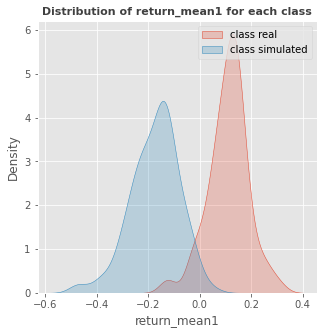

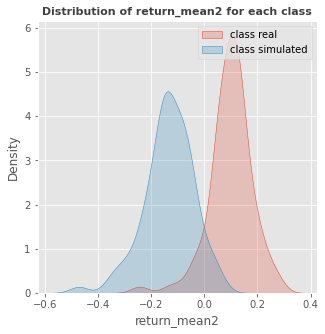

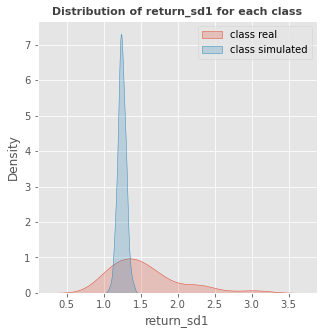

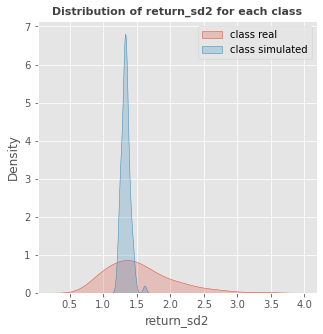

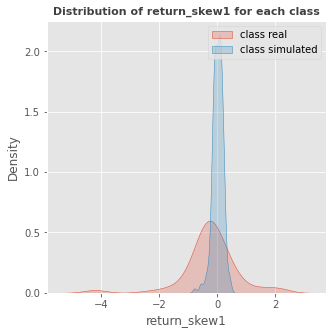

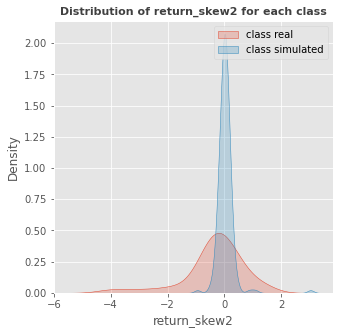

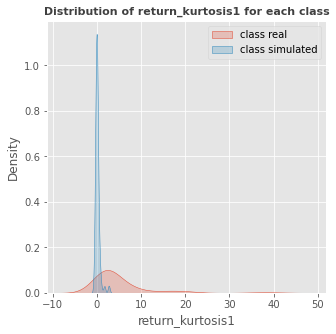

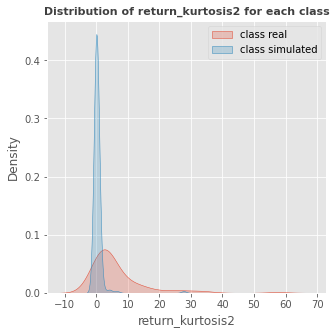

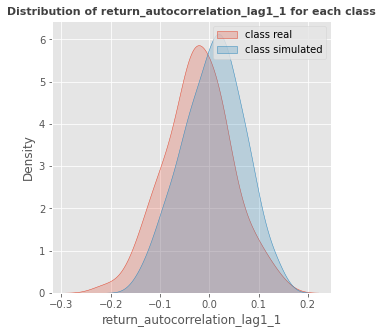

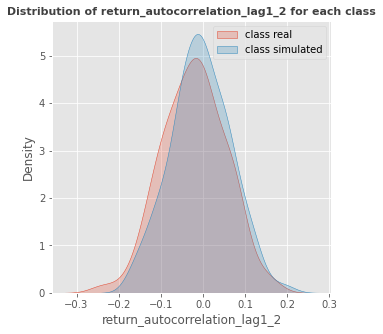

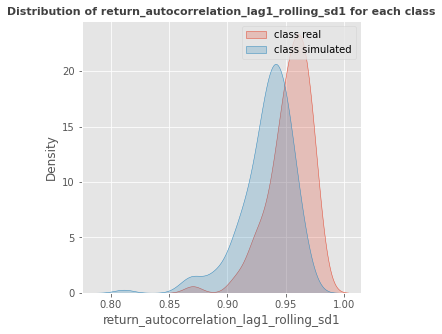

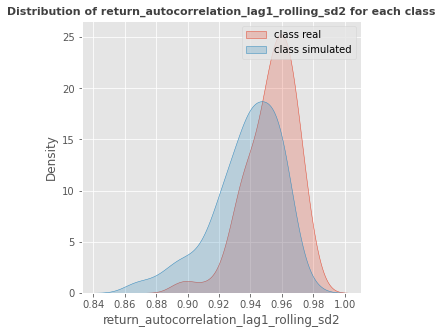

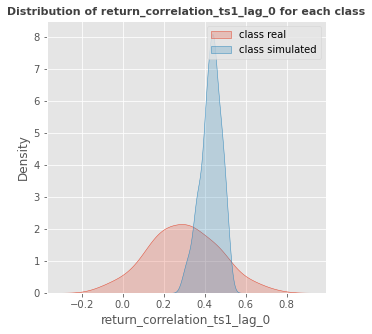

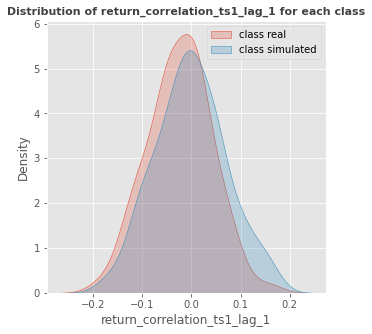

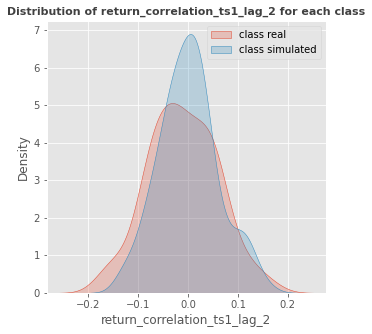

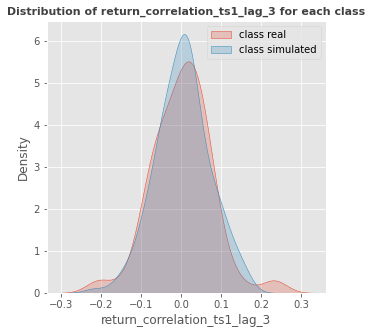

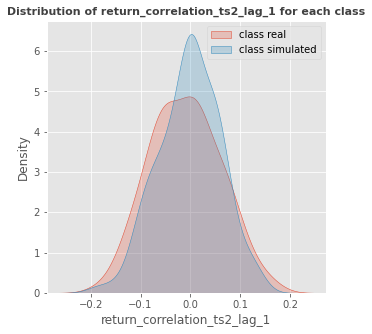

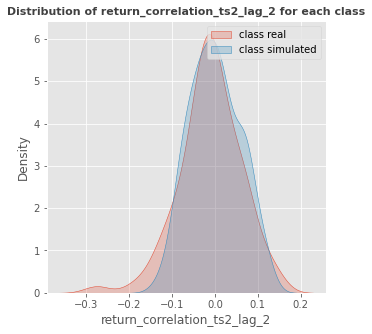

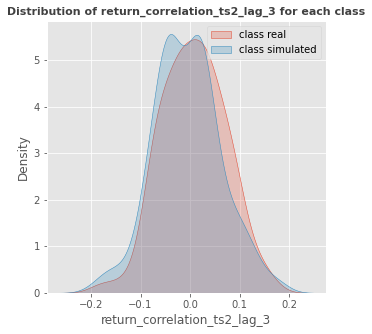

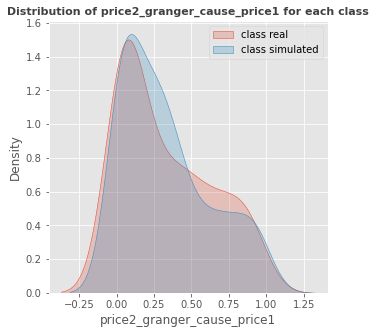

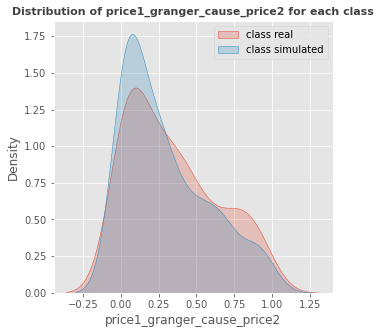

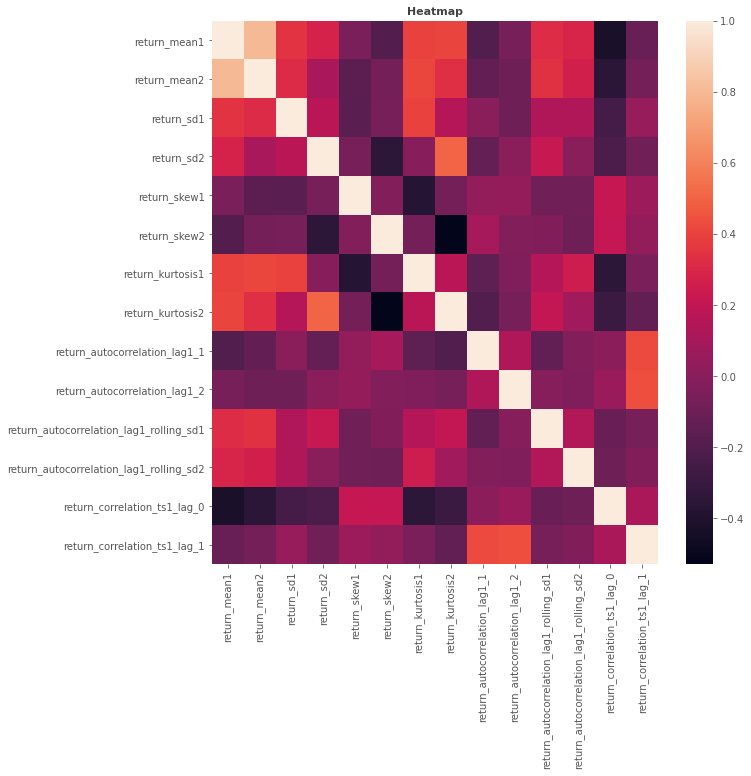

In [4]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
real_statistics = real_statistics.iloc[0:124 ,:]
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=params[12], 
        beta1=beta1, beta2=beta2, 
        delta0=params[13], 
        mu1=params[14], mu2=params[15], 
        lambda11=lambda11, lambda12=lambda12, 
        lambda21=lambda21, lambda22=lambda22,
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:21]
    y = dataset.iloc[:, 21]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/ou_jump12_calibration_update_classification_EDA/AutoML_EDA")
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)


In [5]:
print(results)
print(accuracy_average)
print(accuracy_std)

[0.9642857142857143, 0.9553571428571429, 0.9821428571428571, 0.9732142857142857, 0.9821428571428571]
0.9714285714285713
0.010412414097938
